In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Activation, Flatten, TimeDistributed, \
Conv1D,MaxPooling1D,Input, LSTM
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model,X_test,y_test,type_cm,display_labels,cmap=plt.cm.Blues,normalize=True):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    c_mat = confusion_matrix(y_test,y_pred)
    if normalize:
        c_mat = np.round(c_mat.astype('float') / c_mat.sum(axis=1)[:, np.newaxis],4)
    plt.imshow(c_mat, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix'+type_cm)
    plt.colorbar()
    tick_marks = np.arange(len(display_labels))
    plt.xticks(tick_marks, display_labels, rotation=0)
    plt.yticks(tick_marks, display_labels)
    thresh = c_mat.max() / 2.
    for i, j in itertools.product(range(c_mat.shape[0]), range(c_mat.shape[1])):
        plt.text(j, i, c_mat[i, j],
                 horizontalalignment="center",
                 color="white" if c_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def disp_confusion_matrix(model,X,y,type_cm,class_label):
    disp = plot_confusion_matrix(model, X, y, type_cm,display_labels=class_label,
                                 cmap=plt.cm.Blues)
    
def testers(lr,model,epochs=100,verb=1,batch_size=30):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    num_epochs = epochs
    history = model.fit(X_train,y_train, epochs = num_epochs, batch_size=batch_size,\
                        shuffle=False, verbose=verb,validation_data=(X_test,y_test))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Costo vs Época')
    plt.ylabel('Costo')
    plt.xlabel('Época')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    disp_confusion_matrix(model,X_test,y_test,' first six set A',class_label=['Left Hand','Right Hand','Neutral']) 
    
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [3]:
#Import preprocessed data
path ='Pre-Dat/SSA/Fp1-F3-P4-O2-A1-T3'
extension = ''
X_train = np.load(path+'/X_train'+f'{extension}.npy')
X_test = np.load(path+'/X_test'+f'{extension}.npy')
y_train = np.load(path+'/y_train'+f'{extension}.npy')
y_test = np.load(path+'/y_test'+f'{extension}.npy')
# Transform into sub-sequences of 50 time points
n_steps, n_length,n_features = 4, 50,X_train.shape[2]
X_train = X_train.reshape([X_train.shape[0],n_steps,n_length,n_features])
X_test = X_test.reshape([X_test.shape[0],n_steps,n_length,n_features])

# # Transform into sub-sequences of 25 time points
# n_steps, n_length,n_features = 8, 25,X_train.shape[2]
# X_train = X_train.reshape([X_train.shape[0],n_steps,n_length,n_features])
# X_test = X_test.reshape([X_test.shape[0],n_steps,n_length,n_features])

In [4]:
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (10880, 4, 50, 6)
y train shape: (10880, 3)
X test shape: (2720, 4, 50, 6)
y test shape: (2720, 3)


In [13]:
def CNN_LSTM_model (n_features=6,activation='tanh',dense_activation='relu',dropout_rate=0.2,batch_normalization=True):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=128,kernel_size=2, activation='relu'),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=128,kernel_size=2, activation='relu')))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(200,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    model.add(Dense(200, activation=dense_activation))
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.001)))
    return model

In [14]:
model = CNN_LSTM_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, None, 49, 128)    1664      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, None, 48, 128)    32896     
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, None, 48, 128)    512       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, None, 48, 128)    0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, None, 24, 128)   

In [15]:
keras_model_memory_usage_in_bytes(model,batch_size=64)

10797731

Epoch 1/100
109/109 [==============================] - 3s 13ms/step - loss: 1.1028 - accuracy: 0.4414 - val_loss: 1.0809 - val_accuracy: 0.4162
Epoch 2/100
109/109 [==============================] - 1s 8ms/step - loss: 0.9078 - accuracy: 0.5729 - val_loss: 1.0110 - val_accuracy: 0.4971
Epoch 3/100
109/109 [==============================] - 1s 8ms/step - loss: 0.7474 - accuracy: 0.6803 - val_loss: 0.9496 - val_accuracy: 0.5489
Epoch 4/100
109/109 [==============================] - 1s 9ms/step - loss: 0.5691 - accuracy: 0.7726 - val_loss: 0.9292 - val_accuracy: 0.5915
Epoch 5/100
109/109 [==============================] - 1s 8ms/step - loss: 0.4464 - accuracy: 0.8259 - val_loss: 0.8826 - val_accuracy: 0.6474
Epoch 6/100
109/109 [==============================] - 1s 8ms/step - loss: 0.3281 - accuracy: 0.8781 - val_loss: 0.8415 - val_accuracy: 0.7051
Epoch 7/100
109/109 [==============================] - 1s 8ms/step - loss: 0.2648 - accuracy: 0.9007 - val_loss: 0.9227 - val_accuracy: 0.704

Epoch 58/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0450 - accuracy: 0.9859 - val_loss: 1.3581 - val_accuracy: 0.7368
Epoch 59/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0483 - accuracy: 0.9852 - val_loss: 1.3460 - val_accuracy: 0.7320
Epoch 60/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0486 - accuracy: 0.9847 - val_loss: 1.2846 - val_accuracy: 0.7371
Epoch 61/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0317 - accuracy: 0.9906 - val_loss: 1.2960 - val_accuracy: 0.7415
Epoch 62/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0294 - accuracy: 0.9914 - val_loss: 1.3289 - val_accuracy: 0.7423
Epoch 63/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0266 - accuracy: 0.9914 - val_loss: 1.3466 - val_accuracy: 0.7478
Epoch 64/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0286 - accuracy: 0.9906 - val_loss: 1.4248 - val_accuracy:

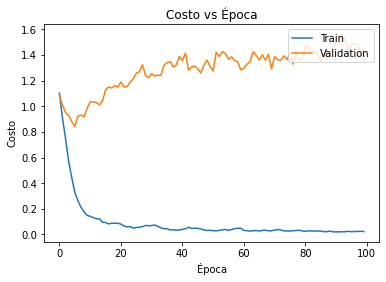

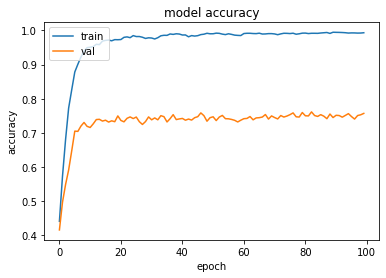

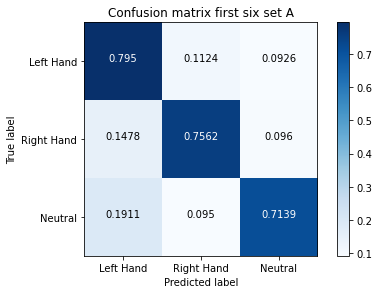

In [16]:
#Hard_sigmoid
testers(1e-3,model,epochs=100,batch_size=100)

## GridSearch CV

In [18]:
def CNN_LSTM_model_cv (filters=64,neurons=150,n_steps=200,n_features=6,activation='tanh', init_mode='glorot_normal',lr=1e-3,\
                    conv_activation='relu',dense_activation='hard_sigmoid',dropout_rate=0.5,batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [19]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [20]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [21]:
model = KerasClassifier(model=CNN_LSTM_model_cv,verbose=0)
#Define parameter grid
batch_size= [60,80,100]
epochs= [100,150,200]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

In [22]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.422000 using {'batch_size': 100, 'epochs': 150}
0.420667 (0.011333) with: {'batch_size': 60, 'epochs': 100}
0.390000 (0.022000) with: {'batch_size': 60, 'epochs': 150}
0.415333 (0.004667) with: {'batch_size': 60, 'epochs': 200}
0.405333 (0.018667) with: {'batch_size': 80, 'epochs': 100}
0.421333 (0.002667) with: {'batch_size': 80, 'epochs': 150}
0.399333 (0.011333) with: {'batch_size': 80, 'epochs': 200}
0.396000 (0.008000) with: {'batch_size': 100, 'epochs': 100}
0.422000 (0.011333) with: {'batch_size': 100, 'epochs': 150}
0.386667 (0.014667) with: {'batch_size': 100, 'epochs': 200}


### Activation Funciton

In [23]:
def CNN_LSTM_model_cv (conv_activation,dense_activation,filters=64,neurons=150,n_steps=200,n_features=6,activation='tanh', init_mode='glorot_normal',lr=1e-3,\
                    dropout_rate=0.5,batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [24]:
model = KerasClassifier(model=CNN_LSTM_model_cv,verbose=2,loss="categorical_crossentropy", epochs=200, batch_size=40)
#Define parameter grid
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__dense_activation=activation,model__conv_activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

Epoch 1/200
19/19 - 1s - loss: 1.1432 - accuracy: 0.3507 - 1s/epoch - 78ms/step
Epoch 2/200
19/19 - 0s - loss: 1.1262 - accuracy: 0.3707 - 111ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.1134 - accuracy: 0.3867 - 107ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.1059 - accuracy: 0.3880 - 104ms/epoch - 5ms/step
Epoch 5/200
19/19 - 0s - loss: 1.0996 - accuracy: 0.3827 - 104ms/epoch - 5ms/step
Epoch 6/200
19/19 - 0s - loss: 1.0961 - accuracy: 0.4080 - 116ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.0826 - accuracy: 0.4107 - 115ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.0938 - accuracy: 0.4013 - 111ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.0862 - accuracy: 0.4360 - 115ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.0772 - accuracy: 0.3960 - 111ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.0722 - accuracy: 0.4213 - 115ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.0662 - accuracy: 0.4307 - 110ms/epoch - 6ms/step
Epoch 13/200
19

Epoch 100/200
19/19 - 0s - loss: 0.1120 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1372 - accuracy: 0.9693 - 109ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0730 - accuracy: 0.9907 - 114ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0757 - accuracy: 0.9880 - 117ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1307 - accuracy: 0.9627 - 114ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0701 - accuracy: 0.9893 - 109ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.0964 - accuracy: 0.9773 - 110ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1180 - accuracy: 0.9747 - 108ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0919 - accuracy: 0.9813 - 111ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1010 - accuracy: 0.9760 - 107ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.0739 - accuracy: 0.9853 - 106ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0969 - accuracy: 0.9773 - 105ms/epoch - 6

Epoch 198/200
19/19 - 0s - loss: 0.0329 - accuracy: 0.9987 - 104ms/epoch - 5ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0401 - accuracy: 0.9920 - 104ms/epoch - 5ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0342 - accuracy: 0.9973 - 114ms/epoch - 6ms/step
19/19 - 0s - 267ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.1498 - accuracy: 0.3427 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.1398 - accuracy: 0.3320 - 113ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.1285 - accuracy: 0.3360 - 117ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.1178 - accuracy: 0.4027 - 113ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.1125 - accuracy: 0.3827 - 111ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.1079 - accuracy: 0.3867 - 114ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.1042 - accuracy: 0.3747 - 111ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.0923 - accuracy: 0.4160 - 112ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.0810 - accuracy: 0.4200 

Epoch 97/200
19/19 - 0s - loss: 0.1019 - accuracy: 0.9760 - 109ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1179 - accuracy: 0.9747 - 110ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1071 - accuracy: 0.9707 - 113ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1017 - accuracy: 0.9760 - 113ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1242 - accuracy: 0.9667 - 114ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1015 - accuracy: 0.9827 - 113ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1131 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1362 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0805 - accuracy: 0.9867 - 109ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1035 - accuracy: 0.9800 - 107ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1065 - accuracy: 0.9773 - 104ms/epoch - 5ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0956 - accuracy: 0.9787 - 102ms/epoch - 5ms/

Epoch 195/200
19/19 - 0s - loss: 0.0370 - accuracy: 0.9973 - 108ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0684 - accuracy: 0.9867 - 111ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0358 - accuracy: 0.9973 - 106ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0532 - accuracy: 0.9907 - 103ms/epoch - 5ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0374 - accuracy: 0.9933 - 110ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0322 - accuracy: 0.9960 - 111ms/epoch - 6ms/step
19/19 - 0s - 267ms/epoch - 14ms/step
Epoch 1/200
19/19 - 2s - loss: 1.9688 - accuracy: 0.3333 - 2s/epoch - 87ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6780 - accuracy: 0.3400 - 110ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.7920 - accuracy: 0.3293 - 111ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5973 - accuracy: 0.3587 - 107ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.5173 - accuracy: 0.3693 - 110ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.5620 - accuracy: 0

Epoch 94/200
19/19 - 0s - loss: 0.6877 - accuracy: 0.7013 - 108ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.6799 - accuracy: 0.7160 - 108ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.6732 - accuracy: 0.7133 - 108ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.6880 - accuracy: 0.7133 - 107ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.6674 - accuracy: 0.7013 - 108ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.6294 - accuracy: 0.7413 - 109ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.6106 - accuracy: 0.7373 - 108ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.6034 - accuracy: 0.7373 - 115ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.5983 - accuracy: 0.7547 - 110ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.5776 - accuracy: 0.7480 - 107ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.6186 - accuracy: 0.7480 - 107ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.5792 - accuracy: 0.7600 - 108ms/epoch - 6ms/ste

Epoch 192/200
19/19 - 0s - loss: 0.0492 - accuracy: 0.9853 - 106ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0343 - accuracy: 0.9960 - 107ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0348 - accuracy: 0.9947 - 107ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0573 - accuracy: 0.9880 - 108ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0583 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0655 - accuracy: 0.9813 - 108ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0498 - accuracy: 0.9933 - 102ms/epoch - 5ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0416 - accuracy: 0.9920 - 102ms/epoch - 5ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0398 - accuracy: 0.9920 - 113ms/epoch - 6ms/step
19/19 - 0s - 272ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9273 - accuracy: 0.3307 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.9443 - accuracy: 0.3200 - 102ms/epoch - 5ms/step
Epoch 3/200
19/19 - 0s - loss: 1.8375 - accur

Epoch 91/200
19/19 - 0s - loss: 0.7805 - accuracy: 0.6400 - 106ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.7358 - accuracy: 0.6707 - 102ms/epoch - 5ms/step
Epoch 93/200
19/19 - 0s - loss: 0.7402 - accuracy: 0.6827 - 104ms/epoch - 5ms/step
Epoch 94/200
19/19 - 0s - loss: 0.7224 - accuracy: 0.7067 - 107ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.7364 - accuracy: 0.6813 - 107ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.7099 - accuracy: 0.6893 - 109ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.7064 - accuracy: 0.7107 - 109ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.6483 - accuracy: 0.7333 - 108ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.6543 - accuracy: 0.7187 - 107ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.6124 - accuracy: 0.7280 - 108ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.6226 - accuracy: 0.7387 - 107ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.6527 - accuracy: 0.7280 - 110ms/epoch - 6ms/step
E

Epoch 189/200
19/19 - 0s - loss: 0.0418 - accuracy: 0.9893 - 107ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0575 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0361 - accuracy: 0.9933 - 108ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0570 - accuracy: 0.9920 - 108ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0511 - accuracy: 0.9880 - 108ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0382 - accuracy: 0.9920 - 111ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0355 - accuracy: 0.9960 - 114ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0385 - accuracy: 0.9960 - 109ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0412 - accuracy: 0.9907 - 106ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0556 - accuracy: 0.9853 - 106ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0373 - accuracy: 0.9920 - 106ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0255 - accuracy: 0.9973 - 106ms/epoch - 6

Epoch 88/200
19/19 - 0s - loss: 0.8121 - accuracy: 0.6573 - 108ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.7967 - accuracy: 0.6573 - 108ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.7628 - accuracy: 0.6787 - 107ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.7843 - accuracy: 0.6653 - 104ms/epoch - 5ms/step
Epoch 92/200
19/19 - 0s - loss: 0.7407 - accuracy: 0.6747 - 103ms/epoch - 5ms/step
Epoch 93/200
19/19 - 0s - loss: 0.7662 - accuracy: 0.6653 - 113ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.7281 - accuracy: 0.6853 - 111ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.7350 - accuracy: 0.6840 - 110ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.7411 - accuracy: 0.6813 - 109ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.7183 - accuracy: 0.7053 - 109ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.6716 - accuracy: 0.7373 - 112ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.6622 - accuracy: 0.7333 - 122ms/epoch - 6ms/step
Epoc

Epoch 186/200
19/19 - 0s - loss: 0.0572 - accuracy: 0.9880 - 107ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0475 - accuracy: 0.9880 - 108ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0534 - accuracy: 0.9813 - 111ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0504 - accuracy: 0.9880 - 108ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0399 - accuracy: 0.9907 - 109ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0455 - accuracy: 0.9880 - 109ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0542 - accuracy: 0.9867 - 112ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0654 - accuracy: 0.9893 - 111ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0505 - accuracy: 0.9880 - 111ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0578 - accuracy: 0.9880 - 111ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0449 - accuracy: 0.9880 - 108ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0628 - accuracy: 0.9853 - 101ms/epoch - 5

Epoch 85/200
19/19 - 0s - loss: 0.8681 - accuracy: 0.6253 - 110ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.8583 - accuracy: 0.6240 - 111ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.8513 - accuracy: 0.6267 - 108ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.8249 - accuracy: 0.6467 - 107ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.8269 - accuracy: 0.6373 - 106ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.8334 - accuracy: 0.6293 - 106ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.8170 - accuracy: 0.6293 - 103ms/epoch - 5ms/step
Epoch 92/200
19/19 - 0s - loss: 0.7832 - accuracy: 0.6587 - 100ms/epoch - 5ms/step
Epoch 93/200
19/19 - 0s - loss: 0.7884 - accuracy: 0.6680 - 102ms/epoch - 5ms/step
Epoch 94/200
19/19 - 0s - loss: 0.7635 - accuracy: 0.6840 - 108ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.7642 - accuracy: 0.6773 - 108ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.7587 - accuracy: 0.6853 - 106ms/epoch - 6ms/step
Epoc

Epoch 183/200
19/19 - 0s - loss: 0.0671 - accuracy: 0.9827 - 108ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0597 - accuracy: 0.9800 - 102ms/epoch - 5ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0673 - accuracy: 0.9773 - 111ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0623 - accuracy: 0.9840 - 111ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0490 - accuracy: 0.9893 - 111ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0487 - accuracy: 0.9827 - 107ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0380 - accuracy: 0.9893 - 108ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0534 - accuracy: 0.9920 - 108ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0456 - accuracy: 0.9893 - 109ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0690 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0587 - accuracy: 0.9880 - 107ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0481 - accuracy: 0.9893 - 108ms/epoch - 6

Epoch 82/200
19/19 - 0s - loss: 1.0330 - accuracy: 0.4613 - 110ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 1.0344 - accuracy: 0.4720 - 109ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 1.0446 - accuracy: 0.4453 - 109ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 1.0292 - accuracy: 0.4733 - 109ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 1.0061 - accuracy: 0.4947 - 109ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 1.0103 - accuracy: 0.4933 - 109ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.9920 - accuracy: 0.4947 - 117ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.9872 - accuracy: 0.5000 - 110ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.9866 - accuracy: 0.4987 - 109ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.9941 - accuracy: 0.4960 - 113ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.9904 - accuracy: 0.4960 - 106ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.9888 - accuracy: 0.5080 - 104ms/epoch - 5ms/step
Epoc

Epoch 180/200
19/19 - 0s - loss: 0.1016 - accuracy: 0.9693 - 107ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.1122 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.1037 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0962 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0822 - accuracy: 0.9747 - 108ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0888 - accuracy: 0.9747 - 102ms/epoch - 5ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0886 - accuracy: 0.9813 - 101ms/epoch - 5ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0827 - accuracy: 0.9747 - 103ms/epoch - 5ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0924 - accuracy: 0.9693 - 112ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0780 - accuracy: 0.9747 - 117ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0822 - accuracy: 0.9800 - 111ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0821 - accuracy: 0.9760 - 106ms/epoch - 6

19/19 - 0s - loss: 1.0548 - accuracy: 0.4427 - 107ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 1.0656 - accuracy: 0.4467 - 109ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 1.0501 - accuracy: 0.4587 - 109ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 1.0240 - accuracy: 0.4813 - 111ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 1.0385 - accuracy: 0.4800 - 108ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 1.0271 - accuracy: 0.4560 - 109ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 1.0420 - accuracy: 0.4773 - 108ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 1.0298 - accuracy: 0.4867 - 113ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 1.0167 - accuracy: 0.4827 - 114ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 1.0031 - accuracy: 0.4947 - 114ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 1.0063 - accuracy: 0.4960 - 108ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 1.0069 - accuracy: 0.4733 - 108ms/epoch - 6ms/step
Epoch 90/200
19/1

Epoch 176/200
19/19 - 0s - loss: 0.1057 - accuracy: 0.9733 - 109ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0663 - accuracy: 0.9853 - 118ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0927 - accuracy: 0.9707 - 115ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0864 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0720 - accuracy: 0.9867 - 111ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0834 - accuracy: 0.9747 - 110ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.1019 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0853 - accuracy: 0.9760 - 104ms/epoch - 5ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0758 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1094 - accuracy: 0.9667 - 110ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1048 - accuracy: 0.9667 - 113ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0812 - accuracy: 0.9760 - 109ms/epoch - 6

19/19 - 0s - loss: 0.9747 - accuracy: 0.5347 - 107ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.9223 - accuracy: 0.5533 - 110ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.9395 - accuracy: 0.5360 - 109ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.9578 - accuracy: 0.5440 - 110ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.9112 - accuracy: 0.5947 - 109ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.9237 - accuracy: 0.5800 - 109ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.9064 - accuracy: 0.5920 - 110ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.8692 - accuracy: 0.6133 - 111ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.8704 - accuracy: 0.6160 - 116ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.8889 - accuracy: 0.5933 - 111ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.8916 - accuracy: 0.6147 - 109ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.8863 - accuracy: 0.5960 - 114ms/epoch - 6ms/step
Epoch 86/200
19/1

Epoch 172/200
19/19 - 0s - loss: 0.0901 - accuracy: 0.9733 - 113ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0427 - accuracy: 0.9880 - 113ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0503 - accuracy: 0.9907 - 123ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0642 - accuracy: 0.9827 - 133ms/epoch - 7ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0604 - accuracy: 0.9813 - 127ms/epoch - 7ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0917 - accuracy: 0.9760 - 126ms/epoch - 7ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0704 - accuracy: 0.9760 - 128ms/epoch - 7ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0625 - accuracy: 0.9773 - 124ms/epoch - 7ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0672 - accuracy: 0.9853 - 118ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0598 - accuracy: 0.9867 - 118ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0573 - accuracy: 0.9827 - 118ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0555 - accuracy: 0.9880 - 117ms/epoch - 6

19/19 - 0s - loss: 0.9497 - accuracy: 0.5547 - 123ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.9409 - accuracy: 0.5640 - 113ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.9620 - accuracy: 0.5493 - 117ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.9591 - accuracy: 0.5653 - 118ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.9511 - accuracy: 0.5573 - 115ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.9095 - accuracy: 0.5947 - 114ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.9124 - accuracy: 0.5960 - 107ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.9134 - accuracy: 0.5787 - 108ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.9181 - accuracy: 0.5933 - 115ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.8995 - accuracy: 0.5973 - 117ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.8967 - accuracy: 0.5933 - 117ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.8513 - accuracy: 0.6213 - 116ms/epoch - 6ms/step
Epoch 82/200
19/1

19/19 - 0s - loss: 0.0881 - accuracy: 0.9747 - 115ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0513 - accuracy: 0.9893 - 118ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.0431 - accuracy: 0.9907 - 119ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.0535 - accuracy: 0.9880 - 116ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.0536 - accuracy: 0.9880 - 121ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0520 - accuracy: 0.9853 - 115ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0606 - accuracy: 0.9773 - 118ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0778 - accuracy: 0.9813 - 127ms/epoch - 7ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0583 - accuracy: 0.9880 - 122ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0510 - accuracy: 0.9880 - 113ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0792 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0668 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 

Epoch 67/200
19/19 - 0s - loss: 0.8968 - accuracy: 0.5800 - 112ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.8640 - accuracy: 0.5840 - 113ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.8684 - accuracy: 0.5947 - 119ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.8841 - accuracy: 0.5880 - 120ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.8440 - accuracy: 0.6280 - 114ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.8471 - accuracy: 0.6013 - 114ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.8301 - accuracy: 0.6387 - 114ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.8182 - accuracy: 0.6293 - 114ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.8217 - accuracy: 0.6160 - 118ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.8133 - accuracy: 0.6347 - 117ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.8145 - accuracy: 0.6267 - 120ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.7561 - accuracy: 0.6520 - 110ms/epoch - 6ms/step
Epoc

Epoch 165/200
19/19 - 0s - loss: 0.0340 - accuracy: 0.9960 - 103ms/epoch - 5ms/step
Epoch 166/200
19/19 - 0s - loss: 0.0416 - accuracy: 0.9933 - 113ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.0383 - accuracy: 0.9947 - 112ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0748 - accuracy: 0.9827 - 112ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0353 - accuracy: 0.9933 - 115ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.0678 - accuracy: 0.9760 - 113ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.0364 - accuracy: 0.9920 - 118ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.0534 - accuracy: 0.9827 - 122ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0449 - accuracy: 0.9880 - 117ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0458 - accuracy: 0.9920 - 114ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0459 - accuracy: 0.9893 - 112ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0368 - accuracy: 0.9933 - 116ms/epoch - 6

Epoch 63/200
19/19 - 0s - loss: 0.9460 - accuracy: 0.5707 - 109ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.9148 - accuracy: 0.5493 - 108ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.9501 - accuracy: 0.5533 - 109ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.9261 - accuracy: 0.5693 - 131ms/epoch - 7ms/step
Epoch 67/200
19/19 - 0s - loss: 0.9077 - accuracy: 0.5933 - 141ms/epoch - 7ms/step
Epoch 68/200
19/19 - 0s - loss: 0.8812 - accuracy: 0.5933 - 111ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.8927 - accuracy: 0.6147 - 110ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.8875 - accuracy: 0.5973 - 107ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.8740 - accuracy: 0.6080 - 105ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.8750 - accuracy: 0.5867 - 106ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.8475 - accuracy: 0.6333 - 103ms/epoch - 5ms/step
Epoch 74/200
19/19 - 0s - loss: 0.8652 - accuracy: 0.6053 - 111ms/epoch - 6ms/step
Epoc

Epoch 161/200
19/19 - 0s - loss: 0.0678 - accuracy: 0.9827 - 106ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0626 - accuracy: 0.9853 - 103ms/epoch - 5ms/step
Epoch 163/200
19/19 - 0s - loss: 0.0526 - accuracy: 0.9840 - 100ms/epoch - 5ms/step
Epoch 164/200
19/19 - 0s - loss: 0.0886 - accuracy: 0.9720 - 107ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0584 - accuracy: 0.9880 - 106ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1030 - accuracy: 0.9720 - 108ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.0795 - accuracy: 0.9787 - 106ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0544 - accuracy: 0.9880 - 107ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0592 - accuracy: 0.9880 - 108ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.0385 - accuracy: 0.9920 - 110ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.0403 - accuracy: 0.9907 - 114ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.0553 - accuracy: 0.9813 - 108ms/epoch - 6

Epoch 59/200
19/19 - 0s - loss: 0.9307 - accuracy: 0.5493 - 113ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.9413 - accuracy: 0.5320 - 117ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.9409 - accuracy: 0.5493 - 111ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.9210 - accuracy: 0.5800 - 112ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.9254 - accuracy: 0.5667 - 108ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.9114 - accuracy: 0.5667 - 109ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.8799 - accuracy: 0.6027 - 112ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.8734 - accuracy: 0.6120 - 108ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.8866 - accuracy: 0.5773 - 110ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.8639 - accuracy: 0.6013 - 110ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.8738 - accuracy: 0.5880 - 112ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.8417 - accuracy: 0.6120 - 108ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.0967 - accuracy: 0.9747 - 110ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0707 - accuracy: 0.9813 - 115ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0809 - accuracy: 0.9747 - 117ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0632 - accuracy: 0.9827 - 109ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0506 - accuracy: 0.9880 - 109ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0487 - accuracy: 0.9893 - 104ms/epoch - 5ms/step
Epoch 163/200
19/19 - 0s - loss: 0.0515 - accuracy: 0.9827 - 102ms/epoch - 5ms/step
Epoch 164/200
19/19 - 0s - loss: 0.0723 - accuracy: 0.9813 - 108ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0506 - accuracy: 0.9893 - 109ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.0595 - accuracy: 0.9800 - 112ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.0481 - accuracy: 0.9893 - 112ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0855 - accuracy: 0.9693 - 110ms/epoch - 6ms/step
Epoch 

19/19 - 0s - loss: 0.9948 - accuracy: 0.5160 - 112ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.9825 - accuracy: 0.5187 - 119ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 1.0113 - accuracy: 0.4933 - 113ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.9884 - accuracy: 0.5333 - 113ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.9836 - accuracy: 0.5040 - 113ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.9703 - accuracy: 0.5320 - 113ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.9819 - accuracy: 0.5200 - 114ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.9544 - accuracy: 0.5547 - 110ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.9656 - accuracy: 0.5547 - 113ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.9483 - accuracy: 0.5680 - 114ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.9450 - accuracy: 0.5680 - 111ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.9421 - accuracy: 0.5600 - 109ms/epoch - 6ms/step
Epoch 67/200
19/1

Epoch 154/200
19/19 - 0s - loss: 0.0573 - accuracy: 0.9893 - 110ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0680 - accuracy: 0.9853 - 108ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0639 - accuracy: 0.9813 - 106ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0627 - accuracy: 0.9787 - 110ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0702 - accuracy: 0.9813 - 115ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0880 - accuracy: 0.9733 - 114ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0699 - accuracy: 0.9747 - 113ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0536 - accuracy: 0.9853 - 112ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0464 - accuracy: 0.9920 - 112ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.0358 - accuracy: 0.9933 - 109ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.0696 - accuracy: 0.9827 - 115ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0542 - accuracy: 0.9867 - 116ms/epoch - 6

Epoch 52/200
19/19 - 0s - loss: 1.0432 - accuracy: 0.4613 - 111ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 1.0487 - accuracy: 0.4520 - 111ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 1.0090 - accuracy: 0.4720 - 107ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 1.0270 - accuracy: 0.4840 - 113ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 1.0036 - accuracy: 0.4733 - 110ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 1.0022 - accuracy: 0.4907 - 120ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.9828 - accuracy: 0.5000 - 114ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.9751 - accuracy: 0.5253 - 114ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.9829 - accuracy: 0.5000 - 120ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.9976 - accuracy: 0.5027 - 114ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.9649 - accuracy: 0.5227 - 111ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.9632 - accuracy: 0.5227 - 104ms/epoch - 5ms/step
Epoc

19/19 - 0s - loss: 0.0735 - accuracy: 0.9773 - 110ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0699 - accuracy: 0.9867 - 108ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0812 - accuracy: 0.9773 - 105ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0653 - accuracy: 0.9907 - 116ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0712 - accuracy: 0.9800 - 118ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0564 - accuracy: 0.9893 - 120ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0707 - accuracy: 0.9840 - 116ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0708 - accuracy: 0.9853 - 113ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0586 - accuracy: 0.9907 - 112ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0583 - accuracy: 0.9867 - 110ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0475 - accuracy: 0.9920 - 116ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0437 - accuracy: 0.9933 - 121ms/epoch - 6ms/step
Epoch 

Epoch 48/200
19/19 - 0s - loss: 0.9978 - accuracy: 0.5307 - 116ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.9998 - accuracy: 0.4800 - 118ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.9964 - accuracy: 0.5200 - 123ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.9913 - accuracy: 0.5187 - 117ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 1.0217 - accuracy: 0.4853 - 111ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.9930 - accuracy: 0.5173 - 110ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.9690 - accuracy: 0.5107 - 107ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.9643 - accuracy: 0.5280 - 104ms/epoch - 5ms/step
Epoch 56/200
19/19 - 0s - loss: 0.9459 - accuracy: 0.5480 - 119ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.9665 - accuracy: 0.5240 - 112ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.9605 - accuracy: 0.5480 - 117ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.9437 - accuracy: 0.5520 - 108ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.1073 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0788 - accuracy: 0.9787 - 119ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0698 - accuracy: 0.9840 - 109ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0802 - accuracy: 0.9760 - 118ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0674 - accuracy: 0.9800 - 115ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0736 - accuracy: 0.9827 - 131ms/epoch - 7ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0733 - accuracy: 0.9827 - 120ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0771 - accuracy: 0.9827 - 113ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0663 - accuracy: 0.9840 - 112ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0576 - accuracy: 0.9827 - 110ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0617 - accuracy: 0.9867 - 110ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0479 - accuracy: 0.9907 - 110ms/epoch - 6ms/step
Epoch 

Epoch 44/200
19/19 - 0s - loss: 0.2648 - accuracy: 0.9187 - 110ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2604 - accuracy: 0.9107 - 107ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2341 - accuracy: 0.9280 - 108ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2545 - accuracy: 0.9213 - 108ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2722 - accuracy: 0.9093 - 108ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2971 - accuracy: 0.9027 - 107ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2627 - accuracy: 0.9173 - 104ms/epoch - 5ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2264 - accuracy: 0.9387 - 104ms/epoch - 5ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2160 - accuracy: 0.9373 - 102ms/epoch - 5ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2293 - accuracy: 0.9187 - 109ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2074 - accuracy: 0.9427 - 112ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2109 - accuracy: 0.9333 - 109ms/epoch - 6ms/step
Epoc

Epoch 143/200
19/19 - 0s - loss: 0.1203 - accuracy: 0.9653 - 103ms/epoch - 5ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1238 - accuracy: 0.9653 - 104ms/epoch - 5ms/step
Epoch 145/200
19/19 - 0s - loss: 0.1036 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.1127 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1137 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1028 - accuracy: 0.9720 - 107ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1161 - accuracy: 0.9627 - 107ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1124 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1086 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1268 - accuracy: 0.9667 - 109ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.1039 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0969 - accuracy: 0.9707 - 109ms/epoch - 6

Epoch 41/200
19/19 - 0s - loss: 0.3220 - accuracy: 0.8867 - 112ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2906 - accuracy: 0.9093 - 107ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3073 - accuracy: 0.8987 - 109ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.2916 - accuracy: 0.9133 - 110ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.3101 - accuracy: 0.9000 - 116ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2855 - accuracy: 0.9040 - 112ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2604 - accuracy: 0.9227 - 118ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2547 - accuracy: 0.9213 - 112ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2663 - accuracy: 0.9107 - 111ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2837 - accuracy: 0.9080 - 120ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2446 - accuracy: 0.9240 - 104ms/epoch - 5ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2264 - accuracy: 0.9400 - 105ms/epoch - 6ms/step
Epoc

Epoch 140/200
19/19 - 0s - loss: 0.1480 - accuracy: 0.9547 - 106ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1429 - accuracy: 0.9600 - 107ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1340 - accuracy: 0.9560 - 100ms/epoch - 5ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0950 - accuracy: 0.9747 - 111ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1113 - accuracy: 0.9667 - 111ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.1118 - accuracy: 0.9667 - 113ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.1139 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1118 - accuracy: 0.9747 - 108ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1092 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1424 - accuracy: 0.9507 - 110ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1260 - accuracy: 0.9653 - 112ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1006 - accuracy: 0.9747 - 118ms/epoch - 6

Epoch 38/200
19/19 - 0s - loss: 0.5128 - accuracy: 0.7907 - 107ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.4863 - accuracy: 0.8240 - 107ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.5032 - accuracy: 0.8027 - 112ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.4963 - accuracy: 0.7973 - 107ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.3981 - accuracy: 0.8520 - 113ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.4074 - accuracy: 0.8520 - 116ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.4489 - accuracy: 0.8333 - 114ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.4117 - accuracy: 0.8520 - 114ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3965 - accuracy: 0.8573 - 111ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.3811 - accuracy: 0.8613 - 105ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.3779 - accuracy: 0.8573 - 109ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.3724 - accuracy: 0.8547 - 115ms/epoch - 6ms/step
Epoc

Epoch 137/200
19/19 - 0s - loss: 0.0922 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0853 - accuracy: 0.9773 - 102ms/epoch - 5ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1048 - accuracy: 0.9667 - 103ms/epoch - 5ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0944 - accuracy: 0.9720 - 109ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0919 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0761 - accuracy: 0.9800 - 106ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0837 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0905 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0909 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0905 - accuracy: 0.9627 - 107ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1047 - accuracy: 0.9680 - 108ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1130 - accuracy: 0.9627 - 110ms/epoch - 6

Epoch 35/200
19/19 - 0s - loss: 0.5779 - accuracy: 0.7733 - 108ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.5106 - accuracy: 0.7973 - 108ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.5023 - accuracy: 0.7973 - 107ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.5090 - accuracy: 0.7947 - 105ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.4545 - accuracy: 0.8333 - 112ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.4606 - accuracy: 0.8240 - 108ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.5063 - accuracy: 0.8093 - 107ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.4430 - accuracy: 0.8320 - 109ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.4661 - accuracy: 0.8320 - 107ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.4054 - accuracy: 0.8413 - 114ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.3779 - accuracy: 0.8707 - 108ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3806 - accuracy: 0.8640 - 108ms/epoch - 6ms/step
Epoc

Epoch 134/200
19/19 - 0s - loss: 0.1265 - accuracy: 0.9573 - 115ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1015 - accuracy: 0.9707 - 112ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1396 - accuracy: 0.9547 - 110ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1462 - accuracy: 0.9520 - 109ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1007 - accuracy: 0.9707 - 113ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0834 - accuracy: 0.9733 - 110ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1534 - accuracy: 0.9400 - 102ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1180 - accuracy: 0.9640 - 111ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0929 - accuracy: 0.9760 - 113ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1040 - accuracy: 0.9653 - 112ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0969 - accuracy: 0.9707 - 110ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0706 - accuracy: 0.9773 - 116ms/epoch - 6

Epoch 32/200
19/19 - 0s - loss: 0.8393 - accuracy: 0.6373 - 116ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.8238 - accuracy: 0.6293 - 114ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.7900 - accuracy: 0.6627 - 109ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.7146 - accuracy: 0.7080 - 110ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.7589 - accuracy: 0.6880 - 108ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.7032 - accuracy: 0.7133 - 112ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.6552 - accuracy: 0.7240 - 109ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.6832 - accuracy: 0.7133 - 116ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.5998 - accuracy: 0.7653 - 112ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.6430 - accuracy: 0.7387 - 108ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.5610 - accuracy: 0.7640 - 121ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.5746 - accuracy: 0.7853 - 118ms/epoch - 6ms/step
Epoc

Epoch 131/200
19/19 - 0s - loss: 0.1385 - accuracy: 0.9587 - 109ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1588 - accuracy: 0.9400 - 117ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1189 - accuracy: 0.9653 - 114ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.2027 - accuracy: 0.9347 - 107ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1403 - accuracy: 0.9533 - 107ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1821 - accuracy: 0.9387 - 109ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1290 - accuracy: 0.9520 - 115ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1265 - accuracy: 0.9613 - 120ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1342 - accuracy: 0.9573 - 111ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1282 - accuracy: 0.9587 - 110ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1225 - accuracy: 0.9613 - 109ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1162 - accuracy: 0.9627 - 112ms/epoch - 6

Epoch 29/200
19/19 - 0s - loss: 0.8636 - accuracy: 0.6133 - 106ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.8342 - accuracy: 0.6493 - 106ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.8118 - accuracy: 0.6427 - 112ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.7722 - accuracy: 0.6653 - 112ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.7479 - accuracy: 0.7000 - 106ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.7175 - accuracy: 0.7107 - 108ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.7024 - accuracy: 0.7160 - 105ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.6439 - accuracy: 0.7307 - 110ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.6765 - accuracy: 0.7280 - 108ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.6714 - accuracy: 0.7360 - 108ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.5815 - accuracy: 0.7853 - 109ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.5961 - accuracy: 0.7547 - 100ms/epoch - 5ms/step
Epoc

Epoch 128/200
19/19 - 0s - loss: 0.1823 - accuracy: 0.9387 - 106ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1519 - accuracy: 0.9560 - 105ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1512 - accuracy: 0.9507 - 106ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1669 - accuracy: 0.9507 - 107ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1596 - accuracy: 0.9507 - 102ms/epoch - 5ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1587 - accuracy: 0.9467 - 101ms/epoch - 5ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1191 - accuracy: 0.9613 - 102ms/epoch - 5ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1119 - accuracy: 0.9587 - 105ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1482 - accuracy: 0.9573 - 105ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1388 - accuracy: 0.9520 - 110ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1278 - accuracy: 0.9640 - 104ms/epoch - 5ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1110 - accuracy: 0.9573 - 105ms/epoch - 6

Epoch 26/200
19/19 - 0s - loss: 1.0428 - accuracy: 0.5000 - 105ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 1.0416 - accuracy: 0.5000 - 100ms/epoch - 5ms/step
Epoch 28/200
19/19 - 0s - loss: 1.0159 - accuracy: 0.4867 - 101ms/epoch - 5ms/step
Epoch 29/200
19/19 - 0s - loss: 0.9806 - accuracy: 0.5360 - 100ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.9760 - accuracy: 0.5120 - 108ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.9466 - accuracy: 0.5667 - 107ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.9419 - accuracy: 0.5467 - 107ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.8717 - accuracy: 0.6107 - 102ms/epoch - 5ms/step
Epoch 34/200
19/19 - 0s - loss: 0.9110 - accuracy: 0.5627 - 105ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.8659 - accuracy: 0.6013 - 103ms/epoch - 5ms/step
Epoch 36/200
19/19 - 0s - loss: 0.8632 - accuracy: 0.6160 - 105ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.8509 - accuracy: 0.6213 - 112ms/epoch - 6ms/step
Epoc

Epoch 125/200
19/19 - 0s - loss: 0.1782 - accuracy: 0.9360 - 109ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1651 - accuracy: 0.9440 - 108ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1537 - accuracy: 0.9547 - 107ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1565 - accuracy: 0.9520 - 113ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1560 - accuracy: 0.9493 - 109ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1454 - accuracy: 0.9587 - 114ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1533 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1693 - accuracy: 0.9480 - 107ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1293 - accuracy: 0.9573 - 113ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1361 - accuracy: 0.9573 - 111ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1122 - accuracy: 0.9627 - 109ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1184 - accuracy: 0.9653 - 111ms/epoch - 6

Epoch 23/200
19/19 - 0s - loss: 1.0592 - accuracy: 0.4627 - 112ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 1.0111 - accuracy: 0.5000 - 114ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 1.0406 - accuracy: 0.5093 - 118ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 1.0036 - accuracy: 0.4973 - 108ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.9864 - accuracy: 0.5333 - 107ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.9765 - accuracy: 0.5280 - 103ms/epoch - 5ms/step
Epoch 29/200
19/19 - 0s - loss: 0.9501 - accuracy: 0.5707 - 110ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.9553 - accuracy: 0.5280 - 123ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.9700 - accuracy: 0.5147 - 113ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.9340 - accuracy: 0.5707 - 114ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.9093 - accuracy: 0.5893 - 120ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.8942 - accuracy: 0.5973 - 117ms/epoch - 6ms/step
Epoc

Epoch 122/200
19/19 - 0s - loss: 0.1599 - accuracy: 0.9467 - 117ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1855 - accuracy: 0.9360 - 120ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1861 - accuracy: 0.9440 - 115ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1423 - accuracy: 0.9453 - 116ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1614 - accuracy: 0.9440 - 116ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1592 - accuracy: 0.9467 - 117ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1509 - accuracy: 0.9533 - 114ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1643 - accuracy: 0.9533 - 115ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1225 - accuracy: 0.9640 - 108ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1852 - accuracy: 0.9440 - 113ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1416 - accuracy: 0.9507 - 110ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1479 - accuracy: 0.9507 - 119ms/epoch - 6

Epoch 20/200
19/19 - 0s - loss: 1.0284 - accuracy: 0.5027 - 109ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 1.0572 - accuracy: 0.4827 - 110ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.9640 - accuracy: 0.5653 - 108ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.9804 - accuracy: 0.5533 - 110ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.9295 - accuracy: 0.5773 - 110ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.9265 - accuracy: 0.5747 - 116ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.8870 - accuracy: 0.6173 - 111ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.8612 - accuracy: 0.6000 - 112ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.8450 - accuracy: 0.6147 - 119ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.8098 - accuracy: 0.6600 - 110ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.7449 - accuracy: 0.7000 - 112ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.7097 - accuracy: 0.6907 - 109ms/epoch - 6ms/step
Epoc

Epoch 119/200
19/19 - 0s - loss: 0.1817 - accuracy: 0.9333 - 113ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1558 - accuracy: 0.9507 - 115ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1620 - accuracy: 0.9467 - 111ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1776 - accuracy: 0.9400 - 110ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1365 - accuracy: 0.9587 - 106ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1627 - accuracy: 0.9507 - 117ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1569 - accuracy: 0.9480 - 112ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1566 - accuracy: 0.9493 - 108ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1369 - accuracy: 0.9613 - 110ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1250 - accuracy: 0.9640 - 110ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1315 - accuracy: 0.9587 - 109ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1032 - accuracy: 0.9667 - 121ms/epoch - 6

Epoch 17/200
19/19 - 0s - loss: 1.1910 - accuracy: 0.4280 - 105ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.1276 - accuracy: 0.4573 - 111ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 1.0988 - accuracy: 0.4747 - 113ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0967 - accuracy: 0.4720 - 116ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 1.0526 - accuracy: 0.5040 - 110ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 1.0060 - accuracy: 0.5213 - 112ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.9994 - accuracy: 0.5333 - 120ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 1.0030 - accuracy: 0.5293 - 111ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.9421 - accuracy: 0.5640 - 105ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.9439 - accuracy: 0.5773 - 107ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.9505 - accuracy: 0.5733 - 109ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.8694 - accuracy: 0.6067 - 109ms/epoch - 6ms/step
Epoc

Epoch 116/200
19/19 - 0s - loss: 0.1655 - accuracy: 0.9387 - 116ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1623 - accuracy: 0.9507 - 113ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1629 - accuracy: 0.9440 - 112ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1474 - accuracy: 0.9507 - 110ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1709 - accuracy: 0.9440 - 110ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1536 - accuracy: 0.9493 - 118ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1477 - accuracy: 0.9520 - 110ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.2107 - accuracy: 0.9280 - 108ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1748 - accuracy: 0.9493 - 106ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1477 - accuracy: 0.9480 - 103ms/epoch - 5ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1289 - accuracy: 0.9573 - 101ms/epoch - 5ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1563 - accuracy: 0.9413 - 107ms/epoch - 6

Epoch 14/200
19/19 - 0s - loss: 1.1521 - accuracy: 0.4760 - 101ms/epoch - 5ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1252 - accuracy: 0.4773 - 118ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.1002 - accuracy: 0.5040 - 111ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 1.0959 - accuracy: 0.5000 - 112ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0406 - accuracy: 0.5373 - 108ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 1.0064 - accuracy: 0.5240 - 108ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0129 - accuracy: 0.5560 - 108ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.9448 - accuracy: 0.5640 - 107ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.8633 - accuracy: 0.6347 - 112ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.8415 - accuracy: 0.6560 - 109ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.8119 - accuracy: 0.6587 - 112ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.7698 - accuracy: 0.6840 - 108ms/epoch - 6ms/step
Epoc

Epoch 113/200
19/19 - 0s - loss: 0.0994 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0947 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1520 - accuracy: 0.9467 - 115ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1435 - accuracy: 0.9560 - 110ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1839 - accuracy: 0.9400 - 113ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1362 - accuracy: 0.9573 - 107ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1821 - accuracy: 0.9467 - 107ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1189 - accuracy: 0.9627 - 109ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1419 - accuracy: 0.9560 - 112ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1235 - accuracy: 0.9640 - 104ms/epoch - 5ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1003 - accuracy: 0.9720 - 103ms/epoch - 5ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1133 - accuracy: 0.9640 - 101ms/epoch - 5

Epoch 11/200
19/19 - 0s - loss: 1.2436 - accuracy: 0.4493 - 110ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2663 - accuracy: 0.4133 - 112ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1987 - accuracy: 0.4453 - 108ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1938 - accuracy: 0.4480 - 107ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1059 - accuracy: 0.4853 - 105ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.1182 - accuracy: 0.4840 - 101ms/epoch - 5ms/step
Epoch 17/200
19/19 - 0s - loss: 1.1111 - accuracy: 0.4787 - 114ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0938 - accuracy: 0.4960 - 110ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.9923 - accuracy: 0.5467 - 108ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0188 - accuracy: 0.5373 - 110ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.9450 - accuracy: 0.5707 - 109ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.8903 - accuracy: 0.6000 - 107ms/epoch - 6ms/step
Epoc

Epoch 110/200
19/19 - 0s - loss: 0.1218 - accuracy: 0.9640 - 107ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1551 - accuracy: 0.9507 - 109ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1555 - accuracy: 0.9413 - 113ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1270 - accuracy: 0.9547 - 114ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0938 - accuracy: 0.9680 - 114ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1216 - accuracy: 0.9587 - 114ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1144 - accuracy: 0.9627 - 111ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1167 - accuracy: 0.9573 - 114ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1049 - accuracy: 0.9653 - 112ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1043 - accuracy: 0.9667 - 109ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1443 - accuracy: 0.9493 - 114ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1137 - accuracy: 0.9627 - 110ms/epoch - 6

Epoch 8/200
19/19 - 0s - loss: 1.3506 - accuracy: 0.3880 - 112ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2494 - accuracy: 0.4493 - 109ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2383 - accuracy: 0.4080 - 111ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2199 - accuracy: 0.4413 - 112ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1755 - accuracy: 0.4440 - 113ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1511 - accuracy: 0.4800 - 109ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1295 - accuracy: 0.4733 - 105ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.0517 - accuracy: 0.5000 - 109ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0715 - accuracy: 0.5080 - 115ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 0.9830 - accuracy: 0.5453 - 115ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.9840 - accuracy: 0.5627 - 110ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.9878 - accuracy: 0.5720 - 109ms/epoch - 6ms/step
Epoch 

Epoch 107/200
19/19 - 0s - loss: 0.1245 - accuracy: 0.9533 - 111ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1316 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1249 - accuracy: 0.9627 - 111ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1135 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1404 - accuracy: 0.9560 - 110ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1187 - accuracy: 0.9533 - 111ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1104 - accuracy: 0.9680 - 113ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1213 - accuracy: 0.9640 - 111ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1316 - accuracy: 0.9627 - 111ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1106 - accuracy: 0.9640 - 110ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1351 - accuracy: 0.9587 - 108ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1294 - accuracy: 0.9560 - 112ms/epoch - 6

Epoch 5/200
19/19 - 0s - loss: 1.5077 - accuracy: 0.3667 - 113ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4359 - accuracy: 0.3867 - 115ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3711 - accuracy: 0.3947 - 114ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3039 - accuracy: 0.4107 - 110ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3310 - accuracy: 0.4067 - 109ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2547 - accuracy: 0.4187 - 109ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2049 - accuracy: 0.4413 - 115ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1832 - accuracy: 0.4560 - 114ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1628 - accuracy: 0.4533 - 111ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1344 - accuracy: 0.4600 - 112ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.0463 - accuracy: 0.5213 - 115ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0746 - accuracy: 0.5080 - 113ms/epoch - 6ms/step
Epoch 17/

Epoch 104/200
19/19 - 0s - loss: 0.1452 - accuracy: 0.9480 - 112ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1346 - accuracy: 0.9600 - 110ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1150 - accuracy: 0.9693 - 112ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1332 - accuracy: 0.9520 - 121ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1258 - accuracy: 0.9587 - 114ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1240 - accuracy: 0.9640 - 113ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1457 - accuracy: 0.9533 - 111ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1660 - accuracy: 0.9453 - 114ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1322 - accuracy: 0.9627 - 110ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1193 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1324 - accuracy: 0.9653 - 106ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1356 - accuracy: 0.9480 - 105ms/epoch - 6

19/19 - 1s - loss: 1.7672 - accuracy: 0.3813 - 1s/epoch - 72ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6884 - accuracy: 0.3720 - 108ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.6278 - accuracy: 0.3653 - 103ms/epoch - 5ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5175 - accuracy: 0.3800 - 101ms/epoch - 5ms/step
Epoch 5/200
19/19 - 0s - loss: 1.5163 - accuracy: 0.3787 - 103ms/epoch - 5ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4543 - accuracy: 0.3973 - 115ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3381 - accuracy: 0.4293 - 111ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3777 - accuracy: 0.4013 - 109ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2950 - accuracy: 0.4133 - 110ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.3068 - accuracy: 0.4160 - 112ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2010 - accuracy: 0.4520 - 112ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1813 - accuracy: 0.5040 - 106ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - l

Epoch 100/200
19/19 - 0s - loss: 0.1024 - accuracy: 0.9680 - 112ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1238 - accuracy: 0.9587 - 108ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1179 - accuracy: 0.9680 - 110ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1011 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1419 - accuracy: 0.9573 - 107ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1248 - accuracy: 0.9600 - 110ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1259 - accuracy: 0.9520 - 112ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1440 - accuracy: 0.9533 - 109ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1001 - accuracy: 0.9733 - 113ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1262 - accuracy: 0.9600 - 108ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1062 - accuracy: 0.9667 - 111ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1043 - accuracy: 0.9667 - 109ms/epoch - 6

Epoch 198/200
19/19 - 0s - loss: 0.0404 - accuracy: 0.9920 - 113ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0516 - accuracy: 0.9880 - 109ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0537 - accuracy: 0.9867 - 109ms/epoch - 6ms/step
19/19 - 0s - 269ms/epoch - 14ms/step
Epoch 1/200
19/19 - 2s - loss: 1.9208 - accuracy: 0.3387 - 2s/epoch - 86ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6838 - accuracy: 0.3587 - 106ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.6742 - accuracy: 0.3547 - 107ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.6266 - accuracy: 0.3627 - 105ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.3974 - accuracy: 0.4027 - 109ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4803 - accuracy: 0.3760 - 111ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.4338 - accuracy: 0.3693 - 112ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3851 - accuracy: 0.3960 - 110ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3139 - accuracy: 0.4213 

Epoch 97/200
19/19 - 0s - loss: 0.1504 - accuracy: 0.9587 - 109ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1325 - accuracy: 0.9613 - 112ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1507 - accuracy: 0.9613 - 110ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1562 - accuracy: 0.9387 - 109ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1261 - accuracy: 0.9667 - 107ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1639 - accuracy: 0.9453 - 109ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0984 - accuracy: 0.9733 - 106ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1464 - accuracy: 0.9587 - 116ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1198 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1345 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1344 - accuracy: 0.9560 - 115ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1375 - accuracy: 0.9573 - 110ms/epoch - 6ms/

Epoch 195/200
19/19 - 0s - loss: 0.0552 - accuracy: 0.9827 - 111ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0800 - accuracy: 0.9733 - 109ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0492 - accuracy: 0.9840 - 115ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0678 - accuracy: 0.9813 - 107ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0541 - accuracy: 0.9853 - 109ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0485 - accuracy: 0.9880 - 107ms/epoch - 6ms/step
19/19 - 0s - 274ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.1584 - accuracy: 0.3493 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.1513 - accuracy: 0.3373 - 106ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.1301 - accuracy: 0.3747 - 105ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.1211 - accuracy: 0.4067 - 107ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.1136 - accuracy: 0.4227 - 113ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.0907 - accuracy: 0

Epoch 94/200
19/19 - 0s - loss: 0.1979 - accuracy: 0.9413 - 116ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1774 - accuracy: 0.9573 - 118ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1887 - accuracy: 0.9440 - 118ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1698 - accuracy: 0.9453 - 114ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1570 - accuracy: 0.9627 - 117ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1558 - accuracy: 0.9573 - 113ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1538 - accuracy: 0.9600 - 114ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1651 - accuracy: 0.9467 - 125ms/epoch - 7ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1497 - accuracy: 0.9627 - 114ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1677 - accuracy: 0.9587 - 116ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1876 - accuracy: 0.9453 - 117ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1636 - accuracy: 0.9427 - 113ms/epoch - 6ms/ste

Epoch 192/200
19/19 - 0s - loss: 0.0961 - accuracy: 0.9707 - 111ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.1061 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.1545 - accuracy: 0.9573 - 103ms/epoch - 5ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0997 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.1227 - accuracy: 0.9653 - 113ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.1370 - accuracy: 0.9587 - 112ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.1128 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0940 - accuracy: 0.9787 - 113ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.1280 - accuracy: 0.9587 - 109ms/epoch - 6ms/step
19/19 - 0s - 267ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.1661 - accuracy: 0.3347 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.1467 - accuracy: 0.3453 - 114ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.1364 - accur

Epoch 91/200
19/19 - 0s - loss: 0.1907 - accuracy: 0.9480 - 110ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1668 - accuracy: 0.9547 - 110ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.2005 - accuracy: 0.9360 - 109ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1944 - accuracy: 0.9373 - 108ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1653 - accuracy: 0.9493 - 111ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1778 - accuracy: 0.9520 - 108ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1801 - accuracy: 0.9493 - 117ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1771 - accuracy: 0.9440 - 113ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1758 - accuracy: 0.9493 - 112ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.2027 - accuracy: 0.9387 - 110ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1476 - accuracy: 0.9600 - 108ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1685 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
E

Epoch 189/200
19/19 - 0s - loss: 0.1059 - accuracy: 0.9680 - 110ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1371 - accuracy: 0.9547 - 109ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.1314 - accuracy: 0.9627 - 108ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.1233 - accuracy: 0.9693 - 110ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.1231 - accuracy: 0.9693 - 107ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.1129 - accuracy: 0.9707 - 106ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.1074 - accuracy: 0.9760 - 102ms/epoch - 5ms/step
Epoch 196/200
19/19 - 0s - loss: 0.1274 - accuracy: 0.9640 - 129ms/epoch - 7ms/step
Epoch 197/200
19/19 - 0s - loss: 0.1144 - accuracy: 0.9640 - 113ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.1064 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.1035 - accuracy: 0.9707 - 110ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.1096 - accuracy: 0.9653 - 110ms/epoch - 6

Epoch 88/200
19/19 - 0s - loss: 0.1905 - accuracy: 0.9400 - 108ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1847 - accuracy: 0.9440 - 108ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1724 - accuracy: 0.9493 - 109ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.2279 - accuracy: 0.9133 - 119ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1659 - accuracy: 0.9507 - 108ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.2288 - accuracy: 0.9227 - 109ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.2014 - accuracy: 0.9427 - 106ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1655 - accuracy: 0.9453 - 109ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1906 - accuracy: 0.9307 - 111ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1930 - accuracy: 0.9373 - 110ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1706 - accuracy: 0.9427 - 109ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1707 - accuracy: 0.9467 - 106ms/epoch - 6ms/step
Epoc

Epoch 186/200
19/19 - 0s - loss: 0.1078 - accuracy: 0.9613 - 113ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1266 - accuracy: 0.9587 - 111ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0998 - accuracy: 0.9627 - 120ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0894 - accuracy: 0.9680 - 111ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0960 - accuracy: 0.9720 - 107ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0935 - accuracy: 0.9720 - 107ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0865 - accuracy: 0.9720 - 113ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0924 - accuracy: 0.9707 - 116ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0940 - accuracy: 0.9680 - 114ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.1177 - accuracy: 0.9640 - 110ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0978 - accuracy: 0.9640 - 111ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.1275 - accuracy: 0.9520 - 108ms/epoch - 6

Epoch 85/200
19/19 - 0s - loss: 0.2265 - accuracy: 0.9200 - 110ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1731 - accuracy: 0.9440 - 110ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1925 - accuracy: 0.9307 - 110ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1949 - accuracy: 0.9307 - 116ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1842 - accuracy: 0.9373 - 115ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1927 - accuracy: 0.9320 - 120ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.2308 - accuracy: 0.9160 - 119ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1935 - accuracy: 0.9293 - 117ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1820 - accuracy: 0.9320 - 111ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1628 - accuracy: 0.9413 - 126ms/epoch - 7ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1932 - accuracy: 0.9320 - 109ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1732 - accuracy: 0.9360 - 104ms/epoch - 5ms/step
Epoc

Epoch 183/200
19/19 - 0s - loss: 0.1242 - accuracy: 0.9653 - 118ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0940 - accuracy: 0.9720 - 129ms/epoch - 7ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1430 - accuracy: 0.9560 - 117ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1349 - accuracy: 0.9533 - 113ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1121 - accuracy: 0.9613 - 118ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.1147 - accuracy: 0.9707 - 125ms/epoch - 7ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0862 - accuracy: 0.9733 - 115ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1203 - accuracy: 0.9600 - 116ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.1061 - accuracy: 0.9613 - 116ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.1190 - accuracy: 0.9613 - 117ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0804 - accuracy: 0.9773 - 111ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0788 - accuracy: 0.9827 - 125ms/epoch - 7

Epoch 82/200
19/19 - 0s - loss: 0.2830 - accuracy: 0.8960 - 117ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2883 - accuracy: 0.9080 - 115ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.3089 - accuracy: 0.8867 - 114ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.3007 - accuracy: 0.8960 - 110ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.3023 - accuracy: 0.9067 - 108ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.2825 - accuracy: 0.9133 - 108ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.2367 - accuracy: 0.9280 - 112ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.2348 - accuracy: 0.9227 - 120ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.2554 - accuracy: 0.9080 - 112ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.2677 - accuracy: 0.9120 - 116ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.2443 - accuracy: 0.9320 - 121ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.2631 - accuracy: 0.9067 - 117ms/epoch - 6ms/step
Epoc

Epoch 180/200
19/19 - 0s - loss: 0.1382 - accuracy: 0.9467 - 116ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.2052 - accuracy: 0.9307 - 110ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.1249 - accuracy: 0.9547 - 114ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.1428 - accuracy: 0.9600 - 112ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.1473 - accuracy: 0.9547 - 112ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1304 - accuracy: 0.9507 - 112ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1673 - accuracy: 0.9400 - 116ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1310 - accuracy: 0.9600 - 114ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.1532 - accuracy: 0.9453 - 114ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.1309 - accuracy: 0.9547 - 107ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1310 - accuracy: 0.9573 - 117ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.1167 - accuracy: 0.9653 - 116ms/epoch - 6

19/19 - 0s - loss: 0.3047 - accuracy: 0.8813 - 111ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.3051 - accuracy: 0.8987 - 115ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2885 - accuracy: 0.9067 - 130ms/epoch - 7ms/step
Epoch 81/200
19/19 - 0s - loss: 0.2825 - accuracy: 0.9000 - 114ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.2657 - accuracy: 0.9160 - 114ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2492 - accuracy: 0.9213 - 110ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.2651 - accuracy: 0.9093 - 114ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.2609 - accuracy: 0.9133 - 113ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.2398 - accuracy: 0.9107 - 110ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.2821 - accuracy: 0.8960 - 113ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.2538 - accuracy: 0.9120 - 113ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.2251 - accuracy: 0.9253 - 112ms/epoch - 6ms/step
Epoch 90/200
19/1

Epoch 176/200
19/19 - 0s - loss: 0.2095 - accuracy: 0.9253 - 107ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1547 - accuracy: 0.9400 - 112ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1895 - accuracy: 0.9400 - 108ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1542 - accuracy: 0.9453 - 110ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.1517 - accuracy: 0.9533 - 117ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.1762 - accuracy: 0.9387 - 123ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.1576 - accuracy: 0.9480 - 111ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.1412 - accuracy: 0.9453 - 120ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.1222 - accuracy: 0.9653 - 114ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1375 - accuracy: 0.9573 - 112ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1343 - accuracy: 0.9520 - 110ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1272 - accuracy: 0.9627 - 119ms/epoch - 6

19/19 - 0s - loss: 0.4304 - accuracy: 0.8467 - 110ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.3841 - accuracy: 0.8613 - 116ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.4189 - accuracy: 0.8387 - 112ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.3906 - accuracy: 0.8520 - 115ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.3157 - accuracy: 0.8893 - 110ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.3066 - accuracy: 0.9013 - 110ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.3395 - accuracy: 0.8800 - 117ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.3101 - accuracy: 0.8907 - 115ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.3008 - accuracy: 0.8907 - 118ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.3134 - accuracy: 0.8987 - 110ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.3129 - accuracy: 0.8920 - 107ms/epoch - 6ms/step
Epoch 85/200
19/19 - 0s - loss: 0.3234 - accuracy: 0.8907 - 103ms/epoch - 5ms/step
Epoch 86/200
19/1

Epoch 172/200
19/19 - 0s - loss: 0.1413 - accuracy: 0.9573 - 104ms/epoch - 5ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1418 - accuracy: 0.9533 - 107ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.1295 - accuracy: 0.9507 - 105ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1304 - accuracy: 0.9573 - 114ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1320 - accuracy: 0.9547 - 117ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1719 - accuracy: 0.9400 - 113ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1220 - accuracy: 0.9600 - 112ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1233 - accuracy: 0.9587 - 115ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.1185 - accuracy: 0.9627 - 116ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.1239 - accuracy: 0.9600 - 116ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.1321 - accuracy: 0.9600 - 112ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.1136 - accuracy: 0.9667 - 110ms/epoch - 6

19/19 - 0s - loss: 0.4529 - accuracy: 0.8373 - 110ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.4925 - accuracy: 0.8027 - 116ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.4843 - accuracy: 0.8107 - 114ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.4650 - accuracy: 0.8373 - 118ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.3934 - accuracy: 0.8427 - 130ms/epoch - 7ms/step
Epoch 75/200
19/19 - 0s - loss: 0.3819 - accuracy: 0.8587 - 113ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.4287 - accuracy: 0.8320 - 114ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.4164 - accuracy: 0.8360 - 110ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.4128 - accuracy: 0.8347 - 108ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.3709 - accuracy: 0.8587 - 111ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.3881 - accuracy: 0.8533 - 109ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.3580 - accuracy: 0.8733 - 110ms/epoch - 6ms/step
Epoch 82/200
19/1

19/19 - 0s - loss: 0.1358 - accuracy: 0.9613 - 108ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1537 - accuracy: 0.9467 - 116ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1614 - accuracy: 0.9507 - 119ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1223 - accuracy: 0.9533 - 112ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1456 - accuracy: 0.9467 - 111ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1298 - accuracy: 0.9573 - 116ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.1430 - accuracy: 0.9533 - 114ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1665 - accuracy: 0.9387 - 108ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1356 - accuracy: 0.9653 - 114ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1529 - accuracy: 0.9413 - 115ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1527 - accuracy: 0.9547 - 109ms/epoch - 6ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1401 - accuracy: 0.9560 - 113ms/epoch - 6ms/step
Epoch 

Epoch 67/200
19/19 - 0s - loss: 0.3062 - accuracy: 0.8987 - 113ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.3329 - accuracy: 0.8733 - 109ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.3359 - accuracy: 0.8773 - 115ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.3234 - accuracy: 0.8853 - 112ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.3394 - accuracy: 0.8747 - 107ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.3644 - accuracy: 0.8653 - 108ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.3672 - accuracy: 0.8747 - 110ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.3254 - accuracy: 0.8800 - 109ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.3099 - accuracy: 0.8960 - 112ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.2848 - accuracy: 0.9080 - 109ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.2814 - accuracy: 0.9080 - 115ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2507 - accuracy: 0.9253 - 111ms/epoch - 6ms/step
Epoc

Epoch 165/200
19/19 - 0s - loss: 0.1234 - accuracy: 0.9667 - 121ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1540 - accuracy: 0.9427 - 109ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1138 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.2177 - accuracy: 0.9293 - 109ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1186 - accuracy: 0.9667 - 117ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1538 - accuracy: 0.9547 - 107ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1323 - accuracy: 0.9547 - 114ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1403 - accuracy: 0.9573 - 118ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1150 - accuracy: 0.9707 - 114ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.1415 - accuracy: 0.9560 - 111ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1245 - accuracy: 0.9560 - 120ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1804 - accuracy: 0.9413 - 109ms/epoch - 6

Epoch 63/200
19/19 - 0s - loss: 0.4124 - accuracy: 0.8600 - 114ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.3713 - accuracy: 0.8760 - 109ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.3669 - accuracy: 0.8733 - 106ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.3131 - accuracy: 0.8827 - 108ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.3503 - accuracy: 0.8667 - 113ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.3269 - accuracy: 0.8867 - 114ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.2879 - accuracy: 0.9040 - 112ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.3415 - accuracy: 0.8720 - 111ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.3229 - accuracy: 0.8907 - 120ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.3631 - accuracy: 0.8640 - 118ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.2855 - accuracy: 0.8947 - 112ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.2944 - accuracy: 0.8880 - 113ms/epoch - 6ms/step
Epoc

Epoch 161/200
19/19 - 0s - loss: 0.1687 - accuracy: 0.9387 - 109ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1808 - accuracy: 0.9333 - 113ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1426 - accuracy: 0.9467 - 111ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1657 - accuracy: 0.9453 - 114ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.1828 - accuracy: 0.9387 - 117ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1950 - accuracy: 0.9267 - 111ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1954 - accuracy: 0.9307 - 114ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.1616 - accuracy: 0.9453 - 121ms/epoch - 6ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1490 - accuracy: 0.9507 - 113ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1564 - accuracy: 0.9453 - 107ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1822 - accuracy: 0.9387 - 106ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1835 - accuracy: 0.9440 - 109ms/epoch - 6

Epoch 59/200
19/19 - 0s - loss: 0.2887 - accuracy: 0.9120 - 108ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2777 - accuracy: 0.8987 - 113ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.3159 - accuracy: 0.8960 - 117ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2996 - accuracy: 0.8893 - 113ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2976 - accuracy: 0.9000 - 110ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2604 - accuracy: 0.9120 - 109ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.2698 - accuracy: 0.9027 - 121ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.2253 - accuracy: 0.9107 - 118ms/epoch - 6ms/step
Epoch 67/200
19/19 - 0s - loss: 0.2800 - accuracy: 0.9133 - 117ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.2172 - accuracy: 0.9213 - 119ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.2890 - accuracy: 0.9040 - 108ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.2632 - accuracy: 0.9133 - 113ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.1438 - accuracy: 0.9507 - 111ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1093 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1358 - accuracy: 0.9613 - 106ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1170 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.1243 - accuracy: 0.9627 - 110ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1215 - accuracy: 0.9560 - 114ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1036 - accuracy: 0.9653 - 114ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1354 - accuracy: 0.9547 - 110ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0896 - accuracy: 0.9733 - 118ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1133 - accuracy: 0.9587 - 111ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1061 - accuracy: 0.9640 - 113ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.1550 - accuracy: 0.9507 - 120ms/epoch - 6ms/step
Epoch 

19/19 - 0s - loss: 0.3135 - accuracy: 0.8933 - 107ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.3087 - accuracy: 0.8947 - 116ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.3204 - accuracy: 0.8907 - 118ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.3440 - accuracy: 0.8773 - 105ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2862 - accuracy: 0.9067 - 111ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2992 - accuracy: 0.8867 - 107ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.3220 - accuracy: 0.8827 - 112ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.3519 - accuracy: 0.8720 - 112ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.3509 - accuracy: 0.8720 - 108ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.3102 - accuracy: 0.8733 - 105ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.3245 - accuracy: 0.8760 - 110ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.2694 - accuracy: 0.9067 - 110ms/epoch - 6ms/step
Epoch 67/200
19/1

Epoch 154/200
19/19 - 0s - loss: 0.1366 - accuracy: 0.9453 - 113ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1362 - accuracy: 0.9573 - 111ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1530 - accuracy: 0.9520 - 104ms/epoch - 5ms/step
Epoch 157/200
19/19 - 0s - loss: 0.1295 - accuracy: 0.9653 - 103ms/epoch - 5ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1226 - accuracy: 0.9587 - 107ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1229 - accuracy: 0.9640 - 108ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1514 - accuracy: 0.9493 - 112ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.1062 - accuracy: 0.9653 - 109ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1115 - accuracy: 0.9667 - 113ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1234 - accuracy: 0.9640 - 111ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1711 - accuracy: 0.9453 - 121ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.1193 - accuracy: 0.9547 - 112ms/epoch - 6

Epoch 52/200
19/19 - 0s - loss: 0.3198 - accuracy: 0.8787 - 110ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.3206 - accuracy: 0.8880 - 112ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.3160 - accuracy: 0.8840 - 117ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.3149 - accuracy: 0.8827 - 111ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.3028 - accuracy: 0.8947 - 129ms/epoch - 7ms/step
Epoch 57/200
19/19 - 0s - loss: 0.3195 - accuracy: 0.8880 - 115ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.3170 - accuracy: 0.9013 - 110ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2856 - accuracy: 0.9040 - 115ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2617 - accuracy: 0.9107 - 115ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2574 - accuracy: 0.9040 - 112ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2846 - accuracy: 0.8920 - 111ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2734 - accuracy: 0.9093 - 109ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.1259 - accuracy: 0.9547 - 108ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1193 - accuracy: 0.9613 - 106ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1539 - accuracy: 0.9453 - 104ms/epoch - 5ms/step
Epoch 153/200
19/19 - 0s - loss: 0.1057 - accuracy: 0.9613 - 113ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.1046 - accuracy: 0.9680 - 111ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1237 - accuracy: 0.9680 - 110ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1320 - accuracy: 0.9493 - 109ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.1272 - accuracy: 0.9573 - 121ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1133 - accuracy: 0.9653 - 118ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1246 - accuracy: 0.9613 - 113ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1025 - accuracy: 0.9627 - 112ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.1070 - accuracy: 0.9680 - 110ms/epoch - 6ms/step
Epoch 

Epoch 48/200
19/19 - 0s - loss: 0.3909 - accuracy: 0.8520 - 109ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.4431 - accuracy: 0.8613 - 116ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.3955 - accuracy: 0.8493 - 113ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.3485 - accuracy: 0.8760 - 113ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.3763 - accuracy: 0.8653 - 111ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.3298 - accuracy: 0.8733 - 112ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.3415 - accuracy: 0.8707 - 110ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.3608 - accuracy: 0.8560 - 108ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2995 - accuracy: 0.8920 - 114ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.3284 - accuracy: 0.8653 - 107ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.3255 - accuracy: 0.8573 - 113ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.3053 - accuracy: 0.8947 - 108ms/epoch - 6ms/step
Epoc

19/19 - 0s - loss: 0.1366 - accuracy: 0.9547 - 106ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1093 - accuracy: 0.9640 - 113ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1356 - accuracy: 0.9467 - 109ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1271 - accuracy: 0.9587 - 111ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1336 - accuracy: 0.9573 - 111ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1374 - accuracy: 0.9547 - 113ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1209 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.1122 - accuracy: 0.9587 - 118ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.1007 - accuracy: 0.9733 - 113ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1252 - accuracy: 0.9560 - 112ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1504 - accuracy: 0.9467 - 110ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0999 - accuracy: 0.9720 - 110ms/epoch - 6ms/step
Epoch 

Epoch 44/200
19/19 - 0s - loss: 0.3626 - accuracy: 0.8640 - 109ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.4031 - accuracy: 0.8453 - 116ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3191 - accuracy: 0.8907 - 115ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.3592 - accuracy: 0.8773 - 113ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.3406 - accuracy: 0.8733 - 114ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.3249 - accuracy: 0.8867 - 106ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.3033 - accuracy: 0.8973 - 106ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2834 - accuracy: 0.8960 - 106ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2825 - accuracy: 0.9027 - 106ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.3226 - accuracy: 0.8787 - 105ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2765 - accuracy: 0.8947 - 105ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2911 - accuracy: 0.8800 - 107ms/epoch - 6ms/step
Epoc

Epoch 143/200
19/19 - 0s - loss: 0.1057 - accuracy: 0.9653 - 112ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1287 - accuracy: 0.9573 - 105ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0864 - accuracy: 0.9827 - 108ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0809 - accuracy: 0.9773 - 112ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1130 - accuracy: 0.9693 - 112ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1107 - accuracy: 0.9613 - 111ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0960 - accuracy: 0.9680 - 105ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1213 - accuracy: 0.9613 - 116ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1246 - accuracy: 0.9653 - 111ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1156 - accuracy: 0.9600 - 112ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.1114 - accuracy: 0.9600 - 115ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.1252 - accuracy: 0.9573 - 109ms/epoch - 6

Epoch 41/200
19/19 - 0s - loss: 0.4544 - accuracy: 0.8280 - 115ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.4535 - accuracy: 0.8267 - 109ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.4205 - accuracy: 0.8387 - 112ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3925 - accuracy: 0.8560 - 108ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.4164 - accuracy: 0.8440 - 111ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3331 - accuracy: 0.8853 - 111ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.3811 - accuracy: 0.8547 - 107ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.3509 - accuracy: 0.8627 - 116ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.3946 - accuracy: 0.8627 - 111ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.3653 - accuracy: 0.8693 - 114ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.3360 - accuracy: 0.8747 - 103ms/epoch - 5ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2994 - accuracy: 0.8853 - 106ms/epoch - 6ms/step
Epoc

Epoch 140/200
19/19 - 0s - loss: 0.1861 - accuracy: 0.9333 - 107ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1478 - accuracy: 0.9440 - 116ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1334 - accuracy: 0.9547 - 108ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1508 - accuracy: 0.9467 - 112ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1405 - accuracy: 0.9480 - 112ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.1422 - accuracy: 0.9533 - 110ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.1529 - accuracy: 0.9453 - 107ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1084 - accuracy: 0.9613 - 113ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1286 - accuracy: 0.9533 - 111ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1483 - accuracy: 0.9547 - 111ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1299 - accuracy: 0.9680 - 115ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1071 - accuracy: 0.9627 - 119ms/epoch - 6

Epoch 38/200
19/19 - 0s - loss: 0.2015 - accuracy: 0.9413 - 108ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.1715 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.1692 - accuracy: 0.9520 - 108ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.1455 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.1741 - accuracy: 0.9520 - 108ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.1609 - accuracy: 0.9520 - 106ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.1643 - accuracy: 0.9560 - 109ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.1595 - accuracy: 0.9640 - 110ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.1239 - accuracy: 0.9733 - 112ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.1521 - accuracy: 0.9640 - 106ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.1225 - accuracy: 0.9680 - 116ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.1935 - accuracy: 0.9440 - 108ms/epoch - 6ms/step
Epoc

Epoch 137/200
19/19 - 0s - loss: 0.0785 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0722 - accuracy: 0.9853 - 102ms/epoch - 5ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0895 - accuracy: 0.9760 - 101ms/epoch - 5ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0975 - accuracy: 0.9747 - 102ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0995 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0845 - accuracy: 0.9760 - 110ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0940 - accuracy: 0.9827 - 109ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1148 - accuracy: 0.9640 - 107ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0910 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0612 - accuracy: 0.9867 - 109ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0956 - accuracy: 0.9733 - 113ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1076 - accuracy: 0.9787 - 117ms/epoch - 6

Epoch 35/200
19/19 - 0s - loss: 0.2282 - accuracy: 0.9280 - 112ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.2094 - accuracy: 0.9387 - 111ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2411 - accuracy: 0.9333 - 110ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.2105 - accuracy: 0.9413 - 111ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.1757 - accuracy: 0.9547 - 106ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.1749 - accuracy: 0.9467 - 108ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.1866 - accuracy: 0.9467 - 113ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.1758 - accuracy: 0.9547 - 112ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.1892 - accuracy: 0.9493 - 109ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.1577 - accuracy: 0.9533 - 109ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.1541 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.1369 - accuracy: 0.9640 - 108ms/epoch - 6ms/step
Epoc

Epoch 134/200
19/19 - 0s - loss: 0.0924 - accuracy: 0.9773 - 115ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0975 - accuracy: 0.9707 - 112ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1089 - accuracy: 0.9640 - 109ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1071 - accuracy: 0.9680 - 107ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0655 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0935 - accuracy: 0.9787 - 104ms/epoch - 5ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0961 - accuracy: 0.9747 - 101ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1196 - accuracy: 0.9667 - 102ms/epoch - 5ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0936 - accuracy: 0.9760 - 110ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1092 - accuracy: 0.9667 - 108ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0760 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0937 - accuracy: 0.9747 - 108ms/epoch - 6

Epoch 32/200
19/19 - 0s - loss: 0.3347 - accuracy: 0.8760 - 110ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.3147 - accuracy: 0.8827 - 111ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.2948 - accuracy: 0.8893 - 108ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.2610 - accuracy: 0.9160 - 108ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.2648 - accuracy: 0.9187 - 110ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2750 - accuracy: 0.9027 - 106ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.2504 - accuracy: 0.9147 - 107ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.2102 - accuracy: 0.9267 - 107ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2089 - accuracy: 0.9333 - 104ms/epoch - 5ms/step
Epoch 41/200
19/19 - 0s - loss: 0.1864 - accuracy: 0.9453 - 105ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.1827 - accuracy: 0.9453 - 107ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.1892 - accuracy: 0.9493 - 106ms/epoch - 6ms/step
Epoc

Epoch 131/200
19/19 - 0s - loss: 0.0639 - accuracy: 0.9840 - 109ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0661 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0651 - accuracy: 0.9787 - 108ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0635 - accuracy: 0.9827 - 106ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0497 - accuracy: 0.9907 - 108ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0726 - accuracy: 0.9800 - 111ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.0685 - accuracy: 0.9853 - 115ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0485 - accuracy: 0.9893 - 110ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0606 - accuracy: 0.9867 - 109ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0810 - accuracy: 0.9733 - 100ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0756 - accuracy: 0.9693 - 106ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0607 - accuracy: 0.9800 - 106ms/epoch - 6

Epoch 29/200
19/19 - 0s - loss: 0.4199 - accuracy: 0.8560 - 108ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.4148 - accuracy: 0.8520 - 106ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.3973 - accuracy: 0.8573 - 105ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.3561 - accuracy: 0.8747 - 104ms/epoch - 5ms/step
Epoch 33/200
19/19 - 0s - loss: 0.3109 - accuracy: 0.8933 - 102ms/epoch - 5ms/step
Epoch 34/200
19/19 - 0s - loss: 0.3149 - accuracy: 0.8747 - 110ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.2786 - accuracy: 0.9080 - 109ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.2815 - accuracy: 0.9187 - 108ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.2937 - accuracy: 0.9093 - 109ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.2944 - accuracy: 0.8973 - 108ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.2508 - accuracy: 0.9253 - 110ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2549 - accuracy: 0.9173 - 119ms/epoch - 6ms/step
Epoc

Epoch 128/200
19/19 - 0s - loss: 0.0449 - accuracy: 0.9907 - 108ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0588 - accuracy: 0.9893 - 117ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0384 - accuracy: 0.9947 - 117ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.0632 - accuracy: 0.9827 - 109ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0658 - accuracy: 0.9853 - 110ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0670 - accuracy: 0.9800 - 108ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0366 - accuracy: 0.9947 - 110ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0766 - accuracy: 0.9787 - 112ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0566 - accuracy: 0.9853 - 106ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.0688 - accuracy: 0.9813 - 109ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0636 - accuracy: 0.9840 - 116ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0858 - accuracy: 0.9693 - 114ms/epoch - 6

Epoch 26/200
19/19 - 0s - loss: 0.6518 - accuracy: 0.7320 - 116ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.5887 - accuracy: 0.7947 - 107ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.5693 - accuracy: 0.7787 - 108ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.4963 - accuracy: 0.8200 - 108ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.4989 - accuracy: 0.8120 - 108ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.4538 - accuracy: 0.8280 - 104ms/epoch - 5ms/step
Epoch 32/200
19/19 - 0s - loss: 0.4572 - accuracy: 0.8320 - 108ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.4553 - accuracy: 0.8453 - 110ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.4215 - accuracy: 0.8453 - 109ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.3990 - accuracy: 0.8600 - 110ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.3578 - accuracy: 0.8733 - 105ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.3359 - accuracy: 0.8827 - 112ms/epoch - 6ms/step
Epoc

Epoch 125/200
19/19 - 0s - loss: 0.0767 - accuracy: 0.9787 - 108ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1027 - accuracy: 0.9627 - 110ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1089 - accuracy: 0.9720 - 105ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1275 - accuracy: 0.9627 - 112ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0632 - accuracy: 0.9853 - 109ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0884 - accuracy: 0.9760 - 111ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.0853 - accuracy: 0.9720 - 110ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0843 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0681 - accuracy: 0.9813 - 118ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0647 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0807 - accuracy: 0.9733 - 109ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0976 - accuracy: 0.9693 - 110ms/epoch - 6

Epoch 23/200
19/19 - 0s - loss: 0.8565 - accuracy: 0.6227 - 110ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.8307 - accuracy: 0.6333 - 110ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.7570 - accuracy: 0.6720 - 116ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.7380 - accuracy: 0.6853 - 108ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.7425 - accuracy: 0.6867 - 106ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.7148 - accuracy: 0.7080 - 106ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.6364 - accuracy: 0.7320 - 107ms/epoch - 6ms/step
Epoch 30/200
19/19 - 0s - loss: 0.5753 - accuracy: 0.7813 - 109ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.5237 - accuracy: 0.7907 - 107ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.5395 - accuracy: 0.7973 - 111ms/epoch - 6ms/step
Epoch 33/200
19/19 - 0s - loss: 0.4726 - accuracy: 0.8280 - 108ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.4474 - accuracy: 0.8280 - 112ms/epoch - 6ms/step
Epoc

Epoch 122/200
19/19 - 0s - loss: 0.0655 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.0972 - accuracy: 0.9667 - 107ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.0969 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.0744 - accuracy: 0.9733 - 108ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.0651 - accuracy: 0.9827 - 112ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.0871 - accuracy: 0.9747 - 109ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.0957 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0865 - accuracy: 0.9693 - 108ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0506 - accuracy: 0.9893 - 106ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1122 - accuracy: 0.9667 - 110ms/epoch - 6ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0987 - accuracy: 0.9667 - 109ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0897 - accuracy: 0.9693 - 111ms/epoch - 6

Epoch 20/200
19/19 - 0s - loss: 0.9849 - accuracy: 0.5373 - 105ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.9323 - accuracy: 0.5760 - 108ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.9470 - accuracy: 0.6000 - 110ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.8871 - accuracy: 0.6027 - 114ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.8942 - accuracy: 0.6160 - 126ms/epoch - 7ms/step
Epoch 25/200
19/19 - 0s - loss: 0.8406 - accuracy: 0.6293 - 116ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.7822 - accuracy: 0.6707 - 112ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.7634 - accuracy: 0.6907 - 112ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.7535 - accuracy: 0.6733 - 106ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.6842 - accuracy: 0.7400 - 103ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.6867 - accuracy: 0.7213 - 110ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.6585 - accuracy: 0.7267 - 108ms/epoch - 6ms/step
Epoc

Epoch 119/200
19/19 - 0s - loss: 0.1025 - accuracy: 0.9733 - 103ms/epoch - 5ms/step
Epoch 120/200
19/19 - 0s - loss: 0.0795 - accuracy: 0.9813 - 103ms/epoch - 5ms/step
Epoch 121/200
19/19 - 0s - loss: 0.0654 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.0920 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.0726 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.0888 - accuracy: 0.9787 - 108ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.0677 - accuracy: 0.9813 - 108ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.0916 - accuracy: 0.9733 - 110ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.0660 - accuracy: 0.9827 - 110ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1095 - accuracy: 0.9680 - 109ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0720 - accuracy: 0.9787 - 108ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0725 - accuracy: 0.9827 - 108ms/epoch - 6

Epoch 17/200
19/19 - 0s - loss: 1.1517 - accuracy: 0.4493 - 109ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.1133 - accuracy: 0.4533 - 108ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 1.1369 - accuracy: 0.4373 - 107ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0697 - accuracy: 0.4840 - 104ms/epoch - 5ms/step
Epoch 21/200
19/19 - 0s - loss: 1.0432 - accuracy: 0.4893 - 108ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 1.0174 - accuracy: 0.5107 - 112ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.9754 - accuracy: 0.5533 - 116ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.9640 - accuracy: 0.5480 - 109ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.9487 - accuracy: 0.5533 - 112ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.8987 - accuracy: 0.6053 - 108ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.8900 - accuracy: 0.6107 - 104ms/epoch - 5ms/step
Epoch 28/200
19/19 - 0s - loss: 0.8742 - accuracy: 0.6067 - 106ms/epoch - 6ms/step
Epoc

Epoch 116/200
19/19 - 0s - loss: 0.1152 - accuracy: 0.9667 - 108ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1115 - accuracy: 0.9600 - 105ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.0987 - accuracy: 0.9773 - 104ms/epoch - 5ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1264 - accuracy: 0.9613 - 100ms/epoch - 5ms/step
Epoch 120/200
19/19 - 0s - loss: 0.0981 - accuracy: 0.9733 - 104ms/epoch - 5ms/step
Epoch 121/200
19/19 - 0s - loss: 0.0855 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.0974 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1041 - accuracy: 0.9653 - 106ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1023 - accuracy: 0.9640 - 107ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.0899 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.0852 - accuracy: 0.9747 - 108ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.0910 - accuracy: 0.9760 - 113ms/epoch - 6

Epoch 14/200
19/19 - 0s - loss: 1.0840 - accuracy: 0.5013 - 112ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.0294 - accuracy: 0.5467 - 109ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0353 - accuracy: 0.5413 - 113ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 0.9358 - accuracy: 0.5840 - 111ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.9145 - accuracy: 0.5947 - 111ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.9059 - accuracy: 0.6200 - 108ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.8282 - accuracy: 0.6413 - 108ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.7758 - accuracy: 0.6520 - 120ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.7572 - accuracy: 0.6867 - 110ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 0.7357 - accuracy: 0.6987 - 115ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 0.6895 - accuracy: 0.7280 - 117ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 0.6167 - accuracy: 0.7520 - 112ms/epoch - 6ms/step
Epoc

Epoch 113/200
19/19 - 0s - loss: 0.0768 - accuracy: 0.9800 - 110ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1252 - accuracy: 0.9573 - 106ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1160 - accuracy: 0.9587 - 104ms/epoch - 5ms/step
Epoch 116/200
19/19 - 0s - loss: 0.0903 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1202 - accuracy: 0.9653 - 103ms/epoch - 5ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1045 - accuracy: 0.9707 - 110ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1433 - accuracy: 0.9560 - 107ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.0937 - accuracy: 0.9707 - 122ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.0937 - accuracy: 0.9693 - 107ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.0998 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.0930 - accuracy: 0.9747 - 114ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.0830 - accuracy: 0.9747 - 112ms/epoch - 6

Epoch 11/200
19/19 - 0s - loss: 1.2438 - accuracy: 0.4467 - 110ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1410 - accuracy: 0.4907 - 114ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1379 - accuracy: 0.4760 - 111ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.0924 - accuracy: 0.5133 - 106ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.0614 - accuracy: 0.5147 - 109ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0411 - accuracy: 0.5173 - 112ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 0.9965 - accuracy: 0.5480 - 112ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.9329 - accuracy: 0.5787 - 105ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.8646 - accuracy: 0.6200 - 116ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 0.8451 - accuracy: 0.6467 - 107ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.8172 - accuracy: 0.6653 - 117ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 0.7616 - accuracy: 0.6867 - 108ms/epoch - 6ms/step
Epoc

Epoch 110/200
19/19 - 0s - loss: 0.0796 - accuracy: 0.9787 - 115ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0995 - accuracy: 0.9733 - 120ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.0903 - accuracy: 0.9680 - 105ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0893 - accuracy: 0.9733 - 102ms/epoch - 5ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0778 - accuracy: 0.9773 - 101ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.0713 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.0833 - accuracy: 0.9720 - 108ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.0871 - accuracy: 0.9747 - 106ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.0664 - accuracy: 0.9773 - 112ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.0661 - accuracy: 0.9813 - 107ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.0714 - accuracy: 0.9800 - 108ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.0775 - accuracy: 0.9707 - 107ms/epoch - 6

Epoch 8/200
19/19 - 0s - loss: 1.2882 - accuracy: 0.4587 - 105ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.1866 - accuracy: 0.4933 - 106ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.1268 - accuracy: 0.4933 - 108ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.0933 - accuracy: 0.5120 - 108ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.0238 - accuracy: 0.5667 - 107ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 0.9190 - accuracy: 0.6240 - 107ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 0.8527 - accuracy: 0.6400 - 106ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 0.8376 - accuracy: 0.6573 - 113ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 0.8451 - accuracy: 0.6347 - 108ms/epoch - 6ms/step
Epoch 17/200
19/19 - 0s - loss: 0.7108 - accuracy: 0.7107 - 107ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 0.7030 - accuracy: 0.7147 - 108ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 0.6161 - accuracy: 0.7547 - 107ms/epoch - 6ms/step
Epoch 

Epoch 107/200
19/19 - 0s - loss: 0.1064 - accuracy: 0.9653 - 110ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0710 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.0893 - accuracy: 0.9747 - 108ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.0748 - accuracy: 0.9800 - 107ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0836 - accuracy: 0.9787 - 107ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.0702 - accuracy: 0.9787 - 106ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0838 - accuracy: 0.9720 - 102ms/epoch - 5ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0806 - accuracy: 0.9747 - 103ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.0882 - accuracy: 0.9707 - 101ms/epoch - 5ms/step
Epoch 116/200
19/19 - 0s - loss: 0.0798 - accuracy: 0.9800 - 106ms/epoch - 6ms/step
Epoch 117/200
19/19 - 0s - loss: 0.0690 - accuracy: 0.9827 - 108ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.0745 - accuracy: 0.9733 - 106ms/epoch - 6

Epoch 5/200
19/19 - 0s - loss: 1.5293 - accuracy: 0.3733 - 112ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.3982 - accuracy: 0.4213 - 104ms/epoch - 5ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3570 - accuracy: 0.4187 - 106ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2538 - accuracy: 0.4427 - 106ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.2911 - accuracy: 0.4440 - 111ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2227 - accuracy: 0.4773 - 112ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.1335 - accuracy: 0.5147 - 114ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1191 - accuracy: 0.5120 - 113ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.0522 - accuracy: 0.5547 - 106ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.0334 - accuracy: 0.5680 - 105ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 0.9119 - accuracy: 0.6147 - 108ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 0.9032 - accuracy: 0.6120 - 109ms/epoch - 6ms/step
Epoch 17/

Epoch 104/200
19/19 - 0s - loss: 0.0979 - accuracy: 0.9693 - 110ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0743 - accuracy: 0.9787 - 117ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.0645 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0860 - accuracy: 0.9773 - 116ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0836 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1007 - accuracy: 0.9667 - 114ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.0790 - accuracy: 0.9760 - 111ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1003 - accuracy: 0.9693 - 108ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1048 - accuracy: 0.9653 - 111ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0815 - accuracy: 0.9773 - 104ms/epoch - 5ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0785 - accuracy: 0.9733 - 104ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.0878 - accuracy: 0.9733 - 104ms/epoch - 5

19/19 - 1s - loss: 1.9405 - accuracy: 0.3120 - 1s/epoch - 74ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6384 - accuracy: 0.3973 - 109ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5916 - accuracy: 0.3787 - 108ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5244 - accuracy: 0.3827 - 113ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.3424 - accuracy: 0.4520 - 104ms/epoch - 5ms/step
Epoch 6/200
19/19 - 0s - loss: 1.2750 - accuracy: 0.4307 - 106ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3031 - accuracy: 0.4333 - 111ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2004 - accuracy: 0.4973 - 110ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.1994 - accuracy: 0.4813 - 112ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.0960 - accuracy: 0.5267 - 114ms/epoch - 6ms/step
Epoch 11/200
19/19 - 0s - loss: 1.0004 - accuracy: 0.5640 - 112ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.0126 - accuracy: 0.5653 - 123ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - l

Epoch 100/200
19/19 - 0s - loss: 0.0586 - accuracy: 0.9880 - 118ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0778 - accuracy: 0.9667 - 117ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0741 - accuracy: 0.9827 - 119ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0491 - accuracy: 0.9907 - 115ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.0854 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0478 - accuracy: 0.9880 - 115ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1005 - accuracy: 0.9707 - 115ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0732 - accuracy: 0.9787 - 111ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0618 - accuracy: 0.9827 - 109ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.0742 - accuracy: 0.9827 - 108ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.0623 - accuracy: 0.9813 - 109ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.0541 - accuracy: 0.9880 - 104ms/epoch - 5

Epoch 198/200
19/19 - 0s - loss: 0.0265 - accuracy: 0.9960 - 109ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0448 - accuracy: 0.9893 - 112ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0455 - accuracy: 0.9907 - 116ms/epoch - 6ms/step
19/19 - 0s - 269ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9338 - accuracy: 0.3280 - 1s/epoch - 74ms/step
Epoch 2/200
19/19 - 0s - loss: 1.5929 - accuracy: 0.3840 - 108ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.6227 - accuracy: 0.3547 - 109ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.4275 - accuracy: 0.3800 - 109ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.3856 - accuracy: 0.4067 - 110ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.3467 - accuracy: 0.4320 - 111ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3861 - accuracy: 0.4067 - 110ms/epoch - 6ms/step
Epoch 8/200
19/19 - 0s - loss: 1.2996 - accuracy: 0.4080 - 109ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.1855 - accuracy: 0.4667 

Epoch 97/200
19/19 - 0s - loss: 0.0743 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.0655 - accuracy: 0.9813 - 113ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.0488 - accuracy: 0.9907 - 114ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.0665 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0577 - accuracy: 0.9907 - 120ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1030 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0533 - accuracy: 0.9880 - 116ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.0787 - accuracy: 0.9787 - 114ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0724 - accuracy: 0.9787 - 114ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.0726 - accuracy: 0.9800 - 112ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0963 - accuracy: 0.9760 - 106ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0688 - accuracy: 0.9773 - 104ms/epoch - 5ms/

Epoch 195/200
19/19 - 0s - loss: 0.0448 - accuracy: 0.9853 - 108ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0637 - accuracy: 0.9800 - 120ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0517 - accuracy: 0.9853 - 113ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0592 - accuracy: 0.9827 - 114ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0485 - accuracy: 0.9800 - 112ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0369 - accuracy: 0.9920 - 113ms/epoch - 6ms/step
19/19 - 0s - 270ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9971 - accuracy: 0.3267 - 1s/epoch - 72ms/step
Epoch 2/200
19/19 - 0s - loss: 1.7747 - accuracy: 0.3600 - 111ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5998 - accuracy: 0.3413 - 108ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5520 - accuracy: 0.3973 - 115ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4489 - accuracy: 0.3907 - 111ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.3936 - accuracy: 0

Epoch 94/200
19/19 - 0s - loss: 0.0562 - accuracy: 0.9920 - 113ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.0561 - accuracy: 0.9907 - 115ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.0782 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.0786 - accuracy: 0.9800 - 108ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.0679 - accuracy: 0.9840 - 110ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.0605 - accuracy: 0.9907 - 111ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.0650 - accuracy: 0.9827 - 109ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0554 - accuracy: 0.9907 - 112ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0642 - accuracy: 0.9893 - 105ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.0587 - accuracy: 0.9853 - 108ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.0725 - accuracy: 0.9813 - 114ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0603 - accuracy: 0.9853 - 125ms/epoch - 7ms/ste

Epoch 192/200
19/19 - 0s - loss: 0.0292 - accuracy: 0.9947 - 105ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0412 - accuracy: 0.9867 - 102ms/epoch - 5ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0355 - accuracy: 0.9920 - 102ms/epoch - 5ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0421 - accuracy: 0.9920 - 102ms/epoch - 5ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0368 - accuracy: 0.9933 - 103ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0506 - accuracy: 0.9853 - 119ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0521 - accuracy: 0.9840 - 115ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0251 - accuracy: 0.9973 - 101ms/epoch - 5ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0398 - accuracy: 0.9867 - 103ms/epoch - 5ms/step
19/19 - 0s - 267ms/epoch - 14ms/step
Epoch 1/200
19/19 - 2s - loss: 1.9840 - accuracy: 0.3693 - 2s/epoch - 86ms/step
Epoch 2/200
19/19 - 0s - loss: 1.7129 - accuracy: 0.3680 - 102ms/epoch - 5ms/step
Epoch 3/200
19/19 - 0s - loss: 1.6632 - accur

Epoch 91/200
19/19 - 0s - loss: 0.0889 - accuracy: 0.9733 - 100ms/epoch - 5ms/step
Epoch 92/200
19/19 - 0s - loss: 0.0839 - accuracy: 0.9720 - 99ms/epoch - 5ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1052 - accuracy: 0.9613 - 99ms/epoch - 5ms/step
Epoch 94/200
19/19 - 0s - loss: 0.0803 - accuracy: 0.9840 - 100ms/epoch - 5ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1196 - accuracy: 0.9640 - 101ms/epoch - 5ms/step
Epoch 96/200
19/19 - 0s - loss: 0.0970 - accuracy: 0.9693 - 99ms/epoch - 5ms/step
Epoch 97/200
19/19 - 0s - loss: 0.0795 - accuracy: 0.9773 - 101ms/epoch - 5ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1008 - accuracy: 0.9720 - 99ms/epoch - 5ms/step
Epoch 99/200
19/19 - 0s - loss: 0.0621 - accuracy: 0.9840 - 99ms/epoch - 5ms/step
Epoch 100/200
19/19 - 0s - loss: 0.0797 - accuracy: 0.9733 - 100ms/epoch - 5ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0683 - accuracy: 0.9867 - 99ms/epoch - 5ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0924 - accuracy: 0.9773 - 101ms/epoch - 5ms/step
Epoch 1

19/19 - 0s - loss: 0.0480 - accuracy: 0.9880 - 102ms/epoch - 5ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0493 - accuracy: 0.9893 - 107ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0621 - accuracy: 0.9853 - 99ms/epoch - 5ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0489 - accuracy: 0.9867 - 102ms/epoch - 5ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0502 - accuracy: 0.9867 - 100ms/epoch - 5ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0406 - accuracy: 0.9893 - 100ms/epoch - 5ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0275 - accuracy: 0.9960 - 99ms/epoch - 5ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0451 - accuracy: 0.9867 - 100ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0527 - accuracy: 0.9907 - 100ms/epoch - 5ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0358 - accuracy: 0.9920 - 102ms/epoch - 5ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0412 - accuracy: 0.9867 - 101ms/epoch - 5ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0340 - accuracy: 0.9933 - 100ms/epoch - 5ms/step
19/19 - 

Epoch 88/200
19/19 - 0s - loss: 0.1863 - accuracy: 0.9427 - 100ms/epoch - 5ms/step
Epoch 89/200
19/19 - 0s - loss: 0.2155 - accuracy: 0.9347 - 101ms/epoch - 5ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1766 - accuracy: 0.9480 - 102ms/epoch - 5ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1993 - accuracy: 0.9373 - 105ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1533 - accuracy: 0.9640 - 106ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1906 - accuracy: 0.9453 - 102ms/epoch - 5ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1696 - accuracy: 0.9520 - 105ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1946 - accuracy: 0.9387 - 101ms/epoch - 5ms/step
Epoch 96/200
19/19 - 0s - loss: 0.2174 - accuracy: 0.9320 - 102ms/epoch - 5ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1988 - accuracy: 0.9453 - 101ms/epoch - 5ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1590 - accuracy: 0.9587 - 104ms/epoch - 5ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1701 - accuracy: 0.9507 - 106ms/epoch - 6ms/step
Epoc

Epoch 186/200
19/19 - 0s - loss: 0.1227 - accuracy: 0.9667 - 102ms/epoch - 5ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1175 - accuracy: 0.9627 - 103ms/epoch - 5ms/step
Epoch 188/200
19/19 - 0s - loss: 0.1683 - accuracy: 0.9520 - 102ms/epoch - 5ms/step
Epoch 189/200
19/19 - 0s - loss: 0.1297 - accuracy: 0.9587 - 104ms/epoch - 5ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0998 - accuracy: 0.9747 - 103ms/epoch - 5ms/step
Epoch 191/200
19/19 - 0s - loss: 0.1297 - accuracy: 0.9627 - 101ms/epoch - 5ms/step
Epoch 192/200
19/19 - 0s - loss: 0.1020 - accuracy: 0.9733 - 104ms/epoch - 5ms/step
Epoch 193/200
19/19 - 0s - loss: 0.1159 - accuracy: 0.9627 - 101ms/epoch - 5ms/step
Epoch 194/200
19/19 - 0s - loss: 0.1193 - accuracy: 0.9627 - 106ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.1143 - accuracy: 0.9680 - 101ms/epoch - 5ms/step
Epoch 196/200
19/19 - 0s - loss: 0.1209 - accuracy: 0.9720 - 104ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.1476 - accuracy: 0.9560 - 104ms/epoch - 5

Epoch 85/200
19/19 - 0s - loss: 0.1933 - accuracy: 0.9440 - 105ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1833 - accuracy: 0.9427 - 102ms/epoch - 5ms/step
Epoch 87/200
19/19 - 0s - loss: 0.2095 - accuracy: 0.9387 - 104ms/epoch - 5ms/step
Epoch 88/200
19/19 - 0s - loss: 0.2216 - accuracy: 0.9360 - 102ms/epoch - 5ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1893 - accuracy: 0.9387 - 110ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1506 - accuracy: 0.9507 - 107ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1786 - accuracy: 0.9413 - 103ms/epoch - 5ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1730 - accuracy: 0.9507 - 103ms/epoch - 5ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1713 - accuracy: 0.9587 - 103ms/epoch - 5ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1955 - accuracy: 0.9387 - 102ms/epoch - 5ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1609 - accuracy: 0.9507 - 103ms/epoch - 5ms/step
Epoch 96/200
19/19 - 0s - loss: 0.2068 - accuracy: 0.9320 - 106ms/epoch - 6ms/step
Epoc

Epoch 183/200
19/19 - 0s - loss: 0.1382 - accuracy: 0.9640 - 102ms/epoch - 5ms/step
Epoch 184/200
19/19 - 0s - loss: 0.1175 - accuracy: 0.9640 - 102ms/epoch - 5ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1411 - accuracy: 0.9507 - 102ms/epoch - 5ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1282 - accuracy: 0.9640 - 100ms/epoch - 5ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1085 - accuracy: 0.9707 - 103ms/epoch - 5ms/step
Epoch 188/200
19/19 - 0s - loss: 0.1163 - accuracy: 0.9707 - 103ms/epoch - 5ms/step
Epoch 189/200
19/19 - 0s - loss: 0.1200 - accuracy: 0.9680 - 101ms/epoch - 5ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1144 - accuracy: 0.9707 - 103ms/epoch - 5ms/step
Epoch 191/200
19/19 - 0s - loss: 0.1343 - accuracy: 0.9667 - 100ms/epoch - 5ms/step
Epoch 192/200
19/19 - 0s - loss: 0.1553 - accuracy: 0.9493 - 103ms/epoch - 5ms/step
Epoch 193/200
19/19 - 0s - loss: 0.1532 - accuracy: 0.9533 - 102ms/epoch - 5ms/step
Epoch 194/200
19/19 - 0s - loss: 0.1401 - accuracy: 0.9600 - 104ms/epoch - 5

Epoch 82/200
19/19 - 0s - loss: 0.2574 - accuracy: 0.9027 - 101ms/epoch - 5ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2726 - accuracy: 0.9040 - 101ms/epoch - 5ms/step
Epoch 84/200
19/19 - 0s - loss: 0.2404 - accuracy: 0.9120 - 101ms/epoch - 5ms/step
Epoch 85/200
19/19 - 0s - loss: 0.2648 - accuracy: 0.9067 - 100ms/epoch - 5ms/step
Epoch 86/200
19/19 - 0s - loss: 0.2442 - accuracy: 0.9187 - 100ms/epoch - 5ms/step
Epoch 87/200
19/19 - 0s - loss: 0.2822 - accuracy: 0.9000 - 100ms/epoch - 5ms/step
Epoch 88/200
19/19 - 0s - loss: 0.2358 - accuracy: 0.9200 - 100ms/epoch - 5ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1898 - accuracy: 0.9400 - 102ms/epoch - 5ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1761 - accuracy: 0.9413 - 99ms/epoch - 5ms/step
Epoch 91/200
19/19 - 0s - loss: 0.2089 - accuracy: 0.9360 - 100ms/epoch - 5ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1912 - accuracy: 0.9267 - 102ms/epoch - 5ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1947 - accuracy: 0.9280 - 103ms/epoch - 5ms/step
Epoch

Epoch 180/200
19/19 - 0s - loss: 0.1085 - accuracy: 0.9667 - 100ms/epoch - 5ms/step
Epoch 181/200
19/19 - 0s - loss: 0.1091 - accuracy: 0.9693 - 100ms/epoch - 5ms/step
Epoch 182/200
19/19 - 0s - loss: 0.1050 - accuracy: 0.9613 - 99ms/epoch - 5ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0734 - accuracy: 0.9853 - 100ms/epoch - 5ms/step
Epoch 184/200
19/19 - 0s - loss: 0.1082 - accuracy: 0.9653 - 100ms/epoch - 5ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1045 - accuracy: 0.9667 - 102ms/epoch - 5ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1198 - accuracy: 0.9653 - 101ms/epoch - 5ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0937 - accuracy: 0.9707 - 102ms/epoch - 5ms/step
Epoch 188/200
19/19 - 0s - loss: 0.1129 - accuracy: 0.9627 - 101ms/epoch - 5ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0930 - accuracy: 0.9720 - 100ms/epoch - 5ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1079 - accuracy: 0.9693 - 99ms/epoch - 5ms/step
Epoch 191/200
19/19 - 0s - loss: 0.1106 - accuracy: 0.9627 - 100ms/epoch - 5ms

Epoch 79/200
19/19 - 0s - loss: 0.2105 - accuracy: 0.9320 - 101ms/epoch - 5ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2275 - accuracy: 0.9173 - 101ms/epoch - 5ms/step
Epoch 81/200
19/19 - 0s - loss: 0.2211 - accuracy: 0.9240 - 98ms/epoch - 5ms/step
Epoch 82/200
19/19 - 0s - loss: 0.1821 - accuracy: 0.9400 - 102ms/epoch - 5ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2172 - accuracy: 0.9200 - 101ms/epoch - 5ms/step
Epoch 84/200
19/19 - 0s - loss: 0.2182 - accuracy: 0.9347 - 101ms/epoch - 5ms/step
Epoch 85/200
19/19 - 0s - loss: 0.2470 - accuracy: 0.9227 - 101ms/epoch - 5ms/step
Epoch 86/200
19/19 - 0s - loss: 0.2247 - accuracy: 0.9227 - 107ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1986 - accuracy: 0.9360 - 100ms/epoch - 5ms/step
Epoch 88/200
19/19 - 0s - loss: 0.2057 - accuracy: 0.9200 - 103ms/epoch - 5ms/step
Epoch 89/200
19/19 - 0s - loss: 0.2149 - accuracy: 0.9293 - 104ms/epoch - 5ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1749 - accuracy: 0.9387 - 102ms/epoch - 5ms/step
Epoch

Epoch 177/200
19/19 - 0s - loss: 0.0888 - accuracy: 0.9760 - 100ms/epoch - 5ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1490 - accuracy: 0.9507 - 101ms/epoch - 5ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1098 - accuracy: 0.9627 - 100ms/epoch - 5ms/step
Epoch 180/200
19/19 - 0s - loss: 0.1041 - accuracy: 0.9693 - 100ms/epoch - 5ms/step
Epoch 181/200
19/19 - 0s - loss: 0.1086 - accuracy: 0.9707 - 101ms/epoch - 5ms/step
Epoch 182/200
19/19 - 0s - loss: 0.1032 - accuracy: 0.9707 - 104ms/epoch - 5ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0988 - accuracy: 0.9680 - 101ms/epoch - 5ms/step
Epoch 184/200
19/19 - 0s - loss: 0.1034 - accuracy: 0.9600 - 101ms/epoch - 5ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1186 - accuracy: 0.9533 - 101ms/epoch - 5ms/step
Epoch 186/200
19/19 - 0s - loss: 0.1088 - accuracy: 0.9587 - 99ms/epoch - 5ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1247 - accuracy: 0.9587 - 101ms/epoch - 5ms/step
Epoch 188/200
19/19 - 0s - loss: 0.1009 - accuracy: 0.9707 - 100ms/epoch - 5m

Epoch 76/200
19/19 - 0s - loss: 0.3520 - accuracy: 0.8800 - 99ms/epoch - 5ms/step
Epoch 77/200
19/19 - 0s - loss: 0.3297 - accuracy: 0.8840 - 105ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2921 - accuracy: 0.9067 - 107ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.2878 - accuracy: 0.9000 - 112ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.3016 - accuracy: 0.8920 - 106ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.3014 - accuracy: 0.8827 - 107ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.2643 - accuracy: 0.9067 - 105ms/epoch - 6ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2707 - accuracy: 0.9093 - 105ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.2864 - accuracy: 0.8880 - 102ms/epoch - 5ms/step
Epoch 85/200
19/19 - 0s - loss: 0.3178 - accuracy: 0.8867 - 104ms/epoch - 5ms/step
Epoch 86/200
19/19 - 0s - loss: 0.2869 - accuracy: 0.8947 - 107ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.2971 - accuracy: 0.9000 - 105ms/epoch - 6ms/step
Epoch

Epoch 174/200
19/19 - 0s - loss: 0.1313 - accuracy: 0.9493 - 104ms/epoch - 5ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1273 - accuracy: 0.9573 - 107ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1031 - accuracy: 0.9680 - 112ms/epoch - 6ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1488 - accuracy: 0.9440 - 105ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1332 - accuracy: 0.9587 - 104ms/epoch - 5ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1418 - accuracy: 0.9533 - 105ms/epoch - 6ms/step
Epoch 180/200
19/19 - 0s - loss: 0.1260 - accuracy: 0.9600 - 107ms/epoch - 6ms/step
Epoch 181/200
19/19 - 0s - loss: 0.1343 - accuracy: 0.9640 - 104ms/epoch - 5ms/step
Epoch 182/200
19/19 - 0s - loss: 0.1136 - accuracy: 0.9600 - 107ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.1259 - accuracy: 0.9613 - 103ms/epoch - 5ms/step
Epoch 184/200
19/19 - 0s - loss: 0.1241 - accuracy: 0.9600 - 106ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1058 - accuracy: 0.9613 - 104ms/epoch - 5

19/19 - 0s - loss: 0.2982 - accuracy: 0.8893 - 110ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.2911 - accuracy: 0.8933 - 105ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.3046 - accuracy: 0.8920 - 110ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.3115 - accuracy: 0.8867 - 108ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.3085 - accuracy: 0.8880 - 106ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.3094 - accuracy: 0.8880 - 107ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2777 - accuracy: 0.8880 - 105ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.2965 - accuracy: 0.8933 - 101ms/epoch - 5ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2425 - accuracy: 0.9133 - 104ms/epoch - 5ms/step
Epoch 81/200
19/19 - 0s - loss: 0.2659 - accuracy: 0.9160 - 111ms/epoch - 6ms/step
Epoch 82/200
19/19 - 0s - loss: 0.2535 - accuracy: 0.9200 - 104ms/epoch - 5ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2933 - accuracy: 0.8920 - 102ms/epoch - 5ms/step
Epoch 84/200
19/1

19/19 - 0s - loss: 0.1083 - accuracy: 0.9613 - 102ms/epoch - 5ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1208 - accuracy: 0.9667 - 101ms/epoch - 5ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1330 - accuracy: 0.9587 - 101ms/epoch - 5ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1299 - accuracy: 0.9653 - 101ms/epoch - 5ms/step
Epoch 174/200
19/19 - 0s - loss: 0.1549 - accuracy: 0.9480 - 104ms/epoch - 5ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1486 - accuracy: 0.9573 - 101ms/epoch - 5ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1296 - accuracy: 0.9573 - 103ms/epoch - 5ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1259 - accuracy: 0.9547 - 106ms/epoch - 6ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1259 - accuracy: 0.9627 - 102ms/epoch - 5ms/step
Epoch 179/200
19/19 - 0s - loss: 0.1042 - accuracy: 0.9680 - 102ms/epoch - 5ms/step
Epoch 180/200
19/19 - 0s - loss: 0.1442 - accuracy: 0.9520 - 100ms/epoch - 5ms/step
Epoch 181/200
19/19 - 0s - loss: 0.1611 - accuracy: 0.9573 - 101ms/epoch - 5ms/step
Epoch 

Epoch 69/200
19/19 - 0s - loss: 0.4517 - accuracy: 0.8400 - 105ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.4227 - accuracy: 0.8533 - 100ms/epoch - 5ms/step
Epoch 71/200
19/19 - 0s - loss: 0.4056 - accuracy: 0.8480 - 100ms/epoch - 5ms/step
Epoch 72/200
19/19 - 0s - loss: 0.4187 - accuracy: 0.8333 - 100ms/epoch - 5ms/step
Epoch 73/200
19/19 - 0s - loss: 0.4343 - accuracy: 0.8400 - 100ms/epoch - 5ms/step
Epoch 74/200
19/19 - 0s - loss: 0.4208 - accuracy: 0.8280 - 105ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.4053 - accuracy: 0.8373 - 102ms/epoch - 5ms/step
Epoch 76/200
19/19 - 0s - loss: 0.4010 - accuracy: 0.8440 - 103ms/epoch - 5ms/step
Epoch 77/200
19/19 - 0s - loss: 0.4508 - accuracy: 0.8227 - 103ms/epoch - 5ms/step
Epoch 78/200
19/19 - 0s - loss: 0.3876 - accuracy: 0.8680 - 101ms/epoch - 5ms/step
Epoch 79/200
19/19 - 0s - loss: 0.3840 - accuracy: 0.8520 - 100ms/epoch - 5ms/step
Epoch 80/200
19/19 - 0s - loss: 0.3977 - accuracy: 0.8653 - 102ms/epoch - 5ms/step
Epoc

Epoch 167/200
19/19 - 0s - loss: 0.1086 - accuracy: 0.9693 - 101ms/epoch - 5ms/step
Epoch 168/200
19/19 - 0s - loss: 0.1772 - accuracy: 0.9373 - 101ms/epoch - 5ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1193 - accuracy: 0.9667 - 102ms/epoch - 5ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1432 - accuracy: 0.9480 - 101ms/epoch - 5ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1328 - accuracy: 0.9560 - 102ms/epoch - 5ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1419 - accuracy: 0.9627 - 105ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0976 - accuracy: 0.9627 - 106ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.1283 - accuracy: 0.9547 - 101ms/epoch - 5ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1321 - accuracy: 0.9573 - 102ms/epoch - 5ms/step
Epoch 176/200
19/19 - 0s - loss: 0.1186 - accuracy: 0.9600 - 102ms/epoch - 5ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1729 - accuracy: 0.9400 - 100ms/epoch - 5ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1134 - accuracy: 0.9640 - 101ms/epoch - 5

Epoch 65/200
19/19 - 0s - loss: 0.4416 - accuracy: 0.8453 - 101ms/epoch - 5ms/step
Epoch 66/200
19/19 - 0s - loss: 0.4114 - accuracy: 0.8440 - 102ms/epoch - 5ms/step
Epoch 67/200
19/19 - 0s - loss: 0.4095 - accuracy: 0.8347 - 102ms/epoch - 5ms/step
Epoch 68/200
19/19 - 0s - loss: 0.4303 - accuracy: 0.8213 - 100ms/epoch - 5ms/step
Epoch 69/200
19/19 - 0s - loss: 0.3721 - accuracy: 0.8773 - 102ms/epoch - 5ms/step
Epoch 70/200
19/19 - 0s - loss: 0.3850 - accuracy: 0.8587 - 102ms/epoch - 5ms/step
Epoch 71/200
19/19 - 0s - loss: 0.3915 - accuracy: 0.8507 - 102ms/epoch - 5ms/step
Epoch 72/200
19/19 - 0s - loss: 0.3650 - accuracy: 0.8733 - 102ms/epoch - 5ms/step
Epoch 73/200
19/19 - 0s - loss: 0.3729 - accuracy: 0.8547 - 102ms/epoch - 5ms/step
Epoch 74/200
19/19 - 0s - loss: 0.3178 - accuracy: 0.8987 - 102ms/epoch - 5ms/step
Epoch 75/200
19/19 - 0s - loss: 0.3419 - accuracy: 0.8707 - 100ms/epoch - 5ms/step
Epoch 76/200
19/19 - 0s - loss: 0.3931 - accuracy: 0.8613 - 101ms/epoch - 5ms/step
Epoc

Epoch 163/200
19/19 - 0s - loss: 0.1205 - accuracy: 0.9627 - 103ms/epoch - 5ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1832 - accuracy: 0.9387 - 103ms/epoch - 5ms/step
Epoch 165/200
19/19 - 0s - loss: 0.1424 - accuracy: 0.9520 - 101ms/epoch - 5ms/step
Epoch 166/200
19/19 - 0s - loss: 0.2124 - accuracy: 0.9320 - 102ms/epoch - 5ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1584 - accuracy: 0.9360 - 101ms/epoch - 5ms/step
Epoch 168/200
19/19 - 0s - loss: 0.1516 - accuracy: 0.9520 - 103ms/epoch - 5ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1432 - accuracy: 0.9573 - 103ms/epoch - 5ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1259 - accuracy: 0.9693 - 102ms/epoch - 5ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1170 - accuracy: 0.9573 - 100ms/epoch - 5ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1510 - accuracy: 0.9533 - 101ms/epoch - 5ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1143 - accuracy: 0.9680 - 100ms/epoch - 5ms/step
Epoch 174/200
19/19 - 0s - loss: 0.1612 - accuracy: 0.9493 - 99ms/epoch - 5m

19/19 - 0s - loss: 0.3619 - accuracy: 0.8787 - 101ms/epoch - 5ms/step
Epoch 62/200
19/19 - 0s - loss: 0.3947 - accuracy: 0.8533 - 101ms/epoch - 5ms/step
Epoch 63/200
19/19 - 0s - loss: 0.3941 - accuracy: 0.8587 - 100ms/epoch - 5ms/step
Epoch 64/200
19/19 - 0s - loss: 0.3484 - accuracy: 0.8720 - 100ms/epoch - 5ms/step
Epoch 65/200
19/19 - 0s - loss: 0.3765 - accuracy: 0.8653 - 99ms/epoch - 5ms/step
Epoch 66/200
19/19 - 0s - loss: 0.3844 - accuracy: 0.8600 - 100ms/epoch - 5ms/step
Epoch 67/200
19/19 - 0s - loss: 0.4258 - accuracy: 0.8373 - 100ms/epoch - 5ms/step
Epoch 68/200
19/19 - 0s - loss: 0.3815 - accuracy: 0.8667 - 102ms/epoch - 5ms/step
Epoch 69/200
19/19 - 0s - loss: 0.3552 - accuracy: 0.8640 - 100ms/epoch - 5ms/step
Epoch 70/200
19/19 - 0s - loss: 0.3974 - accuracy: 0.8493 - 101ms/epoch - 5ms/step
Epoch 71/200
19/19 - 0s - loss: 0.3366 - accuracy: 0.8813 - 100ms/epoch - 5ms/step
Epoch 72/200
19/19 - 0s - loss: 0.3293 - accuracy: 0.8680 - 101ms/epoch - 5ms/step
Epoch 73/200
19/19

Epoch 160/200
19/19 - 0s - loss: 0.1501 - accuracy: 0.9507 - 102ms/epoch - 5ms/step
Epoch 161/200
19/19 - 0s - loss: 0.1567 - accuracy: 0.9520 - 99ms/epoch - 5ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1475 - accuracy: 0.9493 - 102ms/epoch - 5ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1564 - accuracy: 0.9467 - 102ms/epoch - 5ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1534 - accuracy: 0.9453 - 100ms/epoch - 5ms/step
Epoch 165/200
19/19 - 0s - loss: 0.1318 - accuracy: 0.9587 - 101ms/epoch - 5ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1502 - accuracy: 0.9507 - 102ms/epoch - 5ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1558 - accuracy: 0.9547 - 101ms/epoch - 5ms/step
Epoch 168/200
19/19 - 0s - loss: 0.2158 - accuracy: 0.9133 - 101ms/epoch - 5ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1351 - accuracy: 0.9533 - 98ms/epoch - 5ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1590 - accuracy: 0.9387 - 99ms/epoch - 5ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1268 - accuracy: 0.9627 - 100ms/epoch - 5ms/

Epoch 59/200
19/19 - 0s - loss: 0.4129 - accuracy: 0.8453 - 99ms/epoch - 5ms/step
Epoch 60/200
19/19 - 0s - loss: 0.3990 - accuracy: 0.8547 - 101ms/epoch - 5ms/step
Epoch 61/200
19/19 - 0s - loss: 0.3770 - accuracy: 0.8693 - 98ms/epoch - 5ms/step
Epoch 62/200
19/19 - 0s - loss: 0.3755 - accuracy: 0.8707 - 100ms/epoch - 5ms/step
Epoch 63/200
19/19 - 0s - loss: 0.4328 - accuracy: 0.8373 - 99ms/epoch - 5ms/step
Epoch 64/200
19/19 - 0s - loss: 0.3366 - accuracy: 0.8787 - 100ms/epoch - 5ms/step
Epoch 65/200
19/19 - 0s - loss: 0.4122 - accuracy: 0.8453 - 100ms/epoch - 5ms/step
Epoch 66/200
19/19 - 0s - loss: 0.3399 - accuracy: 0.8893 - 99ms/epoch - 5ms/step
Epoch 67/200
19/19 - 0s - loss: 0.3503 - accuracy: 0.8787 - 100ms/epoch - 5ms/step
Epoch 68/200
19/19 - 0s - loss: 0.2951 - accuracy: 0.8907 - 99ms/epoch - 5ms/step
Epoch 69/200
19/19 - 0s - loss: 0.3099 - accuracy: 0.9000 - 101ms/epoch - 5ms/step
Epoch 70/200
19/19 - 0s - loss: 0.2996 - accuracy: 0.8933 - 102ms/epoch - 5ms/step
Epoch 71/

Epoch 158/200
19/19 - 0s - loss: 0.1379 - accuracy: 0.9533 - 99ms/epoch - 5ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1528 - accuracy: 0.9573 - 100ms/epoch - 5ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1619 - accuracy: 0.9560 - 101ms/epoch - 5ms/step
Epoch 161/200
19/19 - 0s - loss: 0.1279 - accuracy: 0.9507 - 99ms/epoch - 5ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1167 - accuracy: 0.9640 - 103ms/epoch - 5ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1250 - accuracy: 0.9600 - 102ms/epoch - 5ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1555 - accuracy: 0.9493 - 100ms/epoch - 5ms/step
Epoch 165/200
19/19 - 0s - loss: 0.1466 - accuracy: 0.9440 - 102ms/epoch - 5ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1893 - accuracy: 0.9307 - 101ms/epoch - 5ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1391 - accuracy: 0.9587 - 100ms/epoch - 5ms/step
Epoch 168/200
19/19 - 0s - loss: 0.1497 - accuracy: 0.9440 - 99ms/epoch - 5ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1336 - accuracy: 0.9520 - 101ms/epoch - 5ms/

Epoch 57/200
19/19 - 0s - loss: 0.2935 - accuracy: 0.9000 - 100ms/epoch - 5ms/step
Epoch 58/200
19/19 - 0s - loss: 0.3319 - accuracy: 0.8800 - 102ms/epoch - 5ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2756 - accuracy: 0.9120 - 101ms/epoch - 5ms/step
Epoch 60/200
19/19 - 0s - loss: 0.3533 - accuracy: 0.8707 - 100ms/epoch - 5ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2742 - accuracy: 0.9093 - 101ms/epoch - 5ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2738 - accuracy: 0.9093 - 100ms/epoch - 5ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2624 - accuracy: 0.9040 - 102ms/epoch - 5ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2888 - accuracy: 0.9013 - 103ms/epoch - 5ms/step
Epoch 65/200
19/19 - 0s - loss: 0.3212 - accuracy: 0.8907 - 100ms/epoch - 5ms/step
Epoch 66/200
19/19 - 0s - loss: 0.2505 - accuracy: 0.9093 - 102ms/epoch - 5ms/step
Epoch 67/200
19/19 - 0s - loss: 0.2734 - accuracy: 0.9000 - 101ms/epoch - 5ms/step
Epoch 68/200
19/19 - 0s - loss: 0.3045 - accuracy: 0.8947 - 100ms/epoch - 5ms/step
Epoc

19/19 - 0s - loss: 0.1263 - accuracy: 0.9600 - 109ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1258 - accuracy: 0.9600 - 108ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.1459 - accuracy: 0.9507 - 107ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1268 - accuracy: 0.9547 - 110ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1198 - accuracy: 0.9573 - 113ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0948 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0960 - accuracy: 0.9667 - 108ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1136 - accuracy: 0.9680 - 103ms/epoch - 5ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1120 - accuracy: 0.9653 - 103ms/epoch - 5ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1775 - accuracy: 0.9347 - 111ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.1178 - accuracy: 0.9587 - 113ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1027 - accuracy: 0.9587 - 111ms/epoch - 6ms/step
Epoch 

19/19 - 0s - loss: 0.3814 - accuracy: 0.8680 - 105ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.3553 - accuracy: 0.8787 - 103ms/epoch - 5ms/step
Epoch 55/200
19/19 - 0s - loss: 0.3448 - accuracy: 0.8760 - 106ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.3510 - accuracy: 0.8773 - 103ms/epoch - 5ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2958 - accuracy: 0.8947 - 111ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.3500 - accuracy: 0.8680 - 102ms/epoch - 5ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2954 - accuracy: 0.8880 - 104ms/epoch - 5ms/step
Epoch 60/200
19/19 - 0s - loss: 0.3276 - accuracy: 0.8813 - 103ms/epoch - 5ms/step
Epoch 61/200
19/19 - 0s - loss: 0.3036 - accuracy: 0.8880 - 107ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.3869 - accuracy: 0.8627 - 104ms/epoch - 5ms/step
Epoch 63/200
19/19 - 0s - loss: 0.3233 - accuracy: 0.8787 - 104ms/epoch - 5ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2740 - accuracy: 0.9093 - 102ms/epoch - 5ms/step
Epoch 65/200
19/1

Epoch 152/200
19/19 - 0s - loss: 0.1497 - accuracy: 0.9427 - 100ms/epoch - 5ms/step
Epoch 153/200
19/19 - 0s - loss: 0.1503 - accuracy: 0.9520 - 106ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.1068 - accuracy: 0.9707 - 101ms/epoch - 5ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1407 - accuracy: 0.9467 - 102ms/epoch - 5ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1471 - accuracy: 0.9507 - 107ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.1199 - accuracy: 0.9587 - 107ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1326 - accuracy: 0.9533 - 102ms/epoch - 5ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1212 - accuracy: 0.9547 - 102ms/epoch - 5ms/step
Epoch 160/200
19/19 - 0s - loss: 0.1093 - accuracy: 0.9587 - 101ms/epoch - 5ms/step
Epoch 161/200
19/19 - 0s - loss: 0.1341 - accuracy: 0.9640 - 106ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.1312 - accuracy: 0.9573 - 104ms/epoch - 5ms/step
Epoch 163/200
19/19 - 0s - loss: 0.0895 - accuracy: 0.9733 - 102ms/epoch - 5

Epoch 50/200
19/19 - 0s - loss: 0.3539 - accuracy: 0.8627 - 105ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2834 - accuracy: 0.8933 - 105ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2699 - accuracy: 0.9067 - 105ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2666 - accuracy: 0.9027 - 105ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.3214 - accuracy: 0.8853 - 107ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2880 - accuracy: 0.8973 - 108ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.3132 - accuracy: 0.8800 - 107ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.3144 - accuracy: 0.8853 - 109ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.2878 - accuracy: 0.9053 - 107ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2661 - accuracy: 0.9107 - 106ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2626 - accuracy: 0.9160 - 103ms/epoch - 5ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2410 - accuracy: 0.9267 - 102ms/epoch - 5ms/step
Epoc

19/19 - 0s - loss: 0.1369 - accuracy: 0.9427 - 102ms/epoch - 5ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1371 - accuracy: 0.9573 - 103ms/epoch - 5ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1274 - accuracy: 0.9600 - 103ms/epoch - 5ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1117 - accuracy: 0.9653 - 102ms/epoch - 5ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1487 - accuracy: 0.9507 - 102ms/epoch - 5ms/step
Epoch 153/200
19/19 - 0s - loss: 0.1030 - accuracy: 0.9720 - 104ms/epoch - 5ms/step
Epoch 154/200
19/19 - 0s - loss: 0.1341 - accuracy: 0.9600 - 104ms/epoch - 5ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1522 - accuracy: 0.9533 - 106ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1389 - accuracy: 0.9520 - 102ms/epoch - 5ms/step
Epoch 157/200
19/19 - 0s - loss: 0.1451 - accuracy: 0.9533 - 102ms/epoch - 5ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1240 - accuracy: 0.9573 - 103ms/epoch - 5ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1204 - accuracy: 0.9640 - 102ms/epoch - 5ms/step
Epoch 

Epoch 46/200
19/19 - 0s - loss: 0.4043 - accuracy: 0.8493 - 109ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.4075 - accuracy: 0.8507 - 109ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.3586 - accuracy: 0.8680 - 111ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.3946 - accuracy: 0.8493 - 105ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.3568 - accuracy: 0.8613 - 104ms/epoch - 5ms/step
Epoch 51/200
19/19 - 0s - loss: 0.3574 - accuracy: 0.8667 - 104ms/epoch - 5ms/step
Epoch 52/200
19/19 - 0s - loss: 0.3700 - accuracy: 0.8653 - 103ms/epoch - 5ms/step
Epoch 53/200
19/19 - 0s - loss: 0.3517 - accuracy: 0.8760 - 104ms/epoch - 5ms/step
Epoch 54/200
19/19 - 0s - loss: 0.3773 - accuracy: 0.8707 - 106ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.3107 - accuracy: 0.8933 - 103ms/epoch - 5ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2969 - accuracy: 0.8987 - 103ms/epoch - 5ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2984 - accuracy: 0.8920 - 104ms/epoch - 5ms/step
Epoc

Epoch 145/200
19/19 - 0s - loss: 0.1282 - accuracy: 0.9600 - 108ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.1261 - accuracy: 0.9680 - 105ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1306 - accuracy: 0.9680 - 106ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1252 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1408 - accuracy: 0.9547 - 105ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1261 - accuracy: 0.9573 - 106ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.1095 - accuracy: 0.9640 - 105ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1090 - accuracy: 0.9667 - 107ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.1454 - accuracy: 0.9493 - 105ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.1230 - accuracy: 0.9667 - 109ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.1189 - accuracy: 0.9533 - 103ms/epoch - 5ms/step
Epoch 156/200
19/19 - 0s - loss: 0.1335 - accuracy: 0.9467 - 109ms/epoch - 6

Epoch 43/200
19/19 - 0s - loss: 0.4627 - accuracy: 0.8173 - 101ms/epoch - 5ms/step
Epoch 44/200
19/19 - 0s - loss: 0.4107 - accuracy: 0.8533 - 102ms/epoch - 5ms/step
Epoch 45/200
19/19 - 0s - loss: 0.3979 - accuracy: 0.8467 - 101ms/epoch - 5ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3647 - accuracy: 0.8573 - 105ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.3709 - accuracy: 0.8733 - 103ms/epoch - 5ms/step
Epoch 48/200
19/19 - 0s - loss: 0.3781 - accuracy: 0.8640 - 106ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.4029 - accuracy: 0.8507 - 100ms/epoch - 5ms/step
Epoch 50/200
19/19 - 0s - loss: 0.3671 - accuracy: 0.8613 - 102ms/epoch - 5ms/step
Epoch 51/200
19/19 - 0s - loss: 0.3259 - accuracy: 0.8707 - 103ms/epoch - 5ms/step
Epoch 52/200
19/19 - 0s - loss: 0.3299 - accuracy: 0.8800 - 104ms/epoch - 5ms/step
Epoch 53/200
19/19 - 0s - loss: 0.3358 - accuracy: 0.8760 - 102ms/epoch - 5ms/step
Epoch 54/200
19/19 - 0s - loss: 0.3291 - accuracy: 0.8880 - 100ms/epoch - 5ms/step
Epoc

Epoch 142/200
19/19 - 0s - loss: 0.1203 - accuracy: 0.9693 - 103ms/epoch - 5ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1376 - accuracy: 0.9533 - 100ms/epoch - 5ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1233 - accuracy: 0.9587 - 100ms/epoch - 5ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0981 - accuracy: 0.9693 - 101ms/epoch - 5ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0983 - accuracy: 0.9680 - 102ms/epoch - 5ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1164 - accuracy: 0.9627 - 101ms/epoch - 5ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1117 - accuracy: 0.9573 - 103ms/epoch - 5ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1044 - accuracy: 0.9667 - 103ms/epoch - 5ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1019 - accuracy: 0.9707 - 102ms/epoch - 5ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0823 - accuracy: 0.9720 - 100ms/epoch - 5ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1532 - accuracy: 0.9440 - 102ms/epoch - 5ms/step
Epoch 153/200
19/19 - 0s - loss: 0.1171 - accuracy: 0.9627 - 101ms/epoch - 5

Epoch 40/200
19/19 - 0s - loss: 0.5054 - accuracy: 0.7987 - 101ms/epoch - 5ms/step
Epoch 41/200
19/19 - 0s - loss: 0.4691 - accuracy: 0.8120 - 99ms/epoch - 5ms/step
Epoch 42/200
19/19 - 0s - loss: 0.4689 - accuracy: 0.8227 - 102ms/epoch - 5ms/step
Epoch 43/200
19/19 - 0s - loss: 0.4423 - accuracy: 0.8440 - 103ms/epoch - 5ms/step
Epoch 44/200
19/19 - 0s - loss: 0.4201 - accuracy: 0.8387 - 104ms/epoch - 5ms/step
Epoch 45/200
19/19 - 0s - loss: 0.4403 - accuracy: 0.8413 - 102ms/epoch - 5ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3900 - accuracy: 0.8547 - 104ms/epoch - 5ms/step
Epoch 47/200
19/19 - 0s - loss: 0.3649 - accuracy: 0.8693 - 101ms/epoch - 5ms/step
Epoch 48/200
19/19 - 0s - loss: 0.3733 - accuracy: 0.8707 - 102ms/epoch - 5ms/step
Epoch 49/200
19/19 - 0s - loss: 0.3560 - accuracy: 0.8600 - 101ms/epoch - 5ms/step
Epoch 50/200
19/19 - 0s - loss: 0.3580 - accuracy: 0.8867 - 101ms/epoch - 5ms/step
Epoch 51/200
19/19 - 0s - loss: 0.3304 - accuracy: 0.8707 - 102ms/epoch - 5ms/step
Epoch

Epoch 139/200
19/19 - 0s - loss: 0.1294 - accuracy: 0.9493 - 101ms/epoch - 5ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1357 - accuracy: 0.9587 - 100ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1219 - accuracy: 0.9587 - 103ms/epoch - 5ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1504 - accuracy: 0.9520 - 100ms/epoch - 5ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1189 - accuracy: 0.9573 - 100ms/epoch - 5ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0920 - accuracy: 0.9733 - 100ms/epoch - 5ms/step
Epoch 145/200
19/19 - 0s - loss: 0.1266 - accuracy: 0.9560 - 100ms/epoch - 5ms/step
Epoch 146/200
19/19 - 0s - loss: 0.1473 - accuracy: 0.9480 - 100ms/epoch - 5ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1106 - accuracy: 0.9640 - 101ms/epoch - 5ms/step
Epoch 148/200
19/19 - 0s - loss: 0.1242 - accuracy: 0.9627 - 102ms/epoch - 5ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1282 - accuracy: 0.9507 - 101ms/epoch - 5ms/step
Epoch 150/200
19/19 - 0s - loss: 0.1252 - accuracy: 0.9560 - 101ms/epoch - 5

Epoch 37/200
19/19 - 0s - loss: 0.2914 - accuracy: 0.9133 - 100ms/epoch - 5ms/step
Epoch 38/200
19/19 - 0s - loss: 0.2244 - accuracy: 0.9307 - 100ms/epoch - 5ms/step
Epoch 39/200
19/19 - 0s - loss: 0.2674 - accuracy: 0.9213 - 102ms/epoch - 5ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2475 - accuracy: 0.9347 - 104ms/epoch - 5ms/step
Epoch 41/200
19/19 - 0s - loss: 0.2463 - accuracy: 0.9280 - 101ms/epoch - 5ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2224 - accuracy: 0.9347 - 101ms/epoch - 5ms/step
Epoch 43/200
19/19 - 0s - loss: 0.1946 - accuracy: 0.9480 - 102ms/epoch - 5ms/step
Epoch 44/200
19/19 - 0s - loss: 0.2634 - accuracy: 0.9320 - 101ms/epoch - 5ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2464 - accuracy: 0.9227 - 107ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.1921 - accuracy: 0.9493 - 101ms/epoch - 5ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2282 - accuracy: 0.9320 - 102ms/epoch - 5ms/step
Epoch 48/200
19/19 - 0s - loss: 0.1731 - accuracy: 0.9520 - 101ms/epoch - 5ms/step
Epoc

Epoch 136/200
19/19 - 0s - loss: 0.0968 - accuracy: 0.9747 - 102ms/epoch - 5ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1249 - accuracy: 0.9640 - 103ms/epoch - 5ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0919 - accuracy: 0.9747 - 103ms/epoch - 5ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0827 - accuracy: 0.9813 - 101ms/epoch - 5ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1381 - accuracy: 0.9680 - 100ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0971 - accuracy: 0.9787 - 101ms/epoch - 5ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0759 - accuracy: 0.9853 - 101ms/epoch - 5ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1143 - accuracy: 0.9667 - 106ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1223 - accuracy: 0.9640 - 106ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0712 - accuracy: 0.9827 - 106ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0673 - accuracy: 0.9880 - 105ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.1031 - accuracy: 0.9733 - 100ms/epoch - 5

Epoch 34/200
19/19 - 0s - loss: 0.2728 - accuracy: 0.9147 - 102ms/epoch - 5ms/step
Epoch 35/200
19/19 - 0s - loss: 0.2832 - accuracy: 0.9093 - 103ms/epoch - 5ms/step
Epoch 36/200
19/19 - 0s - loss: 0.2759 - accuracy: 0.9320 - 104ms/epoch - 5ms/step
Epoch 37/200
19/19 - 0s - loss: 0.3146 - accuracy: 0.9013 - 104ms/epoch - 5ms/step
Epoch 38/200
19/19 - 0s - loss: 0.3085 - accuracy: 0.9000 - 101ms/epoch - 5ms/step
Epoch 39/200
19/19 - 0s - loss: 0.2507 - accuracy: 0.9267 - 98ms/epoch - 5ms/step
Epoch 40/200
19/19 - 0s - loss: 0.2378 - accuracy: 0.9373 - 101ms/epoch - 5ms/step
Epoch 41/200
19/19 - 0s - loss: 0.2675 - accuracy: 0.9120 - 101ms/epoch - 5ms/step
Epoch 42/200
19/19 - 0s - loss: 0.2102 - accuracy: 0.9493 - 103ms/epoch - 5ms/step
Epoch 43/200
19/19 - 0s - loss: 0.2479 - accuracy: 0.9280 - 100ms/epoch - 5ms/step
Epoch 44/200
19/19 - 0s - loss: 0.2189 - accuracy: 0.9413 - 102ms/epoch - 5ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2642 - accuracy: 0.9200 - 100ms/epoch - 5ms/step
Epoch

Epoch 133/200
19/19 - 0s - loss: 0.1392 - accuracy: 0.9587 - 102ms/epoch - 5ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1056 - accuracy: 0.9720 - 102ms/epoch - 5ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1293 - accuracy: 0.9680 - 102ms/epoch - 5ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1183 - accuracy: 0.9653 - 104ms/epoch - 5ms/step
Epoch 137/200
19/19 - 0s - loss: 0.0932 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0893 - accuracy: 0.9827 - 102ms/epoch - 5ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1084 - accuracy: 0.9693 - 101ms/epoch - 5ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1216 - accuracy: 0.9627 - 101ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1224 - accuracy: 0.9693 - 104ms/epoch - 5ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1288 - accuracy: 0.9640 - 102ms/epoch - 5ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1096 - accuracy: 0.9733 - 104ms/epoch - 5ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1238 - accuracy: 0.9667 - 104ms/epoch - 5

Epoch 31/200
19/19 - 0s - loss: 0.7322 - accuracy: 0.6987 - 99ms/epoch - 5ms/step
Epoch 32/200
19/19 - 0s - loss: 0.7294 - accuracy: 0.6880 - 103ms/epoch - 5ms/step
Epoch 33/200
19/19 - 0s - loss: 0.6783 - accuracy: 0.7240 - 100ms/epoch - 5ms/step
Epoch 34/200
19/19 - 0s - loss: 0.6656 - accuracy: 0.7040 - 99ms/epoch - 5ms/step
Epoch 35/200
19/19 - 0s - loss: 0.6309 - accuracy: 0.7280 - 104ms/epoch - 5ms/step
Epoch 36/200
19/19 - 0s - loss: 0.6292 - accuracy: 0.7387 - 103ms/epoch - 5ms/step
Epoch 37/200
19/19 - 0s - loss: 0.6085 - accuracy: 0.7533 - 108ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.5939 - accuracy: 0.7627 - 103ms/epoch - 5ms/step
Epoch 39/200
19/19 - 0s - loss: 0.5387 - accuracy: 0.7880 - 104ms/epoch - 5ms/step
Epoch 40/200
19/19 - 0s - loss: 0.5050 - accuracy: 0.8173 - 102ms/epoch - 5ms/step
Epoch 41/200
19/19 - 0s - loss: 0.5041 - accuracy: 0.7987 - 99ms/epoch - 5ms/step
Epoch 42/200
19/19 - 0s - loss: 0.4117 - accuracy: 0.8533 - 103ms/epoch - 5ms/step
Epoch 4

Epoch 130/200
19/19 - 0s - loss: 0.0961 - accuracy: 0.9787 - 101ms/epoch - 5ms/step
Epoch 131/200
19/19 - 0s - loss: 0.0823 - accuracy: 0.9787 - 101ms/epoch - 5ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0881 - accuracy: 0.9733 - 101ms/epoch - 5ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0680 - accuracy: 0.9800 - 103ms/epoch - 5ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0738 - accuracy: 0.9827 - 100ms/epoch - 5ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0800 - accuracy: 0.9747 - 100ms/epoch - 5ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0741 - accuracy: 0.9773 - 101ms/epoch - 5ms/step
Epoch 137/200
19/19 - 0s - loss: 0.0883 - accuracy: 0.9760 - 100ms/epoch - 5ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0812 - accuracy: 0.9800 - 100ms/epoch - 5ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0839 - accuracy: 0.9800 - 100ms/epoch - 5ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1080 - accuracy: 0.9640 - 101ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1307 - accuracy: 0.9600 - 101ms/epoch - 5

Epoch 28/200
19/19 - 0s - loss: 0.7695 - accuracy: 0.6667 - 101ms/epoch - 5ms/step
Epoch 29/200
19/19 - 0s - loss: 0.7330 - accuracy: 0.7067 - 102ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.7134 - accuracy: 0.7013 - 100ms/epoch - 5ms/step
Epoch 31/200
19/19 - 0s - loss: 0.6589 - accuracy: 0.7400 - 102ms/epoch - 5ms/step
Epoch 32/200
19/19 - 0s - loss: 0.6566 - accuracy: 0.7427 - 100ms/epoch - 5ms/step
Epoch 33/200
19/19 - 0s - loss: 0.5550 - accuracy: 0.7893 - 101ms/epoch - 5ms/step
Epoch 34/200
19/19 - 0s - loss: 0.6211 - accuracy: 0.7360 - 100ms/epoch - 5ms/step
Epoch 35/200
19/19 - 0s - loss: 0.5653 - accuracy: 0.7800 - 101ms/epoch - 5ms/step
Epoch 36/200
19/19 - 0s - loss: 0.5383 - accuracy: 0.8013 - 99ms/epoch - 5ms/step
Epoch 37/200
19/19 - 0s - loss: 0.5055 - accuracy: 0.8040 - 100ms/epoch - 5ms/step
Epoch 38/200
19/19 - 0s - loss: 0.5076 - accuracy: 0.8120 - 101ms/epoch - 5ms/step
Epoch 39/200
19/19 - 0s - loss: 0.4489 - accuracy: 0.8333 - 103ms/epoch - 5ms/step
Epoch

Epoch 127/200
19/19 - 0s - loss: 0.1246 - accuracy: 0.9693 - 110ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.0967 - accuracy: 0.9707 - 102ms/epoch - 5ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0994 - accuracy: 0.9733 - 102ms/epoch - 5ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0753 - accuracy: 0.9773 - 101ms/epoch - 5ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1146 - accuracy: 0.9707 - 100ms/epoch - 5ms/step
Epoch 132/200
19/19 - 0s - loss: 0.0791 - accuracy: 0.9800 - 103ms/epoch - 5ms/step
Epoch 133/200
19/19 - 0s - loss: 0.0857 - accuracy: 0.9747 - 99ms/epoch - 5ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0817 - accuracy: 0.9773 - 101ms/epoch - 5ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1098 - accuracy: 0.9667 - 101ms/epoch - 5ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0971 - accuracy: 0.9747 - 101ms/epoch - 5ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1036 - accuracy: 0.9720 - 99ms/epoch - 5ms/step
Epoch 138/200
19/19 - 0s - loss: 0.0949 - accuracy: 0.9707 - 100ms/epoch - 5ms

Epoch 25/200
19/19 - 0s - loss: 0.9338 - accuracy: 0.5707 - 96ms/epoch - 5ms/step
Epoch 26/200
19/19 - 0s - loss: 0.9496 - accuracy: 0.5467 - 98ms/epoch - 5ms/step
Epoch 27/200
19/19 - 0s - loss: 0.8845 - accuracy: 0.5947 - 98ms/epoch - 5ms/step
Epoch 28/200
19/19 - 0s - loss: 0.8564 - accuracy: 0.6347 - 98ms/epoch - 5ms/step
Epoch 29/200
19/19 - 0s - loss: 0.7643 - accuracy: 0.6853 - 98ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.7936 - accuracy: 0.6667 - 98ms/epoch - 5ms/step
Epoch 31/200
19/19 - 0s - loss: 0.7745 - accuracy: 0.6693 - 98ms/epoch - 5ms/step
Epoch 32/200
19/19 - 0s - loss: 0.7166 - accuracy: 0.7080 - 100ms/epoch - 5ms/step
Epoch 33/200
19/19 - 0s - loss: 0.6711 - accuracy: 0.7360 - 99ms/epoch - 5ms/step
Epoch 34/200
19/19 - 0s - loss: 0.7019 - accuracy: 0.7040 - 99ms/epoch - 5ms/step
Epoch 35/200
19/19 - 0s - loss: 0.6443 - accuracy: 0.7347 - 99ms/epoch - 5ms/step
Epoch 36/200
19/19 - 0s - loss: 0.6459 - accuracy: 0.7187 - 99ms/epoch - 5ms/step
Epoch 37/200
19

Epoch 125/200
19/19 - 0s - loss: 0.1117 - accuracy: 0.9667 - 99ms/epoch - 5ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1302 - accuracy: 0.9653 - 97ms/epoch - 5ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1112 - accuracy: 0.9720 - 100ms/epoch - 5ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1134 - accuracy: 0.9693 - 98ms/epoch - 5ms/step
Epoch 129/200
19/19 - 0s - loss: 0.0831 - accuracy: 0.9747 - 99ms/epoch - 5ms/step
Epoch 130/200
19/19 - 0s - loss: 0.0980 - accuracy: 0.9707 - 99ms/epoch - 5ms/step
Epoch 131/200
19/19 - 0s - loss: 0.0953 - accuracy: 0.9773 - 98ms/epoch - 5ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1406 - accuracy: 0.9573 - 97ms/epoch - 5ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1056 - accuracy: 0.9693 - 97ms/epoch - 5ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0774 - accuracy: 0.9787 - 97ms/epoch - 5ms/step
Epoch 135/200
19/19 - 0s - loss: 0.0974 - accuracy: 0.9707 - 98ms/epoch - 5ms/step
Epoch 136/200
19/19 - 0s - loss: 0.0847 - accuracy: 0.9720 - 98ms/epoch - 5ms/step
Epo

Epoch 24/200
19/19 - 0s - loss: 0.9616 - accuracy: 0.5720 - 99ms/epoch - 5ms/step
Epoch 25/200
19/19 - 0s - loss: 0.9297 - accuracy: 0.5800 - 107ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.9088 - accuracy: 0.5920 - 121ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.9167 - accuracy: 0.6120 - 111ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.8544 - accuracy: 0.6200 - 103ms/epoch - 5ms/step
Epoch 29/200
19/19 - 0s - loss: 0.8367 - accuracy: 0.6280 - 103ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.7784 - accuracy: 0.6507 - 101ms/epoch - 5ms/step
Epoch 31/200
19/19 - 0s - loss: 0.7460 - accuracy: 0.6907 - 100ms/epoch - 5ms/step
Epoch 32/200
19/19 - 0s - loss: 0.7347 - accuracy: 0.6893 - 100ms/epoch - 5ms/step
Epoch 33/200
19/19 - 0s - loss: 0.7216 - accuracy: 0.7093 - 98ms/epoch - 5ms/step
Epoch 34/200
19/19 - 0s - loss: 0.7031 - accuracy: 0.7040 - 100ms/epoch - 5ms/step
Epoch 35/200
19/19 - 0s - loss: 0.7005 - accuracy: 0.7027 - 98ms/epoch - 5ms/step
Epoch 3

Epoch 123/200
19/19 - 0s - loss: 0.1256 - accuracy: 0.9613 - 100ms/epoch - 5ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1534 - accuracy: 0.9587 - 103ms/epoch - 5ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1260 - accuracy: 0.9667 - 103ms/epoch - 5ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1165 - accuracy: 0.9573 - 106ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1453 - accuracy: 0.9573 - 99ms/epoch - 5ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1422 - accuracy: 0.9560 - 100ms/epoch - 5ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1270 - accuracy: 0.9587 - 100ms/epoch - 5ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1513 - accuracy: 0.9427 - 102ms/epoch - 5ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1469 - accuracy: 0.9520 - 101ms/epoch - 5ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1325 - accuracy: 0.9520 - 99ms/epoch - 5ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1275 - accuracy: 0.9573 - 99ms/epoch - 5ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1208 - accuracy: 0.9560 - 99ms/epoch - 5ms/s

Epoch 21/200
19/19 - 0s - loss: 1.0724 - accuracy: 0.4493 - 100ms/epoch - 5ms/step
Epoch 22/200
19/19 - 0s - loss: 1.0903 - accuracy: 0.4480 - 102ms/epoch - 5ms/step
Epoch 23/200
19/19 - 0s - loss: 1.0845 - accuracy: 0.4747 - 101ms/epoch - 5ms/step
Epoch 24/200
19/19 - 0s - loss: 1.0520 - accuracy: 0.4693 - 99ms/epoch - 5ms/step
Epoch 25/200
19/19 - 0s - loss: 1.0501 - accuracy: 0.4880 - 98ms/epoch - 5ms/step
Epoch 26/200
19/19 - 0s - loss: 1.0177 - accuracy: 0.4973 - 99ms/epoch - 5ms/step
Epoch 27/200
19/19 - 0s - loss: 1.0211 - accuracy: 0.5013 - 103ms/epoch - 5ms/step
Epoch 28/200
19/19 - 0s - loss: 0.9922 - accuracy: 0.5253 - 104ms/epoch - 5ms/step
Epoch 29/200
19/19 - 0s - loss: 0.9813 - accuracy: 0.5387 - 101ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.9511 - accuracy: 0.5507 - 104ms/epoch - 5ms/step
Epoch 31/200
19/19 - 0s - loss: 0.9491 - accuracy: 0.5467 - 100ms/epoch - 5ms/step
Epoch 32/200
19/19 - 0s - loss: 0.9293 - accuracy: 0.5760 - 101ms/epoch - 5ms/step
Epoch 3

Epoch 120/200
19/19 - 0s - loss: 0.1227 - accuracy: 0.9613 - 103ms/epoch - 5ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1326 - accuracy: 0.9587 - 101ms/epoch - 5ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1449 - accuracy: 0.9573 - 101ms/epoch - 5ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1307 - accuracy: 0.9520 - 101ms/epoch - 5ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1382 - accuracy: 0.9627 - 103ms/epoch - 5ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1325 - accuracy: 0.9547 - 100ms/epoch - 5ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1615 - accuracy: 0.9533 - 101ms/epoch - 5ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1151 - accuracy: 0.9680 - 102ms/epoch - 5ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1591 - accuracy: 0.9467 - 103ms/epoch - 5ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1178 - accuracy: 0.9573 - 101ms/epoch - 5ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1139 - accuracy: 0.9600 - 100ms/epoch - 5ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1064 - accuracy: 0.9613 - 103ms/epoch - 5

Epoch 18/200
19/19 - 0s - loss: 1.2152 - accuracy: 0.3947 - 102ms/epoch - 5ms/step
Epoch 19/200
19/19 - 0s - loss: 1.1508 - accuracy: 0.4160 - 101ms/epoch - 5ms/step
Epoch 20/200
19/19 - 0s - loss: 1.1085 - accuracy: 0.4640 - 102ms/epoch - 5ms/step
Epoch 21/200
19/19 - 0s - loss: 1.1303 - accuracy: 0.4253 - 102ms/epoch - 5ms/step
Epoch 22/200
19/19 - 0s - loss: 1.1191 - accuracy: 0.4320 - 100ms/epoch - 5ms/step
Epoch 23/200
19/19 - 0s - loss: 1.1006 - accuracy: 0.4320 - 99ms/epoch - 5ms/step
Epoch 24/200
19/19 - 0s - loss: 1.0888 - accuracy: 0.4613 - 99ms/epoch - 5ms/step
Epoch 25/200
19/19 - 0s - loss: 1.0800 - accuracy: 0.4453 - 103ms/epoch - 5ms/step
Epoch 26/200
19/19 - 0s - loss: 1.0629 - accuracy: 0.4747 - 101ms/epoch - 5ms/step
Epoch 27/200
19/19 - 0s - loss: 1.0470 - accuracy: 0.4707 - 101ms/epoch - 5ms/step
Epoch 28/200
19/19 - 0s - loss: 1.0016 - accuracy: 0.5413 - 105ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 1.0224 - accuracy: 0.4827 - 100ms/epoch - 5ms/step
Epoch 

Epoch 117/200
19/19 - 0s - loss: 0.1616 - accuracy: 0.9467 - 100ms/epoch - 5ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1707 - accuracy: 0.9493 - 101ms/epoch - 5ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1342 - accuracy: 0.9560 - 100ms/epoch - 5ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1655 - accuracy: 0.9453 - 101ms/epoch - 5ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1241 - accuracy: 0.9680 - 102ms/epoch - 5ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1127 - accuracy: 0.9667 - 102ms/epoch - 5ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1633 - accuracy: 0.9560 - 104ms/epoch - 5ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1329 - accuracy: 0.9600 - 99ms/epoch - 5ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1346 - accuracy: 0.9627 - 100ms/epoch - 5ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1099 - accuracy: 0.9680 - 101ms/epoch - 5ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1218 - accuracy: 0.9600 - 104ms/epoch - 5ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1252 - accuracy: 0.9653 - 102ms/epoch - 5m

Epoch 15/200
19/19 - 0s - loss: 1.1658 - accuracy: 0.4587 - 99ms/epoch - 5ms/step
Epoch 16/200
19/19 - 0s - loss: 1.1914 - accuracy: 0.4200 - 99ms/epoch - 5ms/step
Epoch 17/200
19/19 - 0s - loss: 1.1851 - accuracy: 0.4147 - 103ms/epoch - 5ms/step
Epoch 18/200
19/19 - 0s - loss: 1.1052 - accuracy: 0.4747 - 102ms/epoch - 5ms/step
Epoch 19/200
19/19 - 0s - loss: 1.0694 - accuracy: 0.4800 - 99ms/epoch - 5ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0642 - accuracy: 0.5027 - 99ms/epoch - 5ms/step
Epoch 21/200
19/19 - 0s - loss: 1.0134 - accuracy: 0.5333 - 102ms/epoch - 5ms/step
Epoch 22/200
19/19 - 0s - loss: 0.9914 - accuracy: 0.5440 - 99ms/epoch - 5ms/step
Epoch 23/200
19/19 - 0s - loss: 1.0181 - accuracy: 0.5187 - 99ms/epoch - 5ms/step
Epoch 24/200
19/19 - 0s - loss: 0.9910 - accuracy: 0.5387 - 100ms/epoch - 5ms/step
Epoch 25/200
19/19 - 0s - loss: 0.9479 - accuracy: 0.5667 - 98ms/epoch - 5ms/step
Epoch 26/200
19/19 - 0s - loss: 0.8842 - accuracy: 0.6093 - 101ms/epoch - 5ms/step
Epoch 27/20

Epoch 114/200
19/19 - 0s - loss: 0.1312 - accuracy: 0.9520 - 100ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1191 - accuracy: 0.9680 - 99ms/epoch - 5ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1318 - accuracy: 0.9560 - 99ms/epoch - 5ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1292 - accuracy: 0.9520 - 102ms/epoch - 5ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1656 - accuracy: 0.9480 - 103ms/epoch - 5ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1884 - accuracy: 0.9293 - 103ms/epoch - 5ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1522 - accuracy: 0.9533 - 110ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1631 - accuracy: 0.9480 - 101ms/epoch - 5ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1694 - accuracy: 0.9320 - 99ms/epoch - 5ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1541 - accuracy: 0.9533 - 101ms/epoch - 5ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1870 - accuracy: 0.9373 - 99ms/epoch - 5ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1427 - accuracy: 0.9507 - 102ms/epoch - 5ms/s

Epoch 12/200
19/19 - 0s - loss: 1.2384 - accuracy: 0.4067 - 99ms/epoch - 5ms/step
Epoch 13/200
19/19 - 0s - loss: 1.2795 - accuracy: 0.3747 - 99ms/epoch - 5ms/step
Epoch 14/200
19/19 - 0s - loss: 1.2397 - accuracy: 0.4107 - 99ms/epoch - 5ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1805 - accuracy: 0.4187 - 98ms/epoch - 5ms/step
Epoch 16/200
19/19 - 0s - loss: 1.1481 - accuracy: 0.4387 - 100ms/epoch - 5ms/step
Epoch 17/200
19/19 - 0s - loss: 1.1491 - accuracy: 0.4467 - 99ms/epoch - 5ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0858 - accuracy: 0.4893 - 97ms/epoch - 5ms/step
Epoch 19/200
19/19 - 0s - loss: 1.1016 - accuracy: 0.4800 - 99ms/epoch - 5ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0824 - accuracy: 0.4880 - 99ms/epoch - 5ms/step
Epoch 21/200
19/19 - 0s - loss: 1.0600 - accuracy: 0.4773 - 99ms/epoch - 5ms/step
Epoch 22/200
19/19 - 0s - loss: 1.0040 - accuracy: 0.5107 - 99ms/epoch - 5ms/step
Epoch 23/200
19/19 - 0s - loss: 1.0065 - accuracy: 0.5120 - 99ms/epoch - 5ms/step
Epoch 24/200
19

Epoch 112/200
19/19 - 0s - loss: 0.1575 - accuracy: 0.9533 - 103ms/epoch - 5ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1411 - accuracy: 0.9573 - 100ms/epoch - 5ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1727 - accuracy: 0.9520 - 99ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1536 - accuracy: 0.9493 - 99ms/epoch - 5ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1250 - accuracy: 0.9627 - 99ms/epoch - 5ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1016 - accuracy: 0.9707 - 103ms/epoch - 5ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1247 - accuracy: 0.9627 - 101ms/epoch - 5ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1321 - accuracy: 0.9600 - 98ms/epoch - 5ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1289 - accuracy: 0.9573 - 99ms/epoch - 5ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1183 - accuracy: 0.9747 - 98ms/epoch - 5ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1179 - accuracy: 0.9733 - 99ms/epoch - 5ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1296 - accuracy: 0.9613 - 99ms/epoch - 5ms/step


Epoch 10/200
19/19 - 0s - loss: 1.3341 - accuracy: 0.4107 - 103ms/epoch - 5ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2031 - accuracy: 0.4440 - 100ms/epoch - 5ms/step
Epoch 12/200
19/19 - 0s - loss: 1.1599 - accuracy: 0.4747 - 101ms/epoch - 5ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1457 - accuracy: 0.4813 - 100ms/epoch - 5ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1187 - accuracy: 0.4987 - 102ms/epoch - 5ms/step
Epoch 15/200
19/19 - 0s - loss: 1.0389 - accuracy: 0.5107 - 104ms/epoch - 5ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0359 - accuracy: 0.5507 - 101ms/epoch - 5ms/step
Epoch 17/200
19/19 - 0s - loss: 1.0057 - accuracy: 0.5400 - 103ms/epoch - 5ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0234 - accuracy: 0.5307 - 100ms/epoch - 5ms/step
Epoch 19/200
19/19 - 0s - loss: 0.9540 - accuracy: 0.5693 - 103ms/epoch - 5ms/step
Epoch 20/200
19/19 - 0s - loss: 0.9055 - accuracy: 0.6027 - 106ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 0.8557 - accuracy: 0.6147 - 100ms/epoch - 5ms/step
Epoc

Epoch 109/200
19/19 - 0s - loss: 0.1004 - accuracy: 0.9707 - 108ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1137 - accuracy: 0.9653 - 105ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1154 - accuracy: 0.9587 - 100ms/epoch - 5ms/step
Epoch 112/200
19/19 - 0s - loss: 0.0892 - accuracy: 0.9747 - 99ms/epoch - 5ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0945 - accuracy: 0.9747 - 99ms/epoch - 5ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0924 - accuracy: 0.9760 - 100ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1455 - accuracy: 0.9547 - 101ms/epoch - 5ms/step
Epoch 116/200
19/19 - 0s - loss: 0.0968 - accuracy: 0.9627 - 100ms/epoch - 5ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1428 - accuracy: 0.9480 - 101ms/epoch - 5ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1274 - accuracy: 0.9613 - 100ms/epoch - 5ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1475 - accuracy: 0.9520 - 107ms/epoch - 6ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1273 - accuracy: 0.9507 - 100ms/epoch - 5ms

Epoch 7/200
19/19 - 0s - loss: 1.4165 - accuracy: 0.3853 - 104ms/epoch - 5ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3611 - accuracy: 0.3973 - 101ms/epoch - 5ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3625 - accuracy: 0.4013 - 99ms/epoch - 5ms/step
Epoch 10/200
19/19 - 0s - loss: 1.3482 - accuracy: 0.3787 - 99ms/epoch - 5ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2796 - accuracy: 0.4173 - 102ms/epoch - 5ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2315 - accuracy: 0.4520 - 100ms/epoch - 5ms/step
Epoch 13/200
19/19 - 0s - loss: 1.2213 - accuracy: 0.4440 - 99ms/epoch - 5ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1888 - accuracy: 0.4400 - 103ms/epoch - 5ms/step
Epoch 15/200
19/19 - 0s - loss: 1.2232 - accuracy: 0.4280 - 99ms/epoch - 5ms/step
Epoch 16/200
19/19 - 0s - loss: 1.1153 - accuracy: 0.4853 - 101ms/epoch - 5ms/step
Epoch 17/200
19/19 - 0s - loss: 1.0956 - accuracy: 0.4973 - 106ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.0426 - accuracy: 0.5187 - 106ms/epoch - 6ms/step
Epoch 19/20

Epoch 106/200
19/19 - 0s - loss: 0.1062 - accuracy: 0.9640 - 102ms/epoch - 5ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0939 - accuracy: 0.9733 - 100ms/epoch - 5ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1021 - accuracy: 0.9600 - 105ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1221 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1106 - accuracy: 0.9640 - 104ms/epoch - 5ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1142 - accuracy: 0.9613 - 103ms/epoch - 5ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1181 - accuracy: 0.9640 - 100ms/epoch - 5ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0934 - accuracy: 0.9707 - 99ms/epoch - 5ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0864 - accuracy: 0.9720 - 107ms/epoch - 6ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1035 - accuracy: 0.9667 - 105ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.0825 - accuracy: 0.9760 - 101ms/epoch - 5ms/step
Epoch 117/200
19/19 - 0s - loss: 0.0990 - accuracy: 0.9720 - 106ms/epoch - 6m

Epoch 4/200
19/19 - 0s - loss: 1.5495 - accuracy: 0.3587 - 103ms/epoch - 5ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4773 - accuracy: 0.3907 - 104ms/epoch - 5ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4557 - accuracy: 0.3627 - 107ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.4489 - accuracy: 0.3560 - 104ms/epoch - 5ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3211 - accuracy: 0.4213 - 108ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3676 - accuracy: 0.3707 - 116ms/epoch - 6ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2600 - accuracy: 0.4200 - 102ms/epoch - 5ms/step
Epoch 11/200
19/19 - 0s - loss: 1.3252 - accuracy: 0.4053 - 103ms/epoch - 5ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2180 - accuracy: 0.4093 - 112ms/epoch - 6ms/step
Epoch 13/200
19/19 - 0s - loss: 1.2116 - accuracy: 0.4160 - 112ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1140 - accuracy: 0.4653 - 105ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1369 - accuracy: 0.4653 - 102ms/epoch - 5ms/step
Epoch 16/2

Epoch 103/200
19/19 - 0s - loss: 0.0954 - accuracy: 0.9733 - 106ms/epoch - 6ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1257 - accuracy: 0.9573 - 105ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1028 - accuracy: 0.9653 - 102ms/epoch - 5ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1173 - accuracy: 0.9680 - 102ms/epoch - 5ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1093 - accuracy: 0.9720 - 105ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0873 - accuracy: 0.9733 - 103ms/epoch - 5ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1006 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1094 - accuracy: 0.9707 - 110ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1070 - accuracy: 0.9640 - 103ms/epoch - 5ms/step
Epoch 112/200
19/19 - 0s - loss: 0.0902 - accuracy: 0.9693 - 102ms/epoch - 5ms/step
Epoch 113/200
19/19 - 0s - loss: 0.0837 - accuracy: 0.9773 - 102ms/epoch - 5ms/step
Epoch 114/200
19/19 - 0s - loss: 0.0915 - accuracy: 0.9733 - 101ms/epoch - 5

19/19 - 0s - 269ms/epoch - 14ms/step
Epoch 1/200
19/19 - 2s - loss: 2.0052 - accuracy: 0.3200 - 2s/epoch - 89ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6838 - accuracy: 0.3800 - 107ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.6609 - accuracy: 0.3533 - 105ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5653 - accuracy: 0.3867 - 104ms/epoch - 5ms/step
Epoch 5/200
19/19 - 0s - loss: 1.5206 - accuracy: 0.3680 - 103ms/epoch - 5ms/step
Epoch 6/200
19/19 - 0s - loss: 1.5353 - accuracy: 0.3373 - 106ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.4232 - accuracy: 0.3933 - 103ms/epoch - 5ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3727 - accuracy: 0.3920 - 105ms/epoch - 6ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3598 - accuracy: 0.4067 - 103ms/epoch - 5ms/step
Epoch 10/200
19/19 - 0s - loss: 1.3117 - accuracy: 0.4320 - 104ms/epoch - 5ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2953 - accuracy: 0.4067 - 106ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2219 - accuracy: 0.4253 - 1

Epoch 100/200
19/19 - 0s - loss: 0.1317 - accuracy: 0.9560 - 104ms/epoch - 5ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0908 - accuracy: 0.9680 - 104ms/epoch - 5ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1449 - accuracy: 0.9547 - 107ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1260 - accuracy: 0.9667 - 103ms/epoch - 5ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1060 - accuracy: 0.9693 - 106ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0922 - accuracy: 0.9760 - 109ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1326 - accuracy: 0.9667 - 105ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1213 - accuracy: 0.9640 - 105ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1195 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1122 - accuracy: 0.9680 - 105ms/epoch - 6ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1423 - accuracy: 0.9560 - 104ms/epoch - 5ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1234 - accuracy: 0.9600 - 105ms/epoch - 6

Epoch 198/200
19/19 - 0s - loss: 0.0658 - accuracy: 0.9760 - 109ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0577 - accuracy: 0.9840 - 106ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0582 - accuracy: 0.9840 - 106ms/epoch - 6ms/step
19/19 - 0s - 270ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.8112 - accuracy: 0.3880 - 1s/epoch - 71ms/step
Epoch 2/200
19/19 - 0s - loss: 1.7430 - accuracy: 0.3400 - 101ms/epoch - 5ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5709 - accuracy: 0.3733 - 100ms/epoch - 5ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5806 - accuracy: 0.3827 - 100ms/epoch - 5ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4268 - accuracy: 0.4147 - 98ms/epoch - 5ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4640 - accuracy: 0.3827 - 98ms/epoch - 5ms/step
Epoch 7/200
19/19 - 0s - loss: 1.4349 - accuracy: 0.3880 - 100ms/epoch - 5ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3821 - accuracy: 0.4040 - 103ms/epoch - 5ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3134 - accuracy: 0.4160 - 

Epoch 97/200
19/19 - 0s - loss: 0.1012 - accuracy: 0.9667 - 105ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1004 - accuracy: 0.9747 - 107ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1120 - accuracy: 0.9707 - 107ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1074 - accuracy: 0.9707 - 105ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0861 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0968 - accuracy: 0.9760 - 110ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1026 - accuracy: 0.9747 - 101ms/epoch - 5ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1574 - accuracy: 0.9520 - 105ms/epoch - 6ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0833 - accuracy: 0.9787 - 109ms/epoch - 6ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1003 - accuracy: 0.9733 - 108ms/epoch - 6ms/step
Epoch 107/200
19/19 - 0s - loss: 0.0900 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 108/200
19/19 - 0s - loss: 0.0877 - accuracy: 0.9773 - 104ms/epoch - 5ms/

Epoch 195/200
19/19 - 0s - loss: 0.0466 - accuracy: 0.9907 - 109ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0376 - accuracy: 0.9920 - 106ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0441 - accuracy: 0.9920 - 106ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0409 - accuracy: 0.9907 - 101ms/epoch - 5ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0426 - accuracy: 0.9893 - 105ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0523 - accuracy: 0.9880 - 111ms/epoch - 6ms/step
19/19 - 0s - 264ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.8958 - accuracy: 0.3400 - 1s/epoch - 71ms/step
Epoch 2/200
19/19 - 0s - loss: 1.7596 - accuracy: 0.3600 - 106ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5476 - accuracy: 0.3907 - 107ms/epoch - 6ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5310 - accuracy: 0.3667 - 106ms/epoch - 6ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4514 - accuracy: 0.3747 - 106ms/epoch - 6ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4311 - accuracy: 0

Epoch 94/200
19/19 - 0s - loss: 0.1122 - accuracy: 0.9653 - 104ms/epoch - 5ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1179 - accuracy: 0.9680 - 102ms/epoch - 5ms/step
Epoch 96/200
19/19 - 0s - loss: 0.0935 - accuracy: 0.9733 - 99ms/epoch - 5ms/step
Epoch 97/200
19/19 - 0s - loss: 0.0992 - accuracy: 0.9747 - 98ms/epoch - 5ms/step
Epoch 98/200
19/19 - 0s - loss: 0.0858 - accuracy: 0.9747 - 101ms/epoch - 5ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1053 - accuracy: 0.9693 - 100ms/epoch - 5ms/step
Epoch 100/200
19/19 - 0s - loss: 0.0858 - accuracy: 0.9840 - 101ms/epoch - 5ms/step
Epoch 101/200
19/19 - 0s - loss: 0.0816 - accuracy: 0.9773 - 101ms/epoch - 5ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0919 - accuracy: 0.9733 - 100ms/epoch - 5ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1001 - accuracy: 0.9733 - 99ms/epoch - 5ms/step
Epoch 104/200
19/19 - 0s - loss: 0.0941 - accuracy: 0.9720 - 101ms/epoch - 5ms/step
Epoch 105/200
19/19 - 0s - loss: 0.0980 - accuracy: 0.9707 - 100ms/epoch - 5ms/step
E

Epoch 192/200
19/19 - 0s - loss: 0.0584 - accuracy: 0.9853 - 102ms/epoch - 5ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0484 - accuracy: 0.9853 - 99ms/epoch - 5ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0396 - accuracy: 0.9893 - 101ms/epoch - 5ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0395 - accuracy: 0.9907 - 102ms/epoch - 5ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0663 - accuracy: 0.9800 - 99ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0376 - accuracy: 0.9920 - 102ms/epoch - 5ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0495 - accuracy: 0.9840 - 107ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0483 - accuracy: 0.9893 - 105ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0453 - accuracy: 0.9920 - 102ms/epoch - 5ms/step
19/19 - 0s - 261ms/epoch - 14ms/step
Epoch 1/200
19/19 - 2s - loss: 1.1605 - accuracy: 0.3573 - 2s/epoch - 90ms/step
Epoch 2/200
19/19 - 0s - loss: 1.1345 - accuracy: 0.3747 - 105ms/epoch - 6ms/step
Epoch 3/200
19/19 - 0s - loss: 1.1299 - accurac

Epoch 91/200
19/19 - 0s - loss: 0.1371 - accuracy: 0.9653 - 105ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1258 - accuracy: 0.9667 - 105ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1185 - accuracy: 0.9707 - 105ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1278 - accuracy: 0.9667 - 110ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1273 - accuracy: 0.9627 - 107ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1258 - accuracy: 0.9613 - 106ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1522 - accuracy: 0.9613 - 113ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1366 - accuracy: 0.9627 - 107ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1169 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1191 - accuracy: 0.9640 - 117ms/epoch - 6ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1103 - accuracy: 0.9773 - 109ms/epoch - 6ms/step
Epoch 102/200
19/19 - 0s - loss: 0.0995 - accuracy: 0.9773 - 107ms/epoch - 6ms/step
E

Epoch 189/200
19/19 - 0s - loss: 0.0746 - accuracy: 0.9840 - 106ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.1016 - accuracy: 0.9747 - 106ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0812 - accuracy: 0.9773 - 109ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0749 - accuracy: 0.9813 - 106ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0968 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0938 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0880 - accuracy: 0.9707 - 105ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.0994 - accuracy: 0.9773 - 107ms/epoch - 6ms/step
Epoch 197/200
19/19 - 0s - loss: 0.1330 - accuracy: 0.9600 - 106ms/epoch - 6ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0666 - accuracy: 0.9867 - 105ms/epoch - 6ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0724 - accuracy: 0.9787 - 106ms/epoch - 6ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0900 - accuracy: 0.9720 - 112ms/epoch - 6

Epoch 88/200
19/19 - 0s - loss: 0.1474 - accuracy: 0.9613 - 105ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1504 - accuracy: 0.9533 - 107ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1342 - accuracy: 0.9533 - 106ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1612 - accuracy: 0.9480 - 109ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1430 - accuracy: 0.9587 - 106ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1205 - accuracy: 0.9680 - 107ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1118 - accuracy: 0.9720 - 111ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1120 - accuracy: 0.9693 - 106ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1371 - accuracy: 0.9587 - 110ms/epoch - 6ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1153 - accuracy: 0.9760 - 107ms/epoch - 6ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1552 - accuracy: 0.9627 - 106ms/epoch - 6ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1200 - accuracy: 0.9707 - 104ms/epoch - 5ms/step
Epoc

Epoch 186/200
19/19 - 0s - loss: 0.0948 - accuracy: 0.9760 - 105ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.1037 - accuracy: 0.9720 - 105ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0976 - accuracy: 0.9787 - 104ms/epoch - 5ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0856 - accuracy: 0.9773 - 103ms/epoch - 5ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0900 - accuracy: 0.9787 - 105ms/epoch - 6ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0790 - accuracy: 0.9800 - 104ms/epoch - 5ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0940 - accuracy: 0.9787 - 104ms/epoch - 5ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0687 - accuracy: 0.9827 - 104ms/epoch - 5ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0717 - accuracy: 0.9840 - 104ms/epoch - 5ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0888 - accuracy: 0.9733 - 109ms/epoch - 6ms/step
Epoch 196/200
19/19 - 0s - loss: 0.1158 - accuracy: 0.9733 - 103ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0838 - accuracy: 0.9813 - 106ms/epoch - 6

Epoch 85/200
19/19 - 0s - loss: 0.1231 - accuracy: 0.9587 - 106ms/epoch - 6ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1432 - accuracy: 0.9493 - 105ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1413 - accuracy: 0.9560 - 103ms/epoch - 5ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1071 - accuracy: 0.9707 - 106ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1133 - accuracy: 0.9707 - 109ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1107 - accuracy: 0.9653 - 107ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1475 - accuracy: 0.9520 - 108ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1217 - accuracy: 0.9653 - 107ms/epoch - 6ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1412 - accuracy: 0.9493 - 106ms/epoch - 6ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1101 - accuracy: 0.9733 - 106ms/epoch - 6ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1048 - accuracy: 0.9707 - 110ms/epoch - 6ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1124 - accuracy: 0.9667 - 107ms/epoch - 6ms/step
Epoc

Epoch 183/200
19/19 - 0s - loss: 0.0671 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0640 - accuracy: 0.9813 - 105ms/epoch - 6ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0708 - accuracy: 0.9773 - 107ms/epoch - 6ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0613 - accuracy: 0.9800 - 105ms/epoch - 6ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0515 - accuracy: 0.9867 - 106ms/epoch - 6ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0779 - accuracy: 0.9787 - 105ms/epoch - 6ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0556 - accuracy: 0.9813 - 105ms/epoch - 6ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0741 - accuracy: 0.9747 - 104ms/epoch - 5ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0797 - accuracy: 0.9707 - 105ms/epoch - 6ms/step
Epoch 192/200
19/19 - 0s - loss: 0.0706 - accuracy: 0.9773 - 119ms/epoch - 6ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0898 - accuracy: 0.9693 - 110ms/epoch - 6ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0729 - accuracy: 0.9787 - 109ms/epoch - 6

Epoch 82/200
19/19 - 0s - loss: 0.1365 - accuracy: 0.9613 - 101ms/epoch - 5ms/step
Epoch 83/200
19/19 - 0s - loss: 0.1299 - accuracy: 0.9573 - 106ms/epoch - 6ms/step
Epoch 84/200
19/19 - 0s - loss: 0.1758 - accuracy: 0.9480 - 102ms/epoch - 5ms/step
Epoch 85/200
19/19 - 0s - loss: 0.1238 - accuracy: 0.9587 - 103ms/epoch - 5ms/step
Epoch 86/200
19/19 - 0s - loss: 0.1169 - accuracy: 0.9680 - 106ms/epoch - 6ms/step
Epoch 87/200
19/19 - 0s - loss: 0.1815 - accuracy: 0.9400 - 106ms/epoch - 6ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1373 - accuracy: 0.9667 - 105ms/epoch - 6ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1362 - accuracy: 0.9613 - 106ms/epoch - 6ms/step
Epoch 90/200
19/19 - 0s - loss: 0.1253 - accuracy: 0.9573 - 106ms/epoch - 6ms/step
Epoch 91/200
19/19 - 0s - loss: 0.1420 - accuracy: 0.9547 - 105ms/epoch - 6ms/step
Epoch 92/200
19/19 - 0s - loss: 0.1375 - accuracy: 0.9600 - 104ms/epoch - 5ms/step
Epoch 93/200
19/19 - 0s - loss: 0.1481 - accuracy: 0.9533 - 103ms/epoch - 5ms/step
Epoc

Epoch 180/200
19/19 - 0s - loss: 0.0615 - accuracy: 0.9787 - 102ms/epoch - 5ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0671 - accuracy: 0.9827 - 105ms/epoch - 6ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0833 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0700 - accuracy: 0.9827 - 104ms/epoch - 5ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0926 - accuracy: 0.9747 - 102ms/epoch - 5ms/step
Epoch 185/200
19/19 - 0s - loss: 0.0840 - accuracy: 0.9720 - 103ms/epoch - 5ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0651 - accuracy: 0.9853 - 103ms/epoch - 5ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0612 - accuracy: 0.9800 - 102ms/epoch - 5ms/step
Epoch 188/200
19/19 - 0s - loss: 0.0549 - accuracy: 0.9880 - 102ms/epoch - 5ms/step
Epoch 189/200
19/19 - 0s - loss: 0.0634 - accuracy: 0.9853 - 102ms/epoch - 5ms/step
Epoch 190/200
19/19 - 0s - loss: 0.0787 - accuracy: 0.9787 - 102ms/epoch - 5ms/step
Epoch 191/200
19/19 - 0s - loss: 0.0688 - accuracy: 0.9853 - 104ms/epoch - 5

19/19 - 0s - loss: 0.1611 - accuracy: 0.9480 - 102ms/epoch - 5ms/step
Epoch 79/200
19/19 - 0s - loss: 0.1901 - accuracy: 0.9347 - 105ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2182 - accuracy: 0.9240 - 103ms/epoch - 5ms/step
Epoch 81/200
19/19 - 0s - loss: 0.1788 - accuracy: 0.9520 - 102ms/epoch - 5ms/step
Epoch 82/200
19/19 - 0s - loss: 0.1677 - accuracy: 0.9413 - 103ms/epoch - 5ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2066 - accuracy: 0.9293 - 103ms/epoch - 5ms/step
Epoch 84/200
19/19 - 0s - loss: 0.1541 - accuracy: 0.9547 - 104ms/epoch - 5ms/step
Epoch 85/200
19/19 - 0s - loss: 0.2050 - accuracy: 0.9360 - 103ms/epoch - 5ms/step
Epoch 86/200
19/19 - 0s - loss: 0.2276 - accuracy: 0.9200 - 102ms/epoch - 5ms/step
Epoch 87/200
19/19 - 0s - loss: 0.2048 - accuracy: 0.9387 - 104ms/epoch - 5ms/step
Epoch 88/200
19/19 - 0s - loss: 0.1301 - accuracy: 0.9560 - 102ms/epoch - 5ms/step
Epoch 89/200
19/19 - 0s - loss: 0.1784 - accuracy: 0.9347 - 102ms/epoch - 5ms/step
Epoch 90/200
19/1

Epoch 176/200
19/19 - 0s - loss: 0.0999 - accuracy: 0.9707 - 102ms/epoch - 5ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1205 - accuracy: 0.9587 - 102ms/epoch - 5ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0939 - accuracy: 0.9773 - 104ms/epoch - 5ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0990 - accuracy: 0.9680 - 102ms/epoch - 5ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0946 - accuracy: 0.9773 - 102ms/epoch - 5ms/step
Epoch 181/200
19/19 - 0s - loss: 0.0930 - accuracy: 0.9640 - 103ms/epoch - 5ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0855 - accuracy: 0.9760 - 103ms/epoch - 5ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0812 - accuracy: 0.9787 - 102ms/epoch - 5ms/step
Epoch 184/200
19/19 - 0s - loss: 0.0721 - accuracy: 0.9813 - 104ms/epoch - 5ms/step
Epoch 185/200
19/19 - 0s - loss: 0.1025 - accuracy: 0.9693 - 104ms/epoch - 5ms/step
Epoch 186/200
19/19 - 0s - loss: 0.0950 - accuracy: 0.9667 - 102ms/epoch - 5ms/step
Epoch 187/200
19/19 - 0s - loss: 0.0791 - accuracy: 0.9733 - 101ms/epoch - 5

19/19 - 0s - loss: 0.2482 - accuracy: 0.9213 - 102ms/epoch - 5ms/step
Epoch 75/200
19/19 - 0s - loss: 0.2175 - accuracy: 0.9360 - 103ms/epoch - 5ms/step
Epoch 76/200
19/19 - 0s - loss: 0.2606 - accuracy: 0.9120 - 104ms/epoch - 5ms/step
Epoch 77/200
19/19 - 0s - loss: 0.2554 - accuracy: 0.8987 - 102ms/epoch - 5ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2340 - accuracy: 0.9133 - 106ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.2053 - accuracy: 0.9280 - 102ms/epoch - 5ms/step
Epoch 80/200
19/19 - 0s - loss: 0.1797 - accuracy: 0.9347 - 103ms/epoch - 5ms/step
Epoch 81/200
19/19 - 0s - loss: 0.1953 - accuracy: 0.9267 - 102ms/epoch - 5ms/step
Epoch 82/200
19/19 - 0s - loss: 0.2194 - accuracy: 0.9240 - 103ms/epoch - 5ms/step
Epoch 83/200
19/19 - 0s - loss: 0.2242 - accuracy: 0.9293 - 103ms/epoch - 5ms/step
Epoch 84/200
19/19 - 0s - loss: 0.2192 - accuracy: 0.9253 - 103ms/epoch - 5ms/step
Epoch 85/200
19/19 - 0s - loss: 0.1678 - accuracy: 0.9440 - 104ms/epoch - 5ms/step
Epoch 86/200
19/1

Epoch 172/200
19/19 - 0s - loss: 0.1247 - accuracy: 0.9560 - 104ms/epoch - 5ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1053 - accuracy: 0.9707 - 104ms/epoch - 5ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0781 - accuracy: 0.9787 - 104ms/epoch - 5ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0767 - accuracy: 0.9787 - 102ms/epoch - 5ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0853 - accuracy: 0.9720 - 103ms/epoch - 5ms/step
Epoch 177/200
19/19 - 0s - loss: 0.0768 - accuracy: 0.9813 - 102ms/epoch - 5ms/step
Epoch 178/200
19/19 - 0s - loss: 0.1396 - accuracy: 0.9560 - 102ms/epoch - 5ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0806 - accuracy: 0.9720 - 101ms/epoch - 5ms/step
Epoch 180/200
19/19 - 0s - loss: 0.0766 - accuracy: 0.9747 - 103ms/epoch - 5ms/step
Epoch 181/200
19/19 - 0s - loss: 0.1059 - accuracy: 0.9613 - 103ms/epoch - 5ms/step
Epoch 182/200
19/19 - 0s - loss: 0.0871 - accuracy: 0.9693 - 102ms/epoch - 5ms/step
Epoch 183/200
19/19 - 0s - loss: 0.0704 - accuracy: 0.9827 - 101ms/epoch - 5

19/19 - 0s - loss: 0.3088 - accuracy: 0.8907 - 103ms/epoch - 5ms/step
Epoch 71/200
19/19 - 0s - loss: 0.3019 - accuracy: 0.8960 - 102ms/epoch - 5ms/step
Epoch 72/200
19/19 - 0s - loss: 0.3236 - accuracy: 0.8920 - 104ms/epoch - 5ms/step
Epoch 73/200
19/19 - 0s - loss: 0.3075 - accuracy: 0.8867 - 102ms/epoch - 5ms/step
Epoch 74/200
19/19 - 0s - loss: 0.3101 - accuracy: 0.8867 - 103ms/epoch - 5ms/step
Epoch 75/200
19/19 - 0s - loss: 0.2330 - accuracy: 0.9240 - 102ms/epoch - 5ms/step
Epoch 76/200
19/19 - 0s - loss: 0.2894 - accuracy: 0.8947 - 106ms/epoch - 6ms/step
Epoch 77/200
19/19 - 0s - loss: 0.2971 - accuracy: 0.8920 - 113ms/epoch - 6ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2316 - accuracy: 0.9307 - 107ms/epoch - 6ms/step
Epoch 79/200
19/19 - 0s - loss: 0.2569 - accuracy: 0.9160 - 106ms/epoch - 6ms/step
Epoch 80/200
19/19 - 0s - loss: 0.2935 - accuracy: 0.8920 - 105ms/epoch - 6ms/step
Epoch 81/200
19/19 - 0s - loss: 0.2445 - accuracy: 0.9093 - 108ms/epoch - 6ms/step
Epoch 82/200
19/1

19/19 - 0s - loss: 0.1244 - accuracy: 0.9600 - 104ms/epoch - 5ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0876 - accuracy: 0.9787 - 103ms/epoch - 5ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1108 - accuracy: 0.9653 - 102ms/epoch - 5ms/step
Epoch 171/200
19/19 - 0s - loss: 0.0728 - accuracy: 0.9800 - 105ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.0777 - accuracy: 0.9760 - 103ms/epoch - 5ms/step
Epoch 173/200
19/19 - 0s - loss: 0.0520 - accuracy: 0.9920 - 105ms/epoch - 6ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0733 - accuracy: 0.9800 - 106ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.0908 - accuracy: 0.9693 - 106ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0889 - accuracy: 0.9707 - 104ms/epoch - 5ms/step
Epoch 177/200
19/19 - 0s - loss: 0.1029 - accuracy: 0.9707 - 104ms/epoch - 5ms/step
Epoch 178/200
19/19 - 0s - loss: 0.0819 - accuracy: 0.9760 - 102ms/epoch - 5ms/step
Epoch 179/200
19/19 - 0s - loss: 0.0792 - accuracy: 0.9800 - 105ms/epoch - 6ms/step
Epoch 

Epoch 67/200
19/19 - 0s - loss: 0.3562 - accuracy: 0.8707 - 103ms/epoch - 5ms/step
Epoch 68/200
19/19 - 0s - loss: 0.3381 - accuracy: 0.8720 - 104ms/epoch - 5ms/step
Epoch 69/200
19/19 - 0s - loss: 0.3213 - accuracy: 0.8773 - 104ms/epoch - 5ms/step
Epoch 70/200
19/19 - 0s - loss: 0.3046 - accuracy: 0.8867 - 103ms/epoch - 5ms/step
Epoch 71/200
19/19 - 0s - loss: 0.3092 - accuracy: 0.8920 - 106ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.3060 - accuracy: 0.8947 - 108ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.2965 - accuracy: 0.8933 - 106ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.2730 - accuracy: 0.9053 - 108ms/epoch - 6ms/step
Epoch 75/200
19/19 - 0s - loss: 0.2802 - accuracy: 0.9027 - 105ms/epoch - 6ms/step
Epoch 76/200
19/19 - 0s - loss: 0.3527 - accuracy: 0.8800 - 104ms/epoch - 5ms/step
Epoch 77/200
19/19 - 0s - loss: 0.3272 - accuracy: 0.8880 - 103ms/epoch - 5ms/step
Epoch 78/200
19/19 - 0s - loss: 0.2588 - accuracy: 0.8973 - 102ms/epoch - 5ms/step
Epoc

Epoch 165/200
19/19 - 0s - loss: 0.0892 - accuracy: 0.9733 - 103ms/epoch - 5ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1419 - accuracy: 0.9573 - 107ms/epoch - 6ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1220 - accuracy: 0.9667 - 105ms/epoch - 6ms/step
Epoch 168/200
19/19 - 0s - loss: 0.1136 - accuracy: 0.9653 - 103ms/epoch - 5ms/step
Epoch 169/200
19/19 - 0s - loss: 0.0760 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.0780 - accuracy: 0.9827 - 108ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.0735 - accuracy: 0.9787 - 103ms/epoch - 5ms/step
Epoch 172/200
19/19 - 0s - loss: 0.0995 - accuracy: 0.9760 - 110ms/epoch - 6ms/step
Epoch 173/200
19/19 - 0s - loss: 0.1005 - accuracy: 0.9720 - 104ms/epoch - 5ms/step
Epoch 174/200
19/19 - 0s - loss: 0.0764 - accuracy: 0.9787 - 111ms/epoch - 6ms/step
Epoch 175/200
19/19 - 0s - loss: 0.1145 - accuracy: 0.9653 - 111ms/epoch - 6ms/step
Epoch 176/200
19/19 - 0s - loss: 0.0925 - accuracy: 0.9720 - 102ms/epoch - 5

Epoch 63/200
19/19 - 0s - loss: 0.3126 - accuracy: 0.8827 - 105ms/epoch - 6ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2710 - accuracy: 0.9067 - 105ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.2713 - accuracy: 0.9093 - 104ms/epoch - 5ms/step
Epoch 66/200
19/19 - 0s - loss: 0.2695 - accuracy: 0.9120 - 104ms/epoch - 5ms/step
Epoch 67/200
19/19 - 0s - loss: 0.2861 - accuracy: 0.9067 - 108ms/epoch - 6ms/step
Epoch 68/200
19/19 - 0s - loss: 0.2703 - accuracy: 0.9133 - 105ms/epoch - 6ms/step
Epoch 69/200
19/19 - 0s - loss: 0.2842 - accuracy: 0.9040 - 106ms/epoch - 6ms/step
Epoch 70/200
19/19 - 0s - loss: 0.2528 - accuracy: 0.9040 - 107ms/epoch - 6ms/step
Epoch 71/200
19/19 - 0s - loss: 0.2144 - accuracy: 0.9293 - 107ms/epoch - 6ms/step
Epoch 72/200
19/19 - 0s - loss: 0.2501 - accuracy: 0.9200 - 108ms/epoch - 6ms/step
Epoch 73/200
19/19 - 0s - loss: 0.2496 - accuracy: 0.9173 - 105ms/epoch - 6ms/step
Epoch 74/200
19/19 - 0s - loss: 0.2629 - accuracy: 0.9173 - 103ms/epoch - 5ms/step
Epoc

Epoch 161/200
19/19 - 0s - loss: 0.0943 - accuracy: 0.9747 - 106ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0853 - accuracy: 0.9787 - 104ms/epoch - 5ms/step
Epoch 163/200
19/19 - 0s - loss: 0.1123 - accuracy: 0.9627 - 105ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1291 - accuracy: 0.9587 - 104ms/epoch - 5ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0994 - accuracy: 0.9720 - 106ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.0797 - accuracy: 0.9787 - 103ms/epoch - 5ms/step
Epoch 167/200
19/19 - 0s - loss: 0.0938 - accuracy: 0.9693 - 104ms/epoch - 5ms/step
Epoch 168/200
19/19 - 0s - loss: 0.1494 - accuracy: 0.9547 - 104ms/epoch - 5ms/step
Epoch 169/200
19/19 - 0s - loss: 0.1203 - accuracy: 0.9627 - 105ms/epoch - 6ms/step
Epoch 170/200
19/19 - 0s - loss: 0.1456 - accuracy: 0.9653 - 108ms/epoch - 6ms/step
Epoch 171/200
19/19 - 0s - loss: 0.1120 - accuracy: 0.9667 - 109ms/epoch - 6ms/step
Epoch 172/200
19/19 - 0s - loss: 0.1338 - accuracy: 0.9573 - 104ms/epoch - 5

Epoch 59/200
19/19 - 0s - loss: 0.3305 - accuracy: 0.8933 - 101ms/epoch - 5ms/step
Epoch 60/200
19/19 - 0s - loss: 0.3063 - accuracy: 0.9013 - 105ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2990 - accuracy: 0.8987 - 106ms/epoch - 6ms/step
Epoch 62/200
19/19 - 0s - loss: 0.3095 - accuracy: 0.8853 - 106ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.3401 - accuracy: 0.8707 - 101ms/epoch - 5ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2931 - accuracy: 0.8973 - 103ms/epoch - 5ms/step
Epoch 65/200
19/19 - 0s - loss: 0.3093 - accuracy: 0.8867 - 103ms/epoch - 5ms/step
Epoch 66/200
19/19 - 0s - loss: 0.2480 - accuracy: 0.9133 - 101ms/epoch - 5ms/step
Epoch 67/200
19/19 - 0s - loss: 0.2380 - accuracy: 0.9213 - 104ms/epoch - 5ms/step
Epoch 68/200
19/19 - 0s - loss: 0.2482 - accuracy: 0.9093 - 103ms/epoch - 5ms/step
Epoch 69/200
19/19 - 0s - loss: 0.2202 - accuracy: 0.9227 - 103ms/epoch - 5ms/step
Epoch 70/200
19/19 - 0s - loss: 0.2239 - accuracy: 0.9347 - 103ms/epoch - 5ms/step
Epoc

19/19 - 0s - loss: 0.0813 - accuracy: 0.9760 - 102ms/epoch - 5ms/step
Epoch 158/200
19/19 - 0s - loss: 0.1181 - accuracy: 0.9627 - 103ms/epoch - 5ms/step
Epoch 159/200
19/19 - 0s - loss: 0.1209 - accuracy: 0.9667 - 104ms/epoch - 5ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0936 - accuracy: 0.9720 - 101ms/epoch - 5ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0808 - accuracy: 0.9747 - 102ms/epoch - 5ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0936 - accuracy: 0.9693 - 104ms/epoch - 5ms/step
Epoch 163/200
19/19 - 0s - loss: 0.0747 - accuracy: 0.9747 - 104ms/epoch - 5ms/step
Epoch 164/200
19/19 - 0s - loss: 0.1246 - accuracy: 0.9640 - 101ms/epoch - 5ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0929 - accuracy: 0.9787 - 105ms/epoch - 6ms/step
Epoch 166/200
19/19 - 0s - loss: 0.1008 - accuracy: 0.9707 - 103ms/epoch - 5ms/step
Epoch 167/200
19/19 - 0s - loss: 0.1306 - accuracy: 0.9640 - 103ms/epoch - 5ms/step
Epoch 168/200
19/19 - 0s - loss: 0.0616 - accuracy: 0.9867 - 102ms/epoch - 5ms/step
Epoch 

19/19 - 0s - loss: 0.2117 - accuracy: 0.9293 - 107ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.1918 - accuracy: 0.9400 - 104ms/epoch - 5ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2290 - accuracy: 0.9320 - 102ms/epoch - 5ms/step
Epoch 58/200
19/19 - 0s - loss: 0.1644 - accuracy: 0.9507 - 110ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.1851 - accuracy: 0.9320 - 107ms/epoch - 6ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2233 - accuracy: 0.9267 - 102ms/epoch - 5ms/step
Epoch 61/200
19/19 - 0s - loss: 0.1743 - accuracy: 0.9387 - 104ms/epoch - 5ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2028 - accuracy: 0.9147 - 112ms/epoch - 6ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2073 - accuracy: 0.9200 - 104ms/epoch - 5ms/step
Epoch 64/200
19/19 - 0s - loss: 0.2034 - accuracy: 0.9307 - 110ms/epoch - 6ms/step
Epoch 65/200
19/19 - 0s - loss: 0.2099 - accuracy: 0.9333 - 109ms/epoch - 6ms/step
Epoch 66/200
19/19 - 0s - loss: 0.1915 - accuracy: 0.9373 - 107ms/epoch - 6ms/step
Epoch 67/200
19/1

Epoch 154/200
19/19 - 0s - loss: 0.0884 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0719 - accuracy: 0.9787 - 106ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0787 - accuracy: 0.9760 - 105ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0918 - accuracy: 0.9747 - 110ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0635 - accuracy: 0.9787 - 109ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0784 - accuracy: 0.9773 - 111ms/epoch - 6ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0603 - accuracy: 0.9813 - 104ms/epoch - 5ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0634 - accuracy: 0.9760 - 105ms/epoch - 6ms/step
Epoch 162/200
19/19 - 0s - loss: 0.0683 - accuracy: 0.9787 - 105ms/epoch - 6ms/step
Epoch 163/200
19/19 - 0s - loss: 0.0694 - accuracy: 0.9787 - 105ms/epoch - 6ms/step
Epoch 164/200
19/19 - 0s - loss: 0.0962 - accuracy: 0.9733 - 109ms/epoch - 6ms/step
Epoch 165/200
19/19 - 0s - loss: 0.0600 - accuracy: 0.9813 - 107ms/epoch - 6

Epoch 52/200
19/19 - 0s - loss: 0.2995 - accuracy: 0.8947 - 103ms/epoch - 5ms/step
Epoch 53/200
19/19 - 0s - loss: 0.3069 - accuracy: 0.8960 - 104ms/epoch - 5ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2694 - accuracy: 0.9147 - 106ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2534 - accuracy: 0.9160 - 109ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2503 - accuracy: 0.9053 - 108ms/epoch - 6ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2450 - accuracy: 0.9187 - 109ms/epoch - 6ms/step
Epoch 58/200
19/19 - 0s - loss: 0.2747 - accuracy: 0.9053 - 107ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.2227 - accuracy: 0.9280 - 124ms/epoch - 7ms/step
Epoch 60/200
19/19 - 0s - loss: 0.2358 - accuracy: 0.9227 - 106ms/epoch - 6ms/step
Epoch 61/200
19/19 - 0s - loss: 0.2330 - accuracy: 0.9173 - 104ms/epoch - 5ms/step
Epoch 62/200
19/19 - 0s - loss: 0.2673 - accuracy: 0.9080 - 103ms/epoch - 5ms/step
Epoch 63/200
19/19 - 0s - loss: 0.2342 - accuracy: 0.9187 - 103ms/epoch - 5ms/step
Epoc

19/19 - 0s - loss: 0.0972 - accuracy: 0.9693 - 105ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0860 - accuracy: 0.9733 - 103ms/epoch - 5ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0844 - accuracy: 0.9747 - 103ms/epoch - 5ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0975 - accuracy: 0.9667 - 103ms/epoch - 5ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0791 - accuracy: 0.9827 - 103ms/epoch - 5ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0926 - accuracy: 0.9707 - 102ms/epoch - 5ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0926 - accuracy: 0.9680 - 103ms/epoch - 5ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0615 - accuracy: 0.9840 - 104ms/epoch - 5ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0747 - accuracy: 0.9840 - 105ms/epoch - 6ms/step
Epoch 159/200
19/19 - 0s - loss: 0.0837 - accuracy: 0.9733 - 102ms/epoch - 5ms/step
Epoch 160/200
19/19 - 0s - loss: 0.0800 - accuracy: 0.9747 - 104ms/epoch - 5ms/step
Epoch 161/200
19/19 - 0s - loss: 0.0591 - accuracy: 0.9813 - 104ms/epoch - 5ms/step
Epoch 

Epoch 48/200
19/19 - 0s - loss: 0.2535 - accuracy: 0.9107 - 104ms/epoch - 5ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2615 - accuracy: 0.8933 - 108ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2587 - accuracy: 0.9053 - 104ms/epoch - 5ms/step
Epoch 51/200
19/19 - 0s - loss: 0.1902 - accuracy: 0.9347 - 105ms/epoch - 6ms/step
Epoch 52/200
19/19 - 0s - loss: 0.1749 - accuracy: 0.9347 - 104ms/epoch - 5ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2286 - accuracy: 0.9200 - 105ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2251 - accuracy: 0.9093 - 106ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2034 - accuracy: 0.9280 - 105ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2098 - accuracy: 0.9413 - 104ms/epoch - 5ms/step
Epoch 57/200
19/19 - 0s - loss: 0.2122 - accuracy: 0.9253 - 104ms/epoch - 5ms/step
Epoch 58/200
19/19 - 0s - loss: 0.2031 - accuracy: 0.9347 - 107ms/epoch - 6ms/step
Epoch 59/200
19/19 - 0s - loss: 0.1626 - accuracy: 0.9427 - 106ms/epoch - 6ms/step
Epoc

Epoch 147/200
19/19 - 0s - loss: 0.0760 - accuracy: 0.9773 - 105ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0939 - accuracy: 0.9760 - 108ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0657 - accuracy: 0.9787 - 106ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0759 - accuracy: 0.9840 - 105ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0598 - accuracy: 0.9827 - 106ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.1041 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0532 - accuracy: 0.9853 - 104ms/epoch - 5ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0779 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0713 - accuracy: 0.9787 - 105ms/epoch - 6ms/step
Epoch 156/200
19/19 - 0s - loss: 0.0918 - accuracy: 0.9733 - 105ms/epoch - 6ms/step
Epoch 157/200
19/19 - 0s - loss: 0.0845 - accuracy: 0.9787 - 105ms/epoch - 6ms/step
Epoch 158/200
19/19 - 0s - loss: 0.0788 - accuracy: 0.9787 - 105ms/epoch - 6

Epoch 45/200
19/19 - 0s - loss: 0.3841 - accuracy: 0.8507 - 106ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.3142 - accuracy: 0.8880 - 107ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.3267 - accuracy: 0.8867 - 110ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.3151 - accuracy: 0.8867 - 107ms/epoch - 6ms/step
Epoch 49/200
19/19 - 0s - loss: 0.3053 - accuracy: 0.8960 - 107ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.3363 - accuracy: 0.8813 - 105ms/epoch - 6ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2780 - accuracy: 0.8920 - 104ms/epoch - 5ms/step
Epoch 52/200
19/19 - 0s - loss: 0.3124 - accuracy: 0.8973 - 107ms/epoch - 6ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2973 - accuracy: 0.8947 - 106ms/epoch - 6ms/step
Epoch 54/200
19/19 - 0s - loss: 0.2328 - accuracy: 0.9213 - 106ms/epoch - 6ms/step
Epoch 55/200
19/19 - 0s - loss: 0.2209 - accuracy: 0.9267 - 106ms/epoch - 6ms/step
Epoch 56/200
19/19 - 0s - loss: 0.2520 - accuracy: 0.9120 - 106ms/epoch - 6ms/step
Epoc

Epoch 144/200
19/19 - 0s - loss: 0.0841 - accuracy: 0.9747 - 105ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0987 - accuracy: 0.9693 - 105ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0863 - accuracy: 0.9707 - 105ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0730 - accuracy: 0.9693 - 106ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0790 - accuracy: 0.9787 - 106ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.1031 - accuracy: 0.9667 - 106ms/epoch - 6ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0969 - accuracy: 0.9693 - 106ms/epoch - 6ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0834 - accuracy: 0.9773 - 107ms/epoch - 6ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0759 - accuracy: 0.9853 - 106ms/epoch - 6ms/step
Epoch 153/200
19/19 - 0s - loss: 0.0880 - accuracy: 0.9680 - 108ms/epoch - 6ms/step
Epoch 154/200
19/19 - 0s - loss: 0.0909 - accuracy: 0.9733 - 106ms/epoch - 6ms/step
Epoch 155/200
19/19 - 0s - loss: 0.0815 - accuracy: 0.9773 - 107ms/epoch - 6

Epoch 42/200
19/19 - 0s - loss: 0.3377 - accuracy: 0.8760 - 104ms/epoch - 5ms/step
Epoch 43/200
19/19 - 0s - loss: 0.2907 - accuracy: 0.9000 - 102ms/epoch - 5ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3363 - accuracy: 0.8787 - 102ms/epoch - 5ms/step
Epoch 45/200
19/19 - 0s - loss: 0.2976 - accuracy: 0.8893 - 104ms/epoch - 5ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2637 - accuracy: 0.9093 - 104ms/epoch - 5ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2576 - accuracy: 0.9160 - 102ms/epoch - 5ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2450 - accuracy: 0.9173 - 102ms/epoch - 5ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2887 - accuracy: 0.8960 - 103ms/epoch - 5ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2779 - accuracy: 0.9133 - 103ms/epoch - 5ms/step
Epoch 51/200
19/19 - 0s - loss: 0.2353 - accuracy: 0.9173 - 103ms/epoch - 5ms/step
Epoch 52/200
19/19 - 0s - loss: 0.2177 - accuracy: 0.9347 - 103ms/epoch - 5ms/step
Epoch 53/200
19/19 - 0s - loss: 0.2402 - accuracy: 0.9333 - 102ms/epoch - 5ms/step
Epoc

Epoch 141/200
19/19 - 0s - loss: 0.0624 - accuracy: 0.9867 - 102ms/epoch - 5ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0524 - accuracy: 0.9880 - 103ms/epoch - 5ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0544 - accuracy: 0.9867 - 102ms/epoch - 5ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0722 - accuracy: 0.9773 - 102ms/epoch - 5ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0615 - accuracy: 0.9853 - 104ms/epoch - 5ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0572 - accuracy: 0.9853 - 103ms/epoch - 5ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0551 - accuracy: 0.9853 - 103ms/epoch - 5ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0550 - accuracy: 0.9853 - 103ms/epoch - 5ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0790 - accuracy: 0.9813 - 101ms/epoch - 5ms/step
Epoch 150/200
19/19 - 0s - loss: 0.0706 - accuracy: 0.9813 - 102ms/epoch - 5ms/step
Epoch 151/200
19/19 - 0s - loss: 0.0520 - accuracy: 0.9920 - 102ms/epoch - 5ms/step
Epoch 152/200
19/19 - 0s - loss: 0.0691 - accuracy: 0.9773 - 103ms/epoch - 5

Epoch 39/200
19/19 - 0s - loss: 0.3321 - accuracy: 0.8813 - 105ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.3550 - accuracy: 0.8707 - 103ms/epoch - 5ms/step
Epoch 41/200
19/19 - 0s - loss: 0.3431 - accuracy: 0.8667 - 103ms/epoch - 5ms/step
Epoch 42/200
19/19 - 0s - loss: 0.3244 - accuracy: 0.8813 - 103ms/epoch - 5ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3249 - accuracy: 0.8800 - 104ms/epoch - 5ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3163 - accuracy: 0.8800 - 104ms/epoch - 5ms/step
Epoch 45/200
19/19 - 0s - loss: 0.3143 - accuracy: 0.8933 - 106ms/epoch - 6ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2606 - accuracy: 0.9093 - 106ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.2709 - accuracy: 0.8987 - 108ms/epoch - 6ms/step
Epoch 48/200
19/19 - 0s - loss: 0.2378 - accuracy: 0.9200 - 104ms/epoch - 5ms/step
Epoch 49/200
19/19 - 0s - loss: 0.2423 - accuracy: 0.9160 - 108ms/epoch - 6ms/step
Epoch 50/200
19/19 - 0s - loss: 0.2320 - accuracy: 0.9213 - 104ms/epoch - 5ms/step
Epoc

Epoch 138/200
19/19 - 0s - loss: 0.0781 - accuracy: 0.9747 - 116ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.0683 - accuracy: 0.9813 - 116ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.0845 - accuracy: 0.9733 - 111ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.0835 - accuracy: 0.9720 - 108ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.0893 - accuracy: 0.9773 - 121ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.0801 - accuracy: 0.9773 - 108ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.0803 - accuracy: 0.9800 - 107ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.0888 - accuracy: 0.9733 - 107ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.0759 - accuracy: 0.9773 - 106ms/epoch - 6ms/step
Epoch 147/200
19/19 - 0s - loss: 0.0494 - accuracy: 0.9907 - 108ms/epoch - 6ms/step
Epoch 148/200
19/19 - 0s - loss: 0.0664 - accuracy: 0.9853 - 107ms/epoch - 6ms/step
Epoch 149/200
19/19 - 0s - loss: 0.0628 - accuracy: 0.9853 - 109ms/epoch - 6

Epoch 36/200
19/19 - 0s - loss: 0.4139 - accuracy: 0.8587 - 101ms/epoch - 5ms/step
Epoch 37/200
19/19 - 0s - loss: 0.4196 - accuracy: 0.8547 - 101ms/epoch - 5ms/step
Epoch 38/200
19/19 - 0s - loss: 0.3804 - accuracy: 0.8813 - 104ms/epoch - 5ms/step
Epoch 39/200
19/19 - 0s - loss: 0.3792 - accuracy: 0.8653 - 102ms/epoch - 5ms/step
Epoch 40/200
19/19 - 0s - loss: 0.3647 - accuracy: 0.8867 - 102ms/epoch - 5ms/step
Epoch 41/200
19/19 - 0s - loss: 0.3367 - accuracy: 0.8867 - 102ms/epoch - 5ms/step
Epoch 42/200
19/19 - 0s - loss: 0.3198 - accuracy: 0.8960 - 103ms/epoch - 5ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3095 - accuracy: 0.9040 - 103ms/epoch - 5ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3335 - accuracy: 0.8813 - 105ms/epoch - 6ms/step
Epoch 45/200
19/19 - 0s - loss: 0.3283 - accuracy: 0.8840 - 103ms/epoch - 5ms/step
Epoch 46/200
19/19 - 0s - loss: 0.2565 - accuracy: 0.9240 - 105ms/epoch - 6ms/step
Epoch 47/200
19/19 - 0s - loss: 0.3083 - accuracy: 0.9067 - 107ms/epoch - 6ms/step
Epoc

Epoch 135/200
19/19 - 0s - loss: 0.1163 - accuracy: 0.9653 - 115ms/epoch - 6ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1514 - accuracy: 0.9587 - 109ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1378 - accuracy: 0.9640 - 109ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1163 - accuracy: 0.9707 - 106ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1187 - accuracy: 0.9733 - 116ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1362 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1446 - accuracy: 0.9627 - 113ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1331 - accuracy: 0.9613 - 107ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1432 - accuracy: 0.9627 - 108ms/epoch - 6ms/step
Epoch 144/200
19/19 - 0s - loss: 0.1753 - accuracy: 0.9480 - 114ms/epoch - 6ms/step
Epoch 145/200
19/19 - 0s - loss: 0.1300 - accuracy: 0.9613 - 115ms/epoch - 6ms/step
Epoch 146/200
19/19 - 0s - loss: 0.1405 - accuracy: 0.9600 - 107ms/epoch - 6

Epoch 33/200
19/19 - 0s - loss: 0.3944 - accuracy: 0.8760 - 111ms/epoch - 6ms/step
Epoch 34/200
19/19 - 0s - loss: 0.4799 - accuracy: 0.8320 - 112ms/epoch - 6ms/step
Epoch 35/200
19/19 - 0s - loss: 0.4386 - accuracy: 0.8493 - 111ms/epoch - 6ms/step
Epoch 36/200
19/19 - 0s - loss: 0.4154 - accuracy: 0.8587 - 105ms/epoch - 6ms/step
Epoch 37/200
19/19 - 0s - loss: 0.4376 - accuracy: 0.8520 - 105ms/epoch - 6ms/step
Epoch 38/200
19/19 - 0s - loss: 0.4202 - accuracy: 0.8413 - 106ms/epoch - 6ms/step
Epoch 39/200
19/19 - 0s - loss: 0.3362 - accuracy: 0.8960 - 113ms/epoch - 6ms/step
Epoch 40/200
19/19 - 0s - loss: 0.3458 - accuracy: 0.8867 - 105ms/epoch - 6ms/step
Epoch 41/200
19/19 - 0s - loss: 0.3807 - accuracy: 0.8773 - 109ms/epoch - 6ms/step
Epoch 42/200
19/19 - 0s - loss: 0.3651 - accuracy: 0.8773 - 107ms/epoch - 6ms/step
Epoch 43/200
19/19 - 0s - loss: 0.3557 - accuracy: 0.8840 - 109ms/epoch - 6ms/step
Epoch 44/200
19/19 - 0s - loss: 0.3563 - accuracy: 0.8853 - 107ms/epoch - 6ms/step
Epoc

Epoch 132/200
19/19 - 0s - loss: 0.1917 - accuracy: 0.9400 - 106ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1499 - accuracy: 0.9587 - 106ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1664 - accuracy: 0.9520 - 106ms/epoch - 6ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1279 - accuracy: 0.9640 - 102ms/epoch - 5ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1634 - accuracy: 0.9507 - 106ms/epoch - 6ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1619 - accuracy: 0.9427 - 109ms/epoch - 6ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1622 - accuracy: 0.9427 - 109ms/epoch - 6ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1589 - accuracy: 0.9507 - 111ms/epoch - 6ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1790 - accuracy: 0.9400 - 102ms/epoch - 5ms/step
Epoch 141/200
19/19 - 0s - loss: 0.1850 - accuracy: 0.9480 - 105ms/epoch - 6ms/step
Epoch 142/200
19/19 - 0s - loss: 0.1433 - accuracy: 0.9573 - 111ms/epoch - 6ms/step
Epoch 143/200
19/19 - 0s - loss: 0.1640 - accuracy: 0.9533 - 105ms/epoch - 6

Epoch 30/200
19/19 - 0s - loss: 0.7538 - accuracy: 0.6987 - 99ms/epoch - 5ms/step
Epoch 31/200
19/19 - 0s - loss: 0.6864 - accuracy: 0.7240 - 101ms/epoch - 5ms/step
Epoch 32/200
19/19 - 0s - loss: 0.6805 - accuracy: 0.7360 - 101ms/epoch - 5ms/step
Epoch 33/200
19/19 - 0s - loss: 0.6506 - accuracy: 0.7613 - 104ms/epoch - 5ms/step
Epoch 34/200
19/19 - 0s - loss: 0.6581 - accuracy: 0.7427 - 102ms/epoch - 5ms/step
Epoch 35/200
19/19 - 0s - loss: 0.5929 - accuracy: 0.7533 - 102ms/epoch - 5ms/step
Epoch 36/200
19/19 - 0s - loss: 0.5916 - accuracy: 0.7627 - 103ms/epoch - 5ms/step
Epoch 37/200
19/19 - 0s - loss: 0.6157 - accuracy: 0.7560 - 102ms/epoch - 5ms/step
Epoch 38/200
19/19 - 0s - loss: 0.5343 - accuracy: 0.7853 - 102ms/epoch - 5ms/step
Epoch 39/200
19/19 - 0s - loss: 0.5184 - accuracy: 0.7947 - 103ms/epoch - 5ms/step
Epoch 40/200
19/19 - 0s - loss: 0.4959 - accuracy: 0.8187 - 102ms/epoch - 5ms/step
Epoch 41/200
19/19 - 0s - loss: 0.4986 - accuracy: 0.8053 - 102ms/epoch - 5ms/step
Epoch

Epoch 129/200
19/19 - 0s - loss: 0.1222 - accuracy: 0.9667 - 101ms/epoch - 5ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1464 - accuracy: 0.9547 - 101ms/epoch - 5ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1561 - accuracy: 0.9440 - 101ms/epoch - 5ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1363 - accuracy: 0.9667 - 101ms/epoch - 5ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1248 - accuracy: 0.9627 - 103ms/epoch - 5ms/step
Epoch 134/200
19/19 - 0s - loss: 0.0964 - accuracy: 0.9707 - 103ms/epoch - 5ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1289 - accuracy: 0.9587 - 104ms/epoch - 5ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1515 - accuracy: 0.9493 - 101ms/epoch - 5ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1210 - accuracy: 0.9653 - 104ms/epoch - 5ms/step
Epoch 138/200
19/19 - 0s - loss: 0.1015 - accuracy: 0.9653 - 103ms/epoch - 5ms/step
Epoch 139/200
19/19 - 0s - loss: 0.1090 - accuracy: 0.9667 - 102ms/epoch - 5ms/step
Epoch 140/200
19/19 - 0s - loss: 0.1369 - accuracy: 0.9467 - 102ms/epoch - 5

Epoch 27/200
19/19 - 0s - loss: 0.9135 - accuracy: 0.5733 - 107ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.8843 - accuracy: 0.5933 - 104ms/epoch - 5ms/step
Epoch 29/200
19/19 - 0s - loss: 0.9037 - accuracy: 0.5907 - 101ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.8418 - accuracy: 0.6333 - 102ms/epoch - 5ms/step
Epoch 31/200
19/19 - 0s - loss: 0.8010 - accuracy: 0.6427 - 100ms/epoch - 5ms/step
Epoch 32/200
19/19 - 0s - loss: 0.8222 - accuracy: 0.6427 - 101ms/epoch - 5ms/step
Epoch 33/200
19/19 - 0s - loss: 0.7451 - accuracy: 0.6893 - 100ms/epoch - 5ms/step
Epoch 34/200
19/19 - 0s - loss: 0.7546 - accuracy: 0.6880 - 104ms/epoch - 5ms/step
Epoch 35/200
19/19 - 0s - loss: 0.7611 - accuracy: 0.6707 - 104ms/epoch - 5ms/step
Epoch 36/200
19/19 - 0s - loss: 0.7044 - accuracy: 0.7013 - 102ms/epoch - 5ms/step
Epoch 37/200
19/19 - 0s - loss: 0.6494 - accuracy: 0.7400 - 101ms/epoch - 5ms/step
Epoch 38/200
19/19 - 0s - loss: 0.6954 - accuracy: 0.7133 - 100ms/epoch - 5ms/step
Epoc

Epoch 126/200
19/19 - 0s - loss: 0.1490 - accuracy: 0.9520 - 101ms/epoch - 5ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1583 - accuracy: 0.9427 - 99ms/epoch - 5ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1503 - accuracy: 0.9467 - 100ms/epoch - 5ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1542 - accuracy: 0.9507 - 100ms/epoch - 5ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1336 - accuracy: 0.9533 - 100ms/epoch - 5ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1252 - accuracy: 0.9560 - 101ms/epoch - 5ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1358 - accuracy: 0.9520 - 101ms/epoch - 5ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1608 - accuracy: 0.9467 - 103ms/epoch - 5ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1392 - accuracy: 0.9507 - 103ms/epoch - 5ms/step
Epoch 135/200
19/19 - 0s - loss: 0.1470 - accuracy: 0.9533 - 100ms/epoch - 5ms/step
Epoch 136/200
19/19 - 0s - loss: 0.1543 - accuracy: 0.9440 - 100ms/epoch - 5ms/step
Epoch 137/200
19/19 - 0s - loss: 0.1517 - accuracy: 0.9480 - 101ms/epoch - 5m

Epoch 24/200
19/19 - 0s - loss: 0.9930 - accuracy: 0.5467 - 100ms/epoch - 5ms/step
Epoch 25/200
19/19 - 0s - loss: 0.9719 - accuracy: 0.5467 - 101ms/epoch - 5ms/step
Epoch 26/200
19/19 - 0s - loss: 0.9715 - accuracy: 0.5467 - 101ms/epoch - 5ms/step
Epoch 27/200
19/19 - 0s - loss: 0.9547 - accuracy: 0.5627 - 99ms/epoch - 5ms/step
Epoch 28/200
19/19 - 0s - loss: 0.9101 - accuracy: 0.5947 - 99ms/epoch - 5ms/step
Epoch 29/200
19/19 - 0s - loss: 0.8943 - accuracy: 0.6000 - 101ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.8261 - accuracy: 0.6320 - 99ms/epoch - 5ms/step
Epoch 31/200
19/19 - 0s - loss: 0.8452 - accuracy: 0.6387 - 107ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.8315 - accuracy: 0.6587 - 104ms/epoch - 5ms/step
Epoch 33/200
19/19 - 0s - loss: 0.8212 - accuracy: 0.6440 - 104ms/epoch - 5ms/step
Epoch 34/200
19/19 - 0s - loss: 0.7760 - accuracy: 0.6680 - 102ms/epoch - 5ms/step
Epoch 35/200
19/19 - 0s - loss: 0.7647 - accuracy: 0.6853 - 103ms/epoch - 5ms/step
Epoch 3

Epoch 123/200
19/19 - 0s - loss: 0.1819 - accuracy: 0.9347 - 106ms/epoch - 6ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1763 - accuracy: 0.9480 - 101ms/epoch - 5ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1489 - accuracy: 0.9507 - 110ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1565 - accuracy: 0.9547 - 106ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1801 - accuracy: 0.9453 - 105ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.1929 - accuracy: 0.9400 - 106ms/epoch - 6ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1874 - accuracy: 0.9413 - 100ms/epoch - 5ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1890 - accuracy: 0.9333 - 101ms/epoch - 5ms/step
Epoch 131/200
19/19 - 0s - loss: 0.1913 - accuracy: 0.9453 - 103ms/epoch - 5ms/step
Epoch 132/200
19/19 - 0s - loss: 0.1898 - accuracy: 0.9333 - 105ms/epoch - 6ms/step
Epoch 133/200
19/19 - 0s - loss: 0.1531 - accuracy: 0.9533 - 106ms/epoch - 6ms/step
Epoch 134/200
19/19 - 0s - loss: 0.1406 - accuracy: 0.9613 - 103ms/epoch - 5

Epoch 21/200
19/19 - 0s - loss: 1.0837 - accuracy: 0.4907 - 105ms/epoch - 6ms/step
Epoch 22/200
19/19 - 0s - loss: 1.0476 - accuracy: 0.4920 - 108ms/epoch - 6ms/step
Epoch 23/200
19/19 - 0s - loss: 1.0145 - accuracy: 0.5320 - 105ms/epoch - 6ms/step
Epoch 24/200
19/19 - 0s - loss: 1.0327 - accuracy: 0.5133 - 105ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 1.0130 - accuracy: 0.5240 - 109ms/epoch - 6ms/step
Epoch 26/200
19/19 - 0s - loss: 0.9735 - accuracy: 0.5280 - 110ms/epoch - 6ms/step
Epoch 27/200
19/19 - 0s - loss: 0.9411 - accuracy: 0.5640 - 106ms/epoch - 6ms/step
Epoch 28/200
19/19 - 0s - loss: 0.8970 - accuracy: 0.5853 - 105ms/epoch - 6ms/step
Epoch 29/200
19/19 - 0s - loss: 0.8861 - accuracy: 0.6307 - 102ms/epoch - 5ms/step
Epoch 30/200
19/19 - 0s - loss: 0.8638 - accuracy: 0.6240 - 110ms/epoch - 6ms/step
Epoch 31/200
19/19 - 0s - loss: 0.8177 - accuracy: 0.6547 - 107ms/epoch - 6ms/step
Epoch 32/200
19/19 - 0s - loss: 0.8259 - accuracy: 0.6240 - 102ms/epoch - 5ms/step
Epoc

Epoch 120/200
19/19 - 0s - loss: 0.1654 - accuracy: 0.9480 - 106ms/epoch - 6ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1518 - accuracy: 0.9493 - 111ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.1685 - accuracy: 0.9453 - 101ms/epoch - 5ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1770 - accuracy: 0.9413 - 100ms/epoch - 5ms/step
Epoch 124/200
19/19 - 0s - loss: 0.1666 - accuracy: 0.9427 - 105ms/epoch - 6ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1541 - accuracy: 0.9453 - 108ms/epoch - 6ms/step
Epoch 126/200
19/19 - 0s - loss: 0.1570 - accuracy: 0.9493 - 110ms/epoch - 6ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1675 - accuracy: 0.9387 - 106ms/epoch - 6ms/step
Epoch 128/200
19/19 - 0s - loss: 0.2163 - accuracy: 0.9293 - 104ms/epoch - 5ms/step
Epoch 129/200
19/19 - 0s - loss: 0.1695 - accuracy: 0.9453 - 107ms/epoch - 6ms/step
Epoch 130/200
19/19 - 0s - loss: 0.1573 - accuracy: 0.9440 - 107ms/epoch - 6ms/step
Epoch 131/200
19/19 - 0s - loss: 0.2200 - accuracy: 0.9200 - 106ms/epoch - 6

Epoch 18/200
19/19 - 0s - loss: 1.1459 - accuracy: 0.4160 - 99ms/epoch - 5ms/step
Epoch 19/200
19/19 - 0s - loss: 1.1678 - accuracy: 0.4040 - 97ms/epoch - 5ms/step
Epoch 20/200
19/19 - 0s - loss: 1.1683 - accuracy: 0.4107 - 102ms/epoch - 5ms/step
Epoch 21/200
19/19 - 0s - loss: 1.1389 - accuracy: 0.4240 - 99ms/epoch - 5ms/step
Epoch 22/200
19/19 - 0s - loss: 1.1031 - accuracy: 0.4307 - 100ms/epoch - 5ms/step
Epoch 23/200
19/19 - 0s - loss: 1.1045 - accuracy: 0.4573 - 104ms/epoch - 5ms/step
Epoch 24/200
19/19 - 0s - loss: 1.0871 - accuracy: 0.4587 - 104ms/epoch - 5ms/step
Epoch 25/200
19/19 - 0s - loss: 1.0688 - accuracy: 0.4693 - 101ms/epoch - 5ms/step
Epoch 26/200
19/19 - 0s - loss: 1.0636 - accuracy: 0.4827 - 101ms/epoch - 5ms/step
Epoch 27/200
19/19 - 0s - loss: 1.0931 - accuracy: 0.4560 - 100ms/epoch - 5ms/step
Epoch 28/200
19/19 - 0s - loss: 1.0438 - accuracy: 0.4813 - 103ms/epoch - 5ms/step
Epoch 29/200
19/19 - 0s - loss: 1.0616 - accuracy: 0.4560 - 102ms/epoch - 5ms/step
Epoch 3

Epoch 117/200
19/19 - 0s - loss: 0.2561 - accuracy: 0.9147 - 104ms/epoch - 5ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1731 - accuracy: 0.9453 - 99ms/epoch - 5ms/step
Epoch 119/200
19/19 - 0s - loss: 0.2337 - accuracy: 0.9080 - 101ms/epoch - 5ms/step
Epoch 120/200
19/19 - 0s - loss: 0.2073 - accuracy: 0.9240 - 101ms/epoch - 5ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1876 - accuracy: 0.9333 - 99ms/epoch - 5ms/step
Epoch 122/200
19/19 - 0s - loss: 0.2288 - accuracy: 0.9253 - 104ms/epoch - 5ms/step
Epoch 123/200
19/19 - 0s - loss: 0.1964 - accuracy: 0.9360 - 100ms/epoch - 5ms/step
Epoch 124/200
19/19 - 0s - loss: 0.2211 - accuracy: 0.9333 - 101ms/epoch - 5ms/step
Epoch 125/200
19/19 - 0s - loss: 0.2387 - accuracy: 0.9107 - 99ms/epoch - 5ms/step
Epoch 126/200
19/19 - 0s - loss: 0.2104 - accuracy: 0.9293 - 99ms/epoch - 5ms/step
Epoch 127/200
19/19 - 0s - loss: 0.1828 - accuracy: 0.9373 - 101ms/epoch - 5ms/step
Epoch 128/200
19/19 - 0s - loss: 0.2148 - accuracy: 0.9227 - 102ms/epoch - 5ms/s

Epoch 15/200
19/19 - 0s - loss: 1.2709 - accuracy: 0.4000 - 102ms/epoch - 5ms/step
Epoch 16/200
19/19 - 0s - loss: 1.2244 - accuracy: 0.3693 - 103ms/epoch - 5ms/step
Epoch 17/200
19/19 - 0s - loss: 1.2018 - accuracy: 0.3773 - 101ms/epoch - 5ms/step
Epoch 18/200
19/19 - 0s - loss: 1.1701 - accuracy: 0.3987 - 100ms/epoch - 5ms/step
Epoch 19/200
19/19 - 0s - loss: 1.1382 - accuracy: 0.4373 - 104ms/epoch - 5ms/step
Epoch 20/200
19/19 - 0s - loss: 1.1100 - accuracy: 0.4280 - 105ms/epoch - 6ms/step
Epoch 21/200
19/19 - 0s - loss: 1.1420 - accuracy: 0.4200 - 102ms/epoch - 5ms/step
Epoch 22/200
19/19 - 0s - loss: 1.1036 - accuracy: 0.4373 - 102ms/epoch - 5ms/step
Epoch 23/200
19/19 - 0s - loss: 1.0897 - accuracy: 0.4507 - 101ms/epoch - 5ms/step
Epoch 24/200
19/19 - 0s - loss: 1.0513 - accuracy: 0.4840 - 108ms/epoch - 6ms/step
Epoch 25/200
19/19 - 0s - loss: 1.0702 - accuracy: 0.4547 - 102ms/epoch - 5ms/step
Epoch 26/200
19/19 - 0s - loss: 1.0559 - accuracy: 0.4747 - 104ms/epoch - 5ms/step
Epoc

Epoch 114/200
19/19 - 0s - loss: 0.2064 - accuracy: 0.9253 - 104ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.2288 - accuracy: 0.9160 - 100ms/epoch - 5ms/step
Epoch 116/200
19/19 - 0s - loss: 0.2247 - accuracy: 0.9133 - 104ms/epoch - 5ms/step
Epoch 117/200
19/19 - 0s - loss: 0.2392 - accuracy: 0.9160 - 102ms/epoch - 5ms/step
Epoch 118/200
19/19 - 0s - loss: 0.2339 - accuracy: 0.9187 - 107ms/epoch - 6ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1827 - accuracy: 0.9427 - 101ms/epoch - 5ms/step
Epoch 120/200
19/19 - 0s - loss: 0.2009 - accuracy: 0.9347 - 104ms/epoch - 5ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1814 - accuracy: 0.9427 - 113ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.2247 - accuracy: 0.9267 - 107ms/epoch - 6ms/step
Epoch 123/200
19/19 - 0s - loss: 0.2518 - accuracy: 0.9080 - 102ms/epoch - 5ms/step
Epoch 124/200
19/19 - 0s - loss: 0.2169 - accuracy: 0.9333 - 101ms/epoch - 5ms/step
Epoch 125/200
19/19 - 0s - loss: 0.1984 - accuracy: 0.9347 - 101ms/epoch - 5

Epoch 12/200
19/19 - 0s - loss: 1.2351 - accuracy: 0.4107 - 102ms/epoch - 5ms/step
Epoch 13/200
19/19 - 0s - loss: 1.2504 - accuracy: 0.4133 - 103ms/epoch - 5ms/step
Epoch 14/200
19/19 - 0s - loss: 1.2137 - accuracy: 0.4000 - 106ms/epoch - 6ms/step
Epoch 15/200
19/19 - 0s - loss: 1.1523 - accuracy: 0.4280 - 106ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.1811 - accuracy: 0.4493 - 101ms/epoch - 5ms/step
Epoch 17/200
19/19 - 0s - loss: 1.1006 - accuracy: 0.4693 - 106ms/epoch - 6ms/step
Epoch 18/200
19/19 - 0s - loss: 1.1339 - accuracy: 0.4400 - 105ms/epoch - 6ms/step
Epoch 19/200
19/19 - 0s - loss: 1.0718 - accuracy: 0.4907 - 100ms/epoch - 5ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0610 - accuracy: 0.4747 - 103ms/epoch - 5ms/step
Epoch 21/200
19/19 - 0s - loss: 1.0386 - accuracy: 0.5013 - 102ms/epoch - 5ms/step
Epoch 22/200
19/19 - 0s - loss: 1.0573 - accuracy: 0.4840 - 101ms/epoch - 5ms/step
Epoch 23/200
19/19 - 0s - loss: 1.0177 - accuracy: 0.5147 - 103ms/epoch - 5ms/step
Epoc

Epoch 111/200
19/19 - 0s - loss: 0.2414 - accuracy: 0.9187 - 110ms/epoch - 6ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1793 - accuracy: 0.9440 - 107ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.2167 - accuracy: 0.9280 - 105ms/epoch - 6ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1839 - accuracy: 0.9453 - 101ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1944 - accuracy: 0.9320 - 103ms/epoch - 5ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1800 - accuracy: 0.9387 - 100ms/epoch - 5ms/step
Epoch 117/200
19/19 - 0s - loss: 0.2020 - accuracy: 0.9320 - 104ms/epoch - 5ms/step
Epoch 118/200
19/19 - 0s - loss: 0.2068 - accuracy: 0.9293 - 101ms/epoch - 5ms/step
Epoch 119/200
19/19 - 0s - loss: 0.2333 - accuracy: 0.9267 - 102ms/epoch - 5ms/step
Epoch 120/200
19/19 - 0s - loss: 0.1832 - accuracy: 0.9467 - 102ms/epoch - 5ms/step
Epoch 121/200
19/19 - 0s - loss: 0.1626 - accuracy: 0.9480 - 106ms/epoch - 6ms/step
Epoch 122/200
19/19 - 0s - loss: 0.2214 - accuracy: 0.9280 - 103ms/epoch - 5

Epoch 9/200
19/19 - 0s - loss: 1.3663 - accuracy: 0.3920 - 102ms/epoch - 5ms/step
Epoch 10/200
19/19 - 0s - loss: 1.3446 - accuracy: 0.3640 - 101ms/epoch - 5ms/step
Epoch 11/200
19/19 - 0s - loss: 1.3340 - accuracy: 0.3973 - 103ms/epoch - 5ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2874 - accuracy: 0.4080 - 103ms/epoch - 5ms/step
Epoch 13/200
19/19 - 0s - loss: 1.2664 - accuracy: 0.4027 - 105ms/epoch - 6ms/step
Epoch 14/200
19/19 - 0s - loss: 1.2571 - accuracy: 0.3800 - 104ms/epoch - 5ms/step
Epoch 15/200
19/19 - 0s - loss: 1.2177 - accuracy: 0.4427 - 106ms/epoch - 6ms/step
Epoch 16/200
19/19 - 0s - loss: 1.1797 - accuracy: 0.4440 - 102ms/epoch - 5ms/step
Epoch 17/200
19/19 - 0s - loss: 1.1851 - accuracy: 0.4387 - 101ms/epoch - 5ms/step
Epoch 18/200
19/19 - 0s - loss: 1.1587 - accuracy: 0.4400 - 103ms/epoch - 5ms/step
Epoch 19/200
19/19 - 0s - loss: 1.1116 - accuracy: 0.4573 - 106ms/epoch - 6ms/step
Epoch 20/200
19/19 - 0s - loss: 1.0541 - accuracy: 0.4827 - 106ms/epoch - 6ms/step
Epoch

Epoch 108/200
19/19 - 0s - loss: 0.2031 - accuracy: 0.9320 - 102ms/epoch - 5ms/step
Epoch 109/200
19/19 - 0s - loss: 0.2181 - accuracy: 0.9280 - 104ms/epoch - 5ms/step
Epoch 110/200
19/19 - 0s - loss: 0.2240 - accuracy: 0.9280 - 109ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.2182 - accuracy: 0.9147 - 101ms/epoch - 5ms/step
Epoch 112/200
19/19 - 0s - loss: 0.2620 - accuracy: 0.9173 - 103ms/epoch - 5ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1822 - accuracy: 0.9467 - 103ms/epoch - 5ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1752 - accuracy: 0.9480 - 102ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.2063 - accuracy: 0.9320 - 106ms/epoch - 6ms/step
Epoch 116/200
19/19 - 0s - loss: 0.2184 - accuracy: 0.9253 - 100ms/epoch - 5ms/step
Epoch 117/200
19/19 - 0s - loss: 0.1820 - accuracy: 0.9347 - 105ms/epoch - 6ms/step
Epoch 118/200
19/19 - 0s - loss: 0.1869 - accuracy: 0.9453 - 102ms/epoch - 5ms/step
Epoch 119/200
19/19 - 0s - loss: 0.1927 - accuracy: 0.9280 - 103ms/epoch - 5

Epoch 6/200
19/19 - 0s - loss: 1.3941 - accuracy: 0.3987 - 109ms/epoch - 6ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3673 - accuracy: 0.3773 - 102ms/epoch - 5ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3120 - accuracy: 0.3947 - 102ms/epoch - 5ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3100 - accuracy: 0.4013 - 102ms/epoch - 5ms/step
Epoch 10/200
19/19 - 0s - loss: 1.2336 - accuracy: 0.4240 - 104ms/epoch - 5ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2566 - accuracy: 0.3973 - 109ms/epoch - 6ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2002 - accuracy: 0.4427 - 103ms/epoch - 5ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1301 - accuracy: 0.4600 - 102ms/epoch - 5ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1032 - accuracy: 0.4840 - 100ms/epoch - 5ms/step
Epoch 15/200
19/19 - 0s - loss: 1.0423 - accuracy: 0.4933 - 102ms/epoch - 5ms/step
Epoch 16/200
19/19 - 0s - loss: 1.0889 - accuracy: 0.4773 - 102ms/epoch - 5ms/step
Epoch 17/200
19/19 - 0s - loss: 1.0366 - accuracy: 0.5173 - 99ms/epoch - 5ms/step
Epoch 18/

Epoch 105/200
19/19 - 0s - loss: 0.1588 - accuracy: 0.9480 - 99ms/epoch - 5ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1597 - accuracy: 0.9507 - 100ms/epoch - 5ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1358 - accuracy: 0.9613 - 101ms/epoch - 5ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1271 - accuracy: 0.9667 - 102ms/epoch - 5ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1595 - accuracy: 0.9453 - 102ms/epoch - 5ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1431 - accuracy: 0.9547 - 105ms/epoch - 6ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1356 - accuracy: 0.9520 - 100ms/epoch - 5ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1422 - accuracy: 0.9573 - 108ms/epoch - 6ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1564 - accuracy: 0.9440 - 99ms/epoch - 5ms/step
Epoch 114/200
19/19 - 0s - loss: 0.1522 - accuracy: 0.9453 - 100ms/epoch - 5ms/step
Epoch 115/200
19/19 - 0s - loss: 0.1329 - accuracy: 0.9547 - 102ms/epoch - 5ms/step
Epoch 116/200
19/19 - 0s - loss: 0.1379 - accuracy: 0.9440 - 114ms/epoch - 6ms

Epoch 3/200
19/19 - 0s - loss: 1.6722 - accuracy: 0.3360 - 101ms/epoch - 5ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5283 - accuracy: 0.3720 - 99ms/epoch - 5ms/step
Epoch 5/200
19/19 - 0s - loss: 1.5196 - accuracy: 0.3733 - 100ms/epoch - 5ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4988 - accuracy: 0.3773 - 104ms/epoch - 5ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3390 - accuracy: 0.4373 - 102ms/epoch - 5ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3616 - accuracy: 0.4120 - 103ms/epoch - 5ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3668 - accuracy: 0.3960 - 101ms/epoch - 5ms/step
Epoch 10/200
19/19 - 0s - loss: 1.3270 - accuracy: 0.4147 - 101ms/epoch - 5ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2728 - accuracy: 0.4240 - 101ms/epoch - 5ms/step
Epoch 12/200
19/19 - 0s - loss: 1.2557 - accuracy: 0.4133 - 103ms/epoch - 5ms/step
Epoch 13/200
19/19 - 0s - loss: 1.1786 - accuracy: 0.4640 - 101ms/epoch - 5ms/step
Epoch 14/200
19/19 - 0s - loss: 1.1799 - accuracy: 0.4387 - 103ms/epoch - 5ms/step
Epoch 15/200

Epoch 102/200
19/19 - 0s - loss: 0.1915 - accuracy: 0.9413 - 106ms/epoch - 6ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1871 - accuracy: 0.9427 - 103ms/epoch - 5ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1822 - accuracy: 0.9347 - 99ms/epoch - 5ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1787 - accuracy: 0.9507 - 101ms/epoch - 5ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1550 - accuracy: 0.9520 - 104ms/epoch - 5ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1706 - accuracy: 0.9493 - 104ms/epoch - 5ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1765 - accuracy: 0.9373 - 100ms/epoch - 5ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1693 - accuracy: 0.9467 - 104ms/epoch - 5ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1592 - accuracy: 0.9520 - 102ms/epoch - 5ms/step
Epoch 111/200
19/19 - 0s - loss: 0.1619 - accuracy: 0.9453 - 101ms/epoch - 5ms/step
Epoch 112/200
19/19 - 0s - loss: 0.1378 - accuracy: 0.9560 - 102ms/epoch - 5ms/step
Epoch 113/200
19/19 - 0s - loss: 0.1244 - accuracy: 0.9560 - 103ms/epoch - 5m

Epoch 200/200
19/19 - 0s - loss: 0.0741 - accuracy: 0.9827 - 99ms/epoch - 5ms/step
19/19 - 0s - 262ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9493 - accuracy: 0.3693 - 1s/epoch - 73ms/step
Epoch 2/200
19/19 - 0s - loss: 1.7775 - accuracy: 0.3627 - 101ms/epoch - 5ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5354 - accuracy: 0.3787 - 101ms/epoch - 5ms/step
Epoch 4/200
19/19 - 0s - loss: 1.6033 - accuracy: 0.3813 - 102ms/epoch - 5ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4414 - accuracy: 0.3933 - 103ms/epoch - 5ms/step
Epoch 6/200
19/19 - 0s - loss: 1.5075 - accuracy: 0.3880 - 103ms/epoch - 5ms/step
Epoch 7/200
19/19 - 0s - loss: 1.4363 - accuracy: 0.3907 - 102ms/epoch - 5ms/step
Epoch 8/200
19/19 - 0s - loss: 1.4163 - accuracy: 0.3693 - 102ms/epoch - 5ms/step
Epoch 9/200
19/19 - 0s - loss: 1.3388 - accuracy: 0.4240 - 99ms/epoch - 5ms/step
Epoch 10/200
19/19 - 0s - loss: 1.3207 - accuracy: 0.4173 - 103ms/epoch - 5ms/step
Epoch 11/200
19/19 - 0s - loss: 1.2724 - accuracy: 0.4307 - 10

Epoch 99/200
19/19 - 0s - loss: 0.1660 - accuracy: 0.9413 - 102ms/epoch - 5ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1595 - accuracy: 0.9480 - 104ms/epoch - 5ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1493 - accuracy: 0.9493 - 102ms/epoch - 5ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1494 - accuracy: 0.9533 - 102ms/epoch - 5ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1722 - accuracy: 0.9387 - 102ms/epoch - 5ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1673 - accuracy: 0.9440 - 100ms/epoch - 5ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1551 - accuracy: 0.9493 - 104ms/epoch - 5ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1880 - accuracy: 0.9427 - 102ms/epoch - 5ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1880 - accuracy: 0.9453 - 100ms/epoch - 5ms/step
Epoch 108/200
19/19 - 0s - loss: 0.1328 - accuracy: 0.9587 - 102ms/epoch - 5ms/step
Epoch 109/200
19/19 - 0s - loss: 0.1730 - accuracy: 0.9427 - 101ms/epoch - 5ms/step
Epoch 110/200
19/19 - 0s - loss: 0.1511 - accuracy: 0.9533 - 102ms/epoch - 5m

Epoch 197/200
19/19 - 0s - loss: 0.1211 - accuracy: 0.9587 - 101ms/epoch - 5ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0668 - accuracy: 0.9827 - 104ms/epoch - 5ms/step
Epoch 199/200
19/19 - 0s - loss: 0.1217 - accuracy: 0.9547 - 104ms/epoch - 5ms/step
Epoch 200/200
19/19 - 0s - loss: 0.1212 - accuracy: 0.9573 - 100ms/epoch - 5ms/step
19/19 - 0s - 269ms/epoch - 14ms/step
Epoch 1/200
19/19 - 2s - loss: 1.8696 - accuracy: 0.3373 - 2s/epoch - 89ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6416 - accuracy: 0.3827 - 102ms/epoch - 5ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5722 - accuracy: 0.4000 - 103ms/epoch - 5ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5543 - accuracy: 0.3800 - 101ms/epoch - 5ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4517 - accuracy: 0.3760 - 103ms/epoch - 5ms/step
Epoch 6/200
19/19 - 0s - loss: 1.4806 - accuracy: 0.3680 - 103ms/epoch - 5ms/step
Epoch 7/200
19/19 - 0s - loss: 1.3715 - accuracy: 0.4120 - 104ms/epoch - 5ms/step
Epoch 8/200
19/19 - 0s - loss: 1.3424 - accuracy: 0.402

Epoch 96/200
19/19 - 0s - loss: 0.2314 - accuracy: 0.9200 - 101ms/epoch - 5ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1565 - accuracy: 0.9453 - 102ms/epoch - 5ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1812 - accuracy: 0.9467 - 102ms/epoch - 5ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1608 - accuracy: 0.9453 - 105ms/epoch - 6ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1646 - accuracy: 0.9453 - 104ms/epoch - 5ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1454 - accuracy: 0.9573 - 103ms/epoch - 5ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1574 - accuracy: 0.9400 - 103ms/epoch - 5ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1775 - accuracy: 0.9373 - 102ms/epoch - 5ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1569 - accuracy: 0.9413 - 101ms/epoch - 5ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1569 - accuracy: 0.9453 - 102ms/epoch - 5ms/step
Epoch 106/200
19/19 - 0s - loss: 0.1542 - accuracy: 0.9453 - 102ms/epoch - 5ms/step
Epoch 107/200
19/19 - 0s - loss: 0.1687 - accuracy: 0.9480 - 103ms/epoch - 5ms/s

Epoch 194/200
19/19 - 0s - loss: 0.0894 - accuracy: 0.9693 - 103ms/epoch - 5ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0783 - accuracy: 0.9747 - 103ms/epoch - 5ms/step
Epoch 196/200
19/19 - 0s - loss: 0.1141 - accuracy: 0.9640 - 103ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0891 - accuracy: 0.9720 - 101ms/epoch - 5ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0907 - accuracy: 0.9760 - 101ms/epoch - 5ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0653 - accuracy: 0.9813 - 101ms/epoch - 5ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0950 - accuracy: 0.9693 - 102ms/epoch - 5ms/step
19/19 - 0s - 267ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9476 - accuracy: 0.3093 - 1s/epoch - 71ms/step
Epoch 2/200
19/19 - 0s - loss: 1.6455 - accuracy: 0.3680 - 98ms/epoch - 5ms/step
Epoch 3/200
19/19 - 0s - loss: 1.7392 - accuracy: 0.3333 - 98ms/epoch - 5ms/step
Epoch 4/200
19/19 - 0s - loss: 1.5876 - accuracy: 0.3587 - 98ms/epoch - 5ms/step
Epoch 5/200
19/19 - 0s - loss: 1.4418 - accuracy: 0.

Epoch 94/200
19/19 - 0s - loss: 0.1408 - accuracy: 0.9560 - 98ms/epoch - 5ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1548 - accuracy: 0.9507 - 98ms/epoch - 5ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1710 - accuracy: 0.9493 - 98ms/epoch - 5ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1697 - accuracy: 0.9373 - 96ms/epoch - 5ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1467 - accuracy: 0.9560 - 97ms/epoch - 5ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1772 - accuracy: 0.9400 - 97ms/epoch - 5ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1461 - accuracy: 0.9573 - 98ms/epoch - 5ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1618 - accuracy: 0.9467 - 97ms/epoch - 5ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1490 - accuracy: 0.9413 - 96ms/epoch - 5ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1737 - accuracy: 0.9453 - 96ms/epoch - 5ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1726 - accuracy: 0.9440 - 96ms/epoch - 5ms/step
Epoch 105/200
19/19 - 0s - loss: 0.1437 - accuracy: 0.9520 - 97ms/epoch - 5ms/step
Epoch 106/

Epoch 193/200
19/19 - 0s - loss: 0.0786 - accuracy: 0.9827 - 101ms/epoch - 5ms/step
Epoch 194/200
19/19 - 0s - loss: 0.1015 - accuracy: 0.9640 - 100ms/epoch - 5ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0950 - accuracy: 0.9600 - 98ms/epoch - 5ms/step
Epoch 196/200
19/19 - 0s - loss: 0.1085 - accuracy: 0.9680 - 101ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0994 - accuracy: 0.9627 - 100ms/epoch - 5ms/step
Epoch 198/200
19/19 - 0s - loss: 0.0760 - accuracy: 0.9840 - 98ms/epoch - 5ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0964 - accuracy: 0.9693 - 97ms/epoch - 5ms/step
Epoch 200/200
19/19 - 0s - loss: 0.1070 - accuracy: 0.9613 - 97ms/epoch - 5ms/step
19/19 - 0s - 260ms/epoch - 14ms/step
Epoch 1/200
19/19 - 1s - loss: 1.9998 - accuracy: 0.3373 - 1s/epoch - 71ms/step
Epoch 2/200
19/19 - 0s - loss: 1.7531 - accuracy: 0.3600 - 99ms/epoch - 5ms/step
Epoch 3/200
19/19 - 0s - loss: 1.5603 - accuracy: 0.3893 - 97ms/epoch - 5ms/step
Epoch 4/200
19/19 - 0s - loss: 1.4885 - accuracy: 0.3

Epoch 93/200
19/19 - 0s - loss: 0.1790 - accuracy: 0.9400 - 98ms/epoch - 5ms/step
Epoch 94/200
19/19 - 0s - loss: 0.1762 - accuracy: 0.9413 - 99ms/epoch - 5ms/step
Epoch 95/200
19/19 - 0s - loss: 0.1595 - accuracy: 0.9573 - 98ms/epoch - 5ms/step
Epoch 96/200
19/19 - 0s - loss: 0.1906 - accuracy: 0.9333 - 100ms/epoch - 5ms/step
Epoch 97/200
19/19 - 0s - loss: 0.1936 - accuracy: 0.9360 - 100ms/epoch - 5ms/step
Epoch 98/200
19/19 - 0s - loss: 0.1825 - accuracy: 0.9307 - 96ms/epoch - 5ms/step
Epoch 99/200
19/19 - 0s - loss: 0.1626 - accuracy: 0.9533 - 99ms/epoch - 5ms/step
Epoch 100/200
19/19 - 0s - loss: 0.1962 - accuracy: 0.9360 - 99ms/epoch - 5ms/step
Epoch 101/200
19/19 - 0s - loss: 0.1681 - accuracy: 0.9493 - 99ms/epoch - 5ms/step
Epoch 102/200
19/19 - 0s - loss: 0.1655 - accuracy: 0.9507 - 99ms/epoch - 5ms/step
Epoch 103/200
19/19 - 0s - loss: 0.1808 - accuracy: 0.9293 - 99ms/epoch - 5ms/step
Epoch 104/200
19/19 - 0s - loss: 0.1602 - accuracy: 0.9533 - 99ms/epoch - 5ms/step
Epoch 105

Epoch 192/200
19/19 - 0s - loss: 0.1407 - accuracy: 0.9493 - 101ms/epoch - 5ms/step
Epoch 193/200
19/19 - 0s - loss: 0.0906 - accuracy: 0.9733 - 99ms/epoch - 5ms/step
Epoch 194/200
19/19 - 0s - loss: 0.0880 - accuracy: 0.9733 - 100ms/epoch - 5ms/step
Epoch 195/200
19/19 - 0s - loss: 0.0803 - accuracy: 0.9787 - 98ms/epoch - 5ms/step
Epoch 196/200
19/19 - 0s - loss: 0.1057 - accuracy: 0.9640 - 99ms/epoch - 5ms/step
Epoch 197/200
19/19 - 0s - loss: 0.0629 - accuracy: 0.9827 - 99ms/epoch - 5ms/step
Epoch 198/200
19/19 - 0s - loss: 0.1054 - accuracy: 0.9653 - 101ms/epoch - 5ms/step
Epoch 199/200
19/19 - 0s - loss: 0.0806 - accuracy: 0.9720 - 100ms/epoch - 5ms/step
Epoch 200/200
19/19 - 0s - loss: 0.0605 - accuracy: 0.9840 - 98ms/epoch - 5ms/step
19/19 - 0s - 259ms/epoch - 14ms/step
Epoch 1/200
38/38 - 2s - loss: 1.8557 - accuracy: 0.3487 - 2s/epoch - 48ms/step
Epoch 2/200
38/38 - 0s - loss: 1.6413 - accuracy: 0.3420 - 202ms/epoch - 5ms/step
Epoch 3/200
38/38 - 0s - loss: 1.4783 - accuracy: 

Epoch 91/200
38/38 - 0s - loss: 0.1680 - accuracy: 0.9453 - 218ms/epoch - 6ms/step
Epoch 92/200
38/38 - 0s - loss: 0.1408 - accuracy: 0.9520 - 212ms/epoch - 6ms/step
Epoch 93/200
38/38 - 0s - loss: 0.1099 - accuracy: 0.9660 - 216ms/epoch - 6ms/step
Epoch 94/200
38/38 - 0s - loss: 0.1188 - accuracy: 0.9613 - 209ms/epoch - 6ms/step
Epoch 95/200
38/38 - 0s - loss: 0.1047 - accuracy: 0.9707 - 208ms/epoch - 5ms/step
Epoch 96/200
38/38 - 0s - loss: 0.0959 - accuracy: 0.9673 - 210ms/epoch - 6ms/step
Epoch 97/200
38/38 - 0s - loss: 0.0951 - accuracy: 0.9733 - 213ms/epoch - 6ms/step
Epoch 98/200
38/38 - 0s - loss: 0.0809 - accuracy: 0.9780 - 214ms/epoch - 6ms/step
Epoch 99/200
38/38 - 0s - loss: 0.0852 - accuracy: 0.9813 - 213ms/epoch - 6ms/step
Epoch 100/200
38/38 - 0s - loss: 0.0982 - accuracy: 0.9713 - 220ms/epoch - 6ms/step
Epoch 101/200
38/38 - 0s - loss: 0.0833 - accuracy: 0.9753 - 210ms/epoch - 6ms/step
Epoch 102/200
38/38 - 0s - loss: 0.0863 - accuracy: 0.9787 - 216ms/epoch - 6ms/step
E

Epoch 189/200
38/38 - 0s - loss: 0.0261 - accuracy: 0.9947 - 204ms/epoch - 5ms/step
Epoch 190/200
38/38 - 0s - loss: 0.0251 - accuracy: 0.9953 - 202ms/epoch - 5ms/step
Epoch 191/200
38/38 - 0s - loss: 0.0261 - accuracy: 0.9967 - 202ms/epoch - 5ms/step
Epoch 192/200
38/38 - 0s - loss: 0.0226 - accuracy: 0.9967 - 202ms/epoch - 5ms/step
Epoch 193/200
38/38 - 0s - loss: 0.0208 - accuracy: 0.9960 - 207ms/epoch - 5ms/step
Epoch 194/200
38/38 - 0s - loss: 0.0157 - accuracy: 0.9993 - 205ms/epoch - 5ms/step
Epoch 195/200
38/38 - 0s - loss: 0.0291 - accuracy: 0.9933 - 202ms/epoch - 5ms/step
Epoch 196/200
38/38 - 0s - loss: 0.0203 - accuracy: 0.9980 - 204ms/epoch - 5ms/step
Epoch 197/200
38/38 - 0s - loss: 0.0237 - accuracy: 0.9953 - 203ms/epoch - 5ms/step
Epoch 198/200
38/38 - 0s - loss: 0.0215 - accuracy: 0.9940 - 205ms/epoch - 5ms/step
Epoch 199/200
38/38 - 0s - loss: 0.0174 - accuracy: 0.9980 - 207ms/epoch - 5ms/step
Epoch 200/200
38/38 - 0s - loss: 0.0255 - accuracy: 0.9940 - 204ms/epoch - 5

In [25]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.468667 using {'model__conv_activation': 'softmax', 'model__dense_activation': 'linear'}
0.452000 (0.005333) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'softmax'}
0.436667 (0.000667) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'softplus'}
0.443333 (0.004667) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'softsign'}
0.444000 (0.002667) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'relu'}
0.448000 (0.002667) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'tanh'}
0.454667 (0.006667) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'sigmoid'}
0.455333 (0.007333) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'hard_sigmoid'}
0.468667 (0.008667) with: {'model__conv_activation': 'softmax', 'model__dense_activation': 'linear'}
0.422000 (0.004667) with: {'model__conv_activation': 'softplus', 'model__dense_activatio

### Number of Neurons & droprate

In [27]:
def CNN_LSTM_model_cv (neurons,dropout_rate,conv_activation='softmax',dense_activation='linear',filters=64,n_features=6,activation='tanh', init_mode='glorot_normal',lr=1e-3,\
                    batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [28]:
# create model
model = KerasClassifier(model=CNN_LSTM_model_cv, loss="categorical_crossentropy", epochs=150, validation_batch_size=100\
                        ,batch_size=100, verbose=0,validation_split=0.3)
# define the grid search parameters
neurons = [50,100,150,200,250]
dropout = [0.2,0.3,0.5,0.6]
param_grid = dict(model__neurons=neurons, model__dropout_rate=dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

In [29]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.432667 using {'model__dropout_rate': 0.2, 'model__neurons': 150}
0.402667 (0.010667) with: {'model__dropout_rate': 0.2, 'model__neurons': 50}
0.409333 (0.002667) with: {'model__dropout_rate': 0.2, 'model__neurons': 100}
0.432667 (0.014000) with: {'model__dropout_rate': 0.2, 'model__neurons': 150}
0.430000 (0.006000) with: {'model__dropout_rate': 0.2, 'model__neurons': 200}
0.420000 (0.006667) with: {'model__dropout_rate': 0.2, 'model__neurons': 250}
0.376667 (0.002000) with: {'model__dropout_rate': 0.3, 'model__neurons': 50}
0.374667 (0.002667) with: {'model__dropout_rate': 0.3, 'model__neurons': 100}
0.378000 (0.010000) with: {'model__dropout_rate': 0.3, 'model__neurons': 150}
0.358000 (0.018000) with: {'model__dropout_rate': 0.3, 'model__neurons': 200}
0.394000 (0.010000) with: {'model__dropout_rate': 0.3, 'model__neurons': 250}
0.359333 (0.002000) with: {'model__dropout_rate': 0.5, 'model__neurons': 50}
0.358000 (0.000667) with: {'model__dropout_rate': 0.5, 'model__neurons':

### Filter size

In [31]:
def CNN_LSTM_model_cv (filters,neurons=150,dropout_rate=0.2,conv_activation='softmax',dense_activation='linear'\
                       ,n_steps=200,n_features=6,activation='tanh', init_mode='glorot_normal',lr=1e-3,batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [33]:
# create model
model = KerasClassifier(model=CNN_LSTM_model_cv, loss="categorical_crossentropy", epochs=150, validation_batch_size=100\
                        ,batch_size=100, verbose=0,validation_split=0.3)
# define the grid search parameters
filters = [32,64,128]
param_grid = dict(model__filters=filters)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

In [34]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.426667 using {'model__filters': 64}
0.408000 (0.008000) with: {'model__filters': 32}
0.426667 (0.012000) with: {'model__filters': 64}
0.398000 (0.004667) with: {'model__filters': 128}


### Test Model

In [35]:
def CNN_LSTM_model_test (filters=64,neurons=150,dropout_rate=0.2,conv_activation='softmax',dense_activation='linear'\
                       ,n_steps=200,n_features=6,activation='tanh', init_mode='glorot_normal',lr=1e-3,batch_normalization=True):
    model = Sequential()
    #CNN
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation),input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters,kernel_size=2, activation=conv_activation)))
    if batch_normalization:
        model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(dropout_rate)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    #LSTM
    model.add(LSTM(neurons,activation=activation))
    model.add(Dropout(dropout_rate))
    if batch_normalization:
        model.add(BatchNormalization()) 
    #Dense
    model.add(Dense(neurons,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Decision
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [36]:
model = CNN_LSTM_model_test()
model.summary()

Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1194 (Time  (None, None, 49, 64)     832       
 Distributed)                                                    
                                                                 
 time_distributed_1195 (Time  (None, None, 48, 64)     8256      
 Distributed)                                                    
                                                                 
 time_distributed_1196 (Time  (None, None, 48, 64)     256       
 Distributed)                                                    
                                                                 
 time_distributed_1197 (Time  (None, None, 48, 64)     0         
 Distributed)                                                    
                                                                 
 time_distributed_1198 (Time  (None, None, 24, 64)  

Epoch 1/200
272/272 [==============================] - 5s 12ms/step - loss: 1.3152 - accuracy: 0.3522 - val_loss: 1.1343 - val_accuracy: 0.3515
Epoch 2/200
272/272 [==============================] - 2s 8ms/step - loss: 1.1864 - accuracy: 0.3689 - val_loss: 1.1230 - val_accuracy: 0.3537
Epoch 3/200
272/272 [==============================] - 2s 6ms/step - loss: 1.1441 - accuracy: 0.3837 - val_loss: 1.1056 - val_accuracy: 0.3721
Epoch 4/200
272/272 [==============================] - 2s 7ms/step - loss: 1.1125 - accuracy: 0.4014 - val_loss: 1.1020 - val_accuracy: 0.4015
Epoch 5/200
272/272 [==============================] - 2s 7ms/step - loss: 1.0899 - accuracy: 0.4233 - val_loss: 1.1044 - val_accuracy: 0.3857
Epoch 6/200
272/272 [==============================] - 2s 7ms/step - loss: 1.0648 - accuracy: 0.4454 - val_loss: 1.0882 - val_accuracy: 0.4040
Epoch 7/200
272/272 [==============================] - 2s 7ms/step - loss: 1.0204 - accuracy: 0.4910 - val_loss: 1.0271 - val_accuracy: 0.490

Epoch 58/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0303 - accuracy: 0.9918 - val_loss: 1.4906 - val_accuracy: 0.7629
Epoch 59/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0240 - accuracy: 0.9928 - val_loss: 1.6054 - val_accuracy: 0.7640
Epoch 60/200
272/272 [==============================] - 2s 8ms/step - loss: 0.0297 - accuracy: 0.9920 - val_loss: 1.4215 - val_accuracy: 0.7643
Epoch 61/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0253 - accuracy: 0.9945 - val_loss: 1.5241 - val_accuracy: 0.7618
Epoch 62/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0292 - accuracy: 0.9915 - val_loss: 1.5526 - val_accuracy: 0.7585
Epoch 63/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0325 - accuracy: 0.9913 - val_loss: 1.6129 - val_accuracy: 0.7570
Epoch 64/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0279 - accuracy: 0.9917 - val_loss: 1.5188 - val_accuracy:

Epoch 115/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0117 - accuracy: 0.9972 - val_loss: 1.7002 - val_accuracy: 0.7588
Epoch 116/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0177 - accuracy: 0.9954 - val_loss: 1.7129 - val_accuracy: 0.7577
Epoch 117/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0147 - accuracy: 0.9967 - val_loss: 1.7666 - val_accuracy: 0.7640
Epoch 118/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0113 - accuracy: 0.9971 - val_loss: 1.6512 - val_accuracy: 0.7651
Epoch 119/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0112 - accuracy: 0.9981 - val_loss: 1.6787 - val_accuracy: 0.7647
Epoch 120/200
272/272 [==============================] - 5s 17ms/step - loss: 0.0178 - accuracy: 0.9953 - val_loss: 1.8032 - val_accuracy: 0.7603
Epoch 121/200
272/272 [==============================] - 5s 17ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 1.7031 - val_

272/272 [==============================] - 2s 6ms/step - loss: 0.0084 - accuracy: 0.9983 - val_loss: 1.7539 - val_accuracy: 0.7676
Epoch 172/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0144 - accuracy: 0.9961 - val_loss: 1.6618 - val_accuracy: 0.7684
Epoch 173/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0104 - accuracy: 0.9974 - val_loss: 1.8272 - val_accuracy: 0.7636
Epoch 174/200
272/272 [==============================] - 2s 7ms/step - loss: 0.0113 - accuracy: 0.9974 - val_loss: 1.8516 - val_accuracy: 0.7640
Epoch 175/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0169 - accuracy: 0.9952 - val_loss: 1.8786 - val_accuracy: 0.7669
Epoch 176/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0175 - accuracy: 0.9956 - val_loss: 1.7784 - val_accuracy: 0.7629
Epoch 177/200
272/272 [==============================] - 2s 6ms/step - loss: 0.0132 - accuracy: 0.9965 - val_loss: 1.8229 - val_accuracy: 0.7603

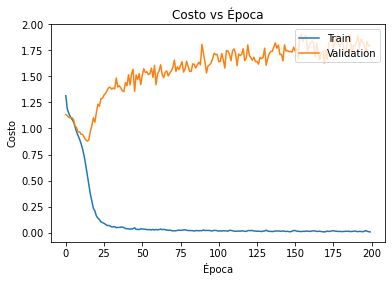

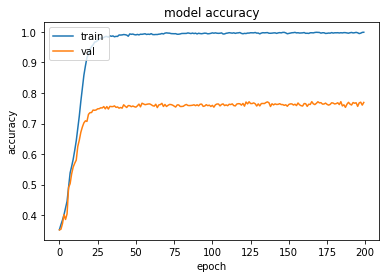

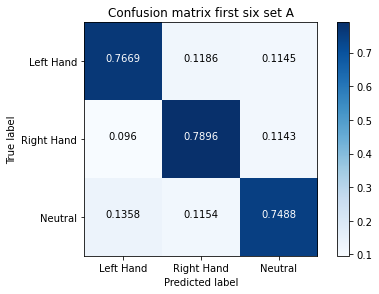

In [37]:
testers(1e-3,model,epochs=200,batch_size=40)